In [1]:
!pip install tensorflow==2.15.0 tensorflow-estimator==2.15.0 tensorflow-privacy==0.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 38.4 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.

In [ ]:
def load_and_sample(image_paths, samples_per_class=50, is_training=True, verbose=-1):
    data = []
    labels = []
    class_samples = defaultdict(list)

    # First, organize images by class
    for imgpath in image_paths:
        label = imgpath.split(os.path.sep)[-2]
        class_samples[label].append(imgpath)

    # Calculate the number of samples for training (70%) and testing (30%)
    train_samples = int(samples_per_class * 0.7)
    test_samples = samples_per_class - train_samples

    # Then, sample from each class
    for label, samples in class_samples.items():
        if is_training:
            num_samples = min(train_samples, len(samples))
        else:
            num_samples = min(test_samples, len(samples))

        selected_samples = random.sample(samples, num_samples)

        for i, imgpath in enumerate(selected_samples):
            im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
            if im_gray is None:
                print(f"[ERROR] Could not read image: {imgpath}")
                continue
            image = cv2.resize(im_gray, (64, 64))  # Resize to a fixed size
            image = np.array(image).reshape(64, 64, 1)  # Add channel dimension
            data.append(image / 255.0)
            labels.append(label)
            if verbose > 0 and (i + 1) % verbose == 0:
                print(f"[INFO] processed {i + 1}/{len(selected_samples)} for class {label}")

    return np.array(data), np.array(labels)

def batch_data(X_train, y_train, bs=16):
    # Convert labels to one-hot encoding
    lb = LabelBinarizer()
    label = lb.fit_transform(y_train)
    # Use tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((X_train, label))
    return dataset.shuffle(len(label)).batch(bs)

class SimpleCNN:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Conv2D(16, (3, 3), activation='relu'))  # Reduce number of filters
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))  # Reduce number of filters
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))  # Reduce number of filters
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))  # Reduce number of neurons
        model.add(Dense(classes, activation='softmax'))
        return model

def create_clients(image_list, label_list, num_clients=10, initial='client'):
    client_names = ['{}_{}'.format(initial, i + 1) for i in range(num_clients)]
    data = list(zip(image_list, label_list))
    random.shuffle(data)
    size = len(data) // num_clients
    shards = [data[i:i + size] for i in range(0, size * num_clients, size)]
    assert len(shards) == len(client_names)
    return {client_names[i]: shards[i] for i in range(len(client_names))}

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer

def weight_scaling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names]) * bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() * bs
    return local_count / global_count
def scale_model_weights(weight, scalar):
    return [scalar * w for w in weight]

def sum_scaled_weights(scaled_weight_list):
    avg_grad = []
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad

def test_model(X_test, Y_test, model, model_name, dp_params, num_clients, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    preds = tf.argmax(logits, axis=1)
    acc = accuracy_score(np.argmax(Y_test, axis=1), preds)
    prec = precision_score(np.argmax(Y_test, axis=1), preds, average='weighted', zero_division=1)
    rec = recall_score(np.argmax(Y_test, axis=1), preds, average='weighted')
    f1 = f1_score(np.argmax(Y_test, axis=1), preds, average='weighted')
    auc = roc_auc_score(Y_test, logits, multi_class='ovr', average='weighted')

    print(f'Model: {model_name} | DP Params: {dp_params} | Clients: {num_clients} | Round: {comm_round}')
    print(f'Accuracy: {acc:.3%} | Loss: {loss:.4f} | Precision: {prec:.3%} | Recall: {rec:.3%} | F1: {f1:.3%} | AUC: {auc:.3%}')

    # Confusion Matrix
    cm = confusion_matrix(np.argmax(Y_test, axis=1), preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} (Round {comm_round})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{model_name}_round_{comm_round}.png')
    plt.show()

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], logits[:, i])
        roc_auc[i] = roc_auc_score(Y_test[:, i], logits[:, i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (Round {comm_round})')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_{model_name}_round_{comm_round}.png')
    plt.show()

    return acc, loss, prec, rec, f1, auc

# Load data
from collections import defaultdict # Import defaultdict

train_img_path = '/content/drive/MyDrive/brain-MRI/Training'
test_image_path = '/content/drive/MyDrive/brain-MRI/Testing'

train_image_paths = list(paths.list_images(train_img_path))
test_image_paths = list(paths.list_images(test_image_path))

print(f"Found {len(train_image_paths)} total training images")
print(f"Found {len(test_image_paths)} total testing images")

# Define the total number of samples per class (adjust this value as needed)
total_samples_per_class = 200

# Load training images (70% of the samples per class)
train_data, train_labels = load_and_sample(train_image_paths, samples_per_class=total_samples_per_class, is_training=True, verbose=10)
# Load testing images (30% of the samples per class)
test_data, test_labels = load_and_sample(test_image_paths, samples_per_class=total_samples_per_class, is_training=False, verbose=10)

print(f"Loaded {len(train_data)} sampled training images")
print(f"Loaded {len(test_data)} sampled testing images")

# Print class distribution
for dataset_name, labels in [("Training", train_labels), ("Testing", test_labels)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{dataset_name} class distribution:")
    for label, count in zip(unique, counts):
        print(f"  {label}: {count}")

X_train = train_data
y_train = train_labels

X_test = test_data
y_test = test_labels

# Print final shapes
print("\nFinal data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Split data
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# One-hot encoding the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
num_classes = len(lb.classes_)

# Create clients
clients = create_clients(X_train, y_train, num_clients=2, initial='client')



# Process and batch the training data for each client
clients_batched = {}
for client, data in clients.items():
    X_train_client = np.array([x for x, _ in data])  # Extract data for the client
    y_train_client = np.array([y for _, y in data])  # Extract labels for the client
    clients_batched[client] = batch_data(X_train_client, y_train_client)  # Batch the client data

# Process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))


# Initialize global model
input_shape = (64, 64, 1)

global_model = SimpleCNN.build(input_shape, num_classes)
global_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(
                         learning_rate=0.01,
                         momentum=0.9
                     ),
                     metrics=['accuracy'])

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)

    gradients = model.optimizer._compute_gradients(loss, model.trainable_variables, tape=tape)

    gradients = [tf.reshape(g, v.shape) if g is not None and tf.size(g) == tf.size(v) else None
                 for g, v in zip(gradients, model.trainable_variables)]

    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

dp_param_list = [
                 {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1},
                 {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1},
                 {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1}
                 ]

dp_results = []
comms_round = [10,15,20,25,30,40,50]
epochs=[10,20,30,50,60,70,80]
for comm_round in comms_round: # Iterate directly over the list
  for dp_params in dp_param_list:
    for epoch in epochs: # Iterate directly over the list
      global_weights = global_model.get_weights()
      scaled_local_weight_list = []
      for client in clients.keys(): # Iterate over clients
        local_model = SimpleCNN.build(input_shape, num_classes) # Now correctly indented
        # !pip install tensorflow_privacy # Install if not already installed
        from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
        dp_optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=dp_params['l2_norm_clip'], # Use dp_params here
            noise_multiplier=dp_params['noise_multiplier'],
            num_microbatches=dp_params['num_microbatches'],
            learning_rate=0.0001  # Reduce learning rate
        )
        local_model.compile(loss='categorical_crossentropy',
                            optimizer=dp_optimizer,
                            metrics=['accuracy'])
        local_model.set_weights(global_weights)

        local_data = clients_batched[client]

        # Increase the number of epochs
        local_model.fit(local_data, epochs=epoch, verbose=0) # Use epoch here, not epochs

        scaling_factor = weight_scaling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

      average_weights = sum_scaled_weights(scaled_local_weight_list) # Dedent to be outside the client loop
      global_model.set_weights(average_weights)

      # Test the global model and generate reports
      for (X_test, Y_test) in test_batched:
          # Pass the missing arguments to test_model and make sure the number of arguments matches the definition of test_model
          acc, loss, prec, rec, f1, auc = test_model(X_test, Y_test, global_model,local_model, dp_params, num_clients, comm_round)
          dp_results.append((acc, loss, prec, rec, f1, auc))


## Federated learning with Differential Privacy parameters with basic deep learning

In [ ]:
import os
import random
import numpy as np
import cv2
from imutils import paths
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import tensorflow_privacy as tfp
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_and_sample(image_paths, samples_per_class=50, is_training=True, verbose=-1):
    data = []
    labels = []
    class_samples = defaultdict(list)

    # First, organize images by class
    for imgpath in image_paths:
        label = imgpath.split(os.path.sep)[-2]
        class_samples[label].append(imgpath)

    # Calculate the number of samples for training (70%) and testing (30%)
    train_samples = int(samples_per_class * 0.7)
    test_samples = samples_per_class - train_samples

    # Then, sample from each class
    for label, samples in class_samples.items():
        if is_training:
            num_samples = min(train_samples, len(samples))
        else:
            num_samples = min(test_samples, len(samples))

        selected_samples = random.sample(samples, num_samples)

        for i, imgpath in enumerate(selected_samples):
            im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
            if im_gray is None:
                print(f"[ERROR] Could not read image: {imgpath}")
                continue
            image = cv2.resize(im_gray, (64, 64))  # Resize to a fixed size
            image = np.array(image).reshape(64, 64, 1)  # Add channel dimension
            data.append(image / 255.0)
            labels.append(label)
            if verbose > 0 and (i + 1) % verbose == 0:
                print(f"[INFO] processed {i + 1}/{len(selected_samples)} for class {label}")

    return np.array(data), np.array(labels)

In [ ]:
def create_clients(image_list, label_list, num_clients=10, initial='client'):
    client_names = ['{}_{}'.format(initial, i + 1) for i in range(num_clients)]
    data = list(zip(image_list, label_list))
    random.shuffle(data)
    size = len(data) // num_clients
    shards = [data[i:i + size] for i in range(0, size * num_clients, size)]
    assert len(shards) == len(client_names)
    return {client_names[i]: shards[i] for i in range(len(client_names))}

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer

In [ ]:
def batch_data(X_train, y_train, bs=16):
    # Convert labels to one-hot encoding
    lb = LabelBinarizer()
    label = lb.fit_transform(y_train)
    # Use tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((X_train, label))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
def weight_scaling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names]) * bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() * bs
    return local_count / global_count


In [ ]:
def scale_model_weights(weight, scalar):
    return [scalar * w for w in weight]

In [ ]:
def sum_scaled_weights(scaled_weight_list):
    avg_grad = []
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad

In [ ]:
def test_model(X_test, Y_test, model, model_name, dp_params, num_clients, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    preds = tf.argmax(logits, axis=1)
    acc = accuracy_score(np.argmax(Y_test, axis=1), preds)
    prec = precision_score(np.argmax(Y_test, axis=1), preds, average='weighted', zero_division=1)
    rec = recall_score(np.argmax(Y_test, axis=1), preds, average='weighted')
    f1 = f1_score(np.argmax(Y_test, axis=1), preds, average='weighted')
    auc = roc_auc_score(Y_test, logits, multi_class='ovr', average='weighted')

    print(f'Model: {model_name} | DP Params: {dp_params} | Clients: {num_clients} | Round: {comm_round}')
    print(f'Accuracy: {acc:.3%} | Loss: {loss:.4f} | Precision: {prec:.3%} | Recall: {rec:.3%} | F1: {f1:.3%} | AUC: {auc:.3%}')

    # Confusion Matrix
    cm = confusion_matrix(np.argmax(Y_test, axis=1), preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} (Round {comm_round})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'confusion_matrix_{model_name}_round_{comm_round}.png')
    plt.show()

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], logits[:, i])
        roc_auc[i] = roc_auc_score(Y_test[:, i], logits[:, i])

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (Round {comm_round})')
    plt.legend(loc="lower right")
    plt.savefig(f'roc_curve_{model_name}_round_{comm_round}.png')
    plt.show()

    return acc, loss, prec, rec, f1, auc

In [ ]:
# Load data
from collections import defaultdict # Import defaultdict

train_img_path = '/content/drive/MyDrive/brain-MRI/Training'
test_image_path = '/content/drive/MyDrive/brain-MRI/Testing'

train_image_paths = list(paths.list_images(train_img_path))
test_image_paths = list(paths.list_images(test_image_path))

print(f"Found {len(train_image_paths)} total training images")
print(f"Found {len(test_image_paths)} total testing images")

# Define the total number of samples per class (adjust this value as needed)
total_samples_per_class = 200

# Load training images (70% of the samples per class)
train_data, train_labels = load_and_sample(train_image_paths, samples_per_class=total_samples_per_class, is_training=True, verbose=10)
# Load testing images (30% of the samples per class)
test_data, test_labels = load_and_sample(test_image_paths, samples_per_class=total_samples_per_class, is_training=False, verbose=10)

print(f"Loaded {len(train_data)} sampled training images")
print(f"Loaded {len(test_data)} sampled testing images")

# Print class distribution
for dataset_name, labels in [("Training", train_labels), ("Testing", test_labels)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{dataset_name} class distribution:")
    for label, count in zip(unique, counts):
        print(f"  {label}: {count}")

X_train = train_data
y_train = train_labels

X_test = test_data
y_test = test_labels

# Print final shapes
print("\nFinal data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Found 5712 total training images

Found 1311 total testing images

[INFO] processed 10/140 for class pituitary

[INFO] processed 20/140 for class pituitary

[INFO] processed 30/140 for class pituitary

[INFO] processed 40/140 for class pituitary

[INFO] processed 50/140 for class pituitary

[INFO] processed 60/140 for class pituitary

[INFO] processed 70/140 for class pituitary

[INFO] processed 80/140 for class pituitary

[INFO] processed 90/140 for class pituitary

[INFO] processed 100/140 for class pituitary

[INFO] processed 110/140 for class pituitary

[INFO] processed 120/140 for class pituitary

[INFO] processed 130/140 for class pituitary

[INFO] processed 140/140 for class pituitary

[INFO] processed 10/140 for class notumor

[INFO] processed 20/140 for class notumor

[INFO] processed 30/140 for class notumor

[INFO] processed 40/140 for class notumor

[INFO] processed 50/140 for class notumor

[INFO] processed 60/140 for class notumor

[INFO] processed 70/140 for class notumo

In [ ]:
class SimpleCNN:
    @staticmethod
    def build(input_shape, classes):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Conv2D(16, (3, 3), activation='relu'))  # Reduce number of filters
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))  # Reduce number of filters
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))  # Reduce number of filters
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))  # Reduce number of neurons
        model.add(Dense(classes, activation='softmax'))
        return model

In [ ]:
# Split data
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# One-hot encoding the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
num_classes = len(lb.classes_)

# Create clients
clients = create_clients(X_train, y_train, num_clients=2, initial='client')



# Process and batch the training data for each client
clients_batched = {}
for client, data in clients.items():
    X_train_client = np.array([x for x, _ in data])  # Extract data for the client
    y_train_client = np.array([y for _, y in data])  # Extract labels for the client
    clients_batched[client] = batch_data(X_train_client, y_train_client)  # Batch the client data

# Process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))


# Initialize global model
input_shape = (64, 64, 1)

global_model = SimpleCNN.build(input_shape, num_classes)
global_model.compile(loss='categorical_crossentropy',
                     optimizer=SGD(
                         learning_rate=0.01,
                         momentum=0.9
                     ),
                     metrics=['accuracy'])

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
        loss = tf.reduce_mean(loss)

    gradients = model.optimizer._compute_gradients(loss, model.trainable_variables, tape=tape)

    gradients = [tf.reshape(g, v.shape) if g is not None and tf.size(g) == tf.size(v) else None
                 for g, v in zip(gradients, model.trainable_variables)]

    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [ ]:
dp_param_list = [
                 {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1},
                 {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1},
                 {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1}
                 ]

dp_results = []
comms_round = [10,15,20,25,30]
epochs=[10,20,30,50,60]
for comm_round in comms_round: # Iterate directly over the list
  for dp_params in dp_param_list:
    for epoch in epochs: # Iterate directly over the list
      global_weights = global_model.get_weights()
      scaled_local_weight_list = []
      for client in clients.keys(): # Iterate over clients
        local_model = SimpleCNN.build(input_shape, num_classes) # Now correctly indented
        # !pip install tensorflow_privacy # Install if not already installed
        from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
        dp_optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=dp_params['l2_norm_clip'], # Use dp_params here
            noise_multiplier=dp_params['noise_multiplier'],
            num_microbatches=dp_params['num_microbatches'],
            learning_rate=0.0001  # Reduce learning rate
        )
        local_model.compile(loss='categorical_crossentropy',
                            optimizer=dp_optimizer,
                            metrics=['accuracy'])
        local_model.set_weights(global_weights)

        local_data = clients_batched[client]

        # Increase the number of epochs
        local_model.fit(local_data, epochs=epoch, verbose=0) # Use epoch here, not epochs

        scaling_factor = weight_scaling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

      average_weights = sum_scaled_weights(scaled_local_weight_list) # Dedent to be outside the client loop
      global_model.set_weights(average_weights)

      # Test the global model and generate reports
      for (X_test, Y_test) in test_batched:
          acc, loss, prec, rec, f1, auc = test_model(X_test, Y_test, global_model, comm_round)
          dp_results.append((acc, loss, prec, rec, f1, auc))

In [ ]:
dp_param_list = [
                 {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1},
                 {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1},
                 {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1}
                 ]

dp_results = []
comms_round = [10,15,20,25,30,40,50]
epochs=[10,20,30,50,60,70,80]
for comm_round in comms_round: # Iterate directly over the list
  for dp_params in dp_param_list:
    for epoch in epochs: # Iterate directly over the list
      global_weights = global_model.get_weights()
      scaled_local_weight_list = []
      for client in clients.keys(): # Iterate over clients
        local_model = SimpleCNN.build(input_shape, num_classes) # Now correctly indented
        # !pip install tensorflow_privacy # Install if not already installed
        from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
        dp_optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=dp_params['l2_norm_clip'], # Use dp_params here
            noise_multiplier=dp_params['noise_multiplier'],
            num_microbatches=dp_params['num_microbatches'],
            learning_rate=0.0001  # Reduce learning rate
        )
        local_model.compile(loss='categorical_crossentropy',
                            optimizer=dp_optimizer,
                            metrics=['accuracy'])
        local_model.set_weights(global_weights)

        local_data = clients_batched[client]

        # Increase the number of epochs
        local_model.fit(local_data, epochs=epoch, verbose=0) # Use epoch here, not epochs

        scaling_factor = weight_scaling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

      average_weights = sum_scaled_weights(scaled_local_weight_list) # Dedent to be outside the client loop
      global_model.set_weights(average_weights)

      # Test the global model and generate reports
      for (X_test, Y_test) in test_batched:
          # Pass the missing arguments to test_model and make sure the number of arguments matches the definition of test_model
          acc, loss, prec, rec, f1, auc = test_model(X_test, Y_test, global_model,local_model, dp_params, num_clients, comm_round)
          dp_results.append((acc, loss, prec, rec, f1, auc))

### Testing with communication round=100

8/8 [==============================] - 0s 47ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 30.833% | Loss: 1.3699 | Precision: 41.544% | Recall: 30.833% | F1: 22.168% | AUC: 72.178%


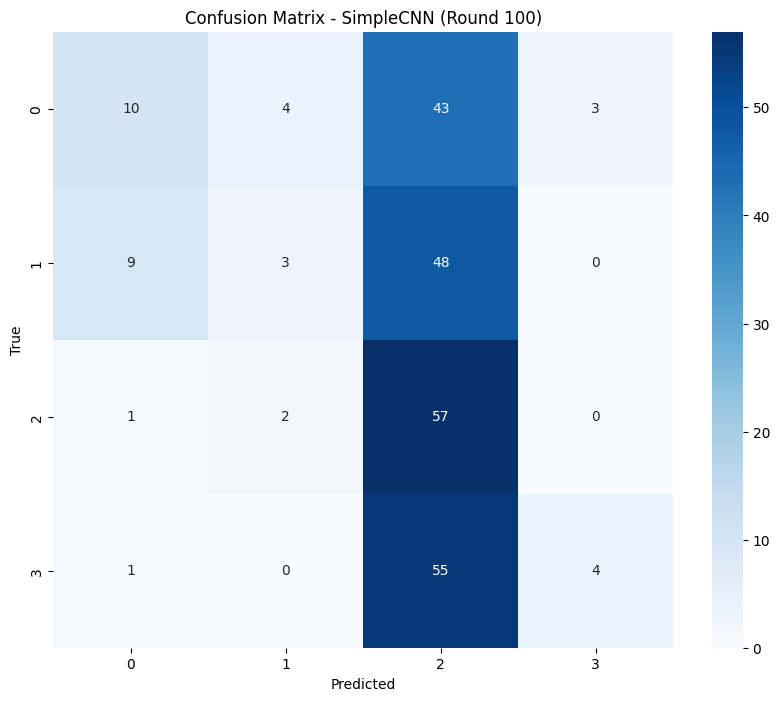

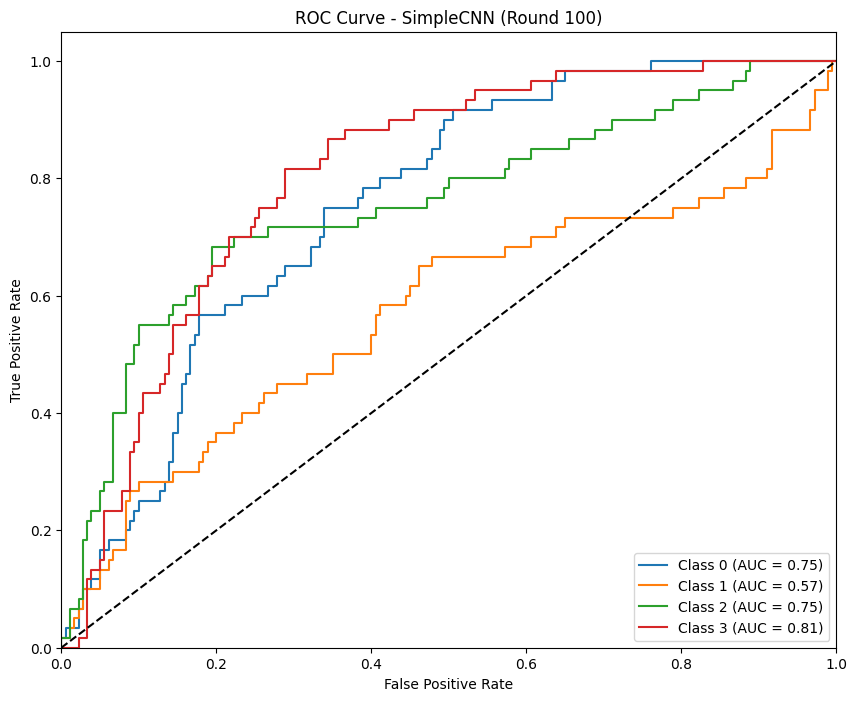

8/8 [==============================] - 0s 49ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 33.750% | Loss: 1.3665 | Precision: 46.164% | Recall: 33.750% | F1: 26.944% | AUC: 72.389%


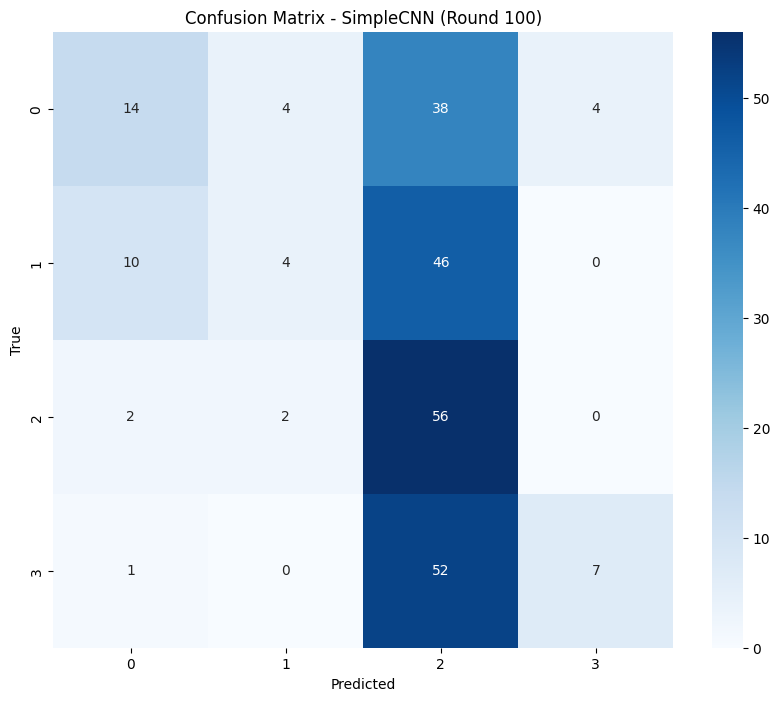

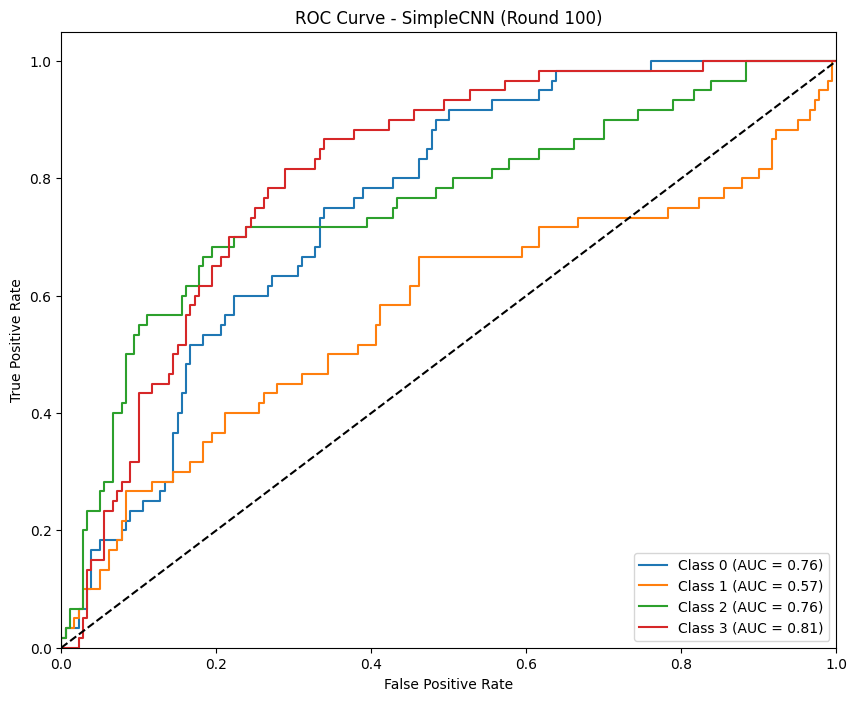

8/8 [==============================] - 1s 73ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 35.833% | Loss: 1.3638 | Precision: 48.946% | Recall: 35.833% | F1: 29.973% | AUC: 72.593%


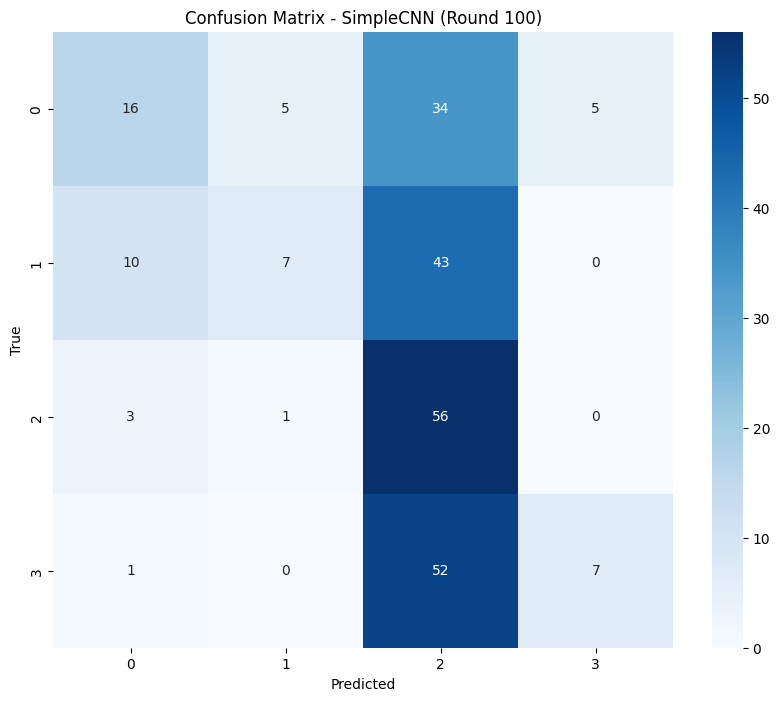

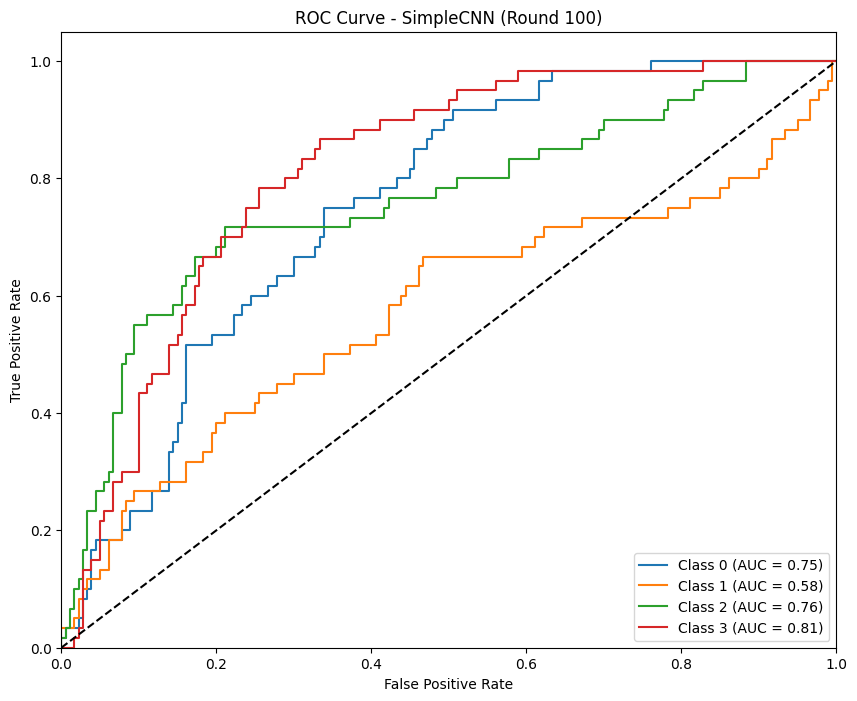

8/8 [==============================] - 0s 53ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 40.417% | Loss: 1.3575 | Precision: 56.407% | Recall: 40.417% | F1: 35.224% | AUC: 72.940%


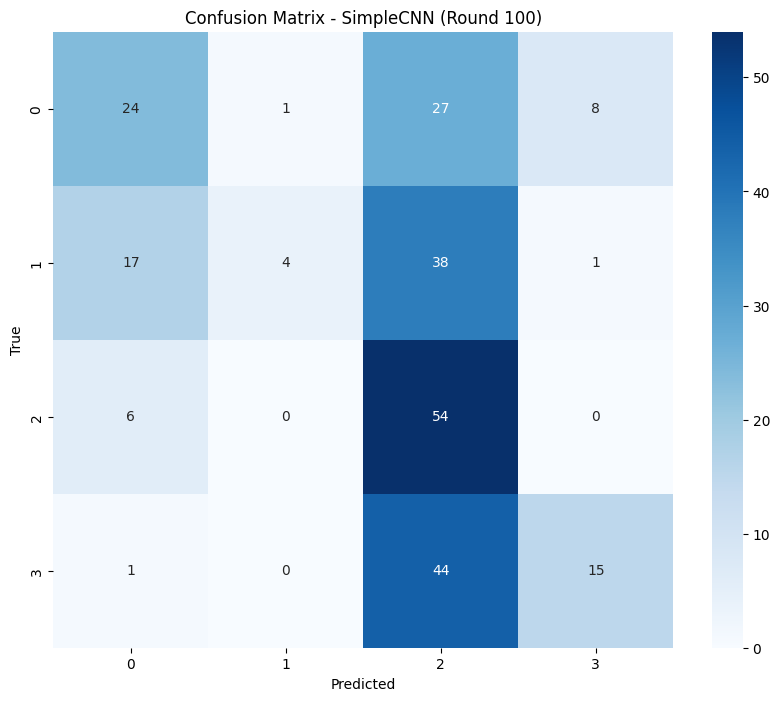

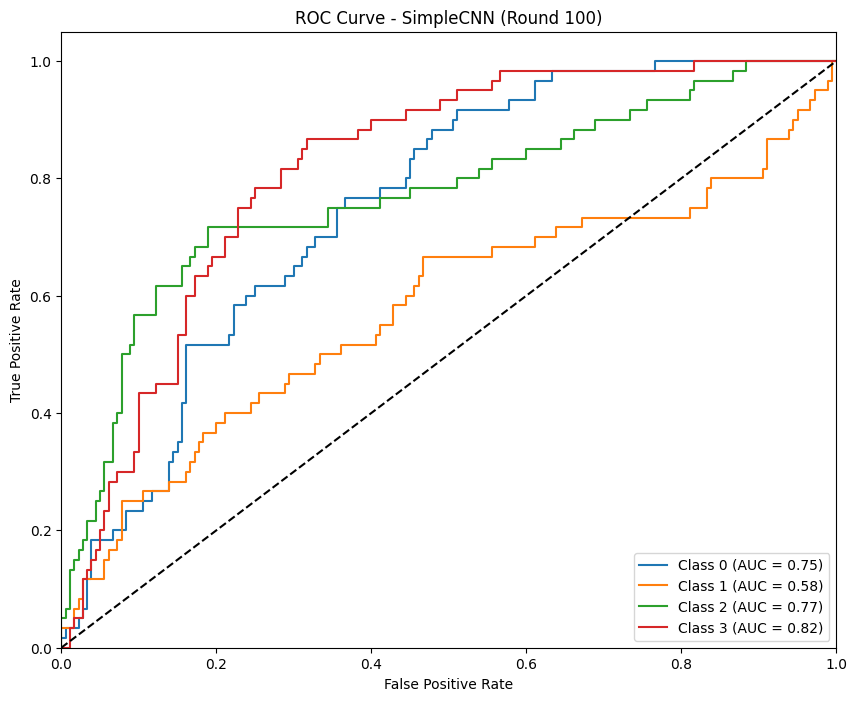

8/8 [==============================] - 0s 49ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 48.333% | Loss: 1.3555 | Precision: 41.817% | Recall: 48.333% | F1: 42.850% | AUC: 72.875%


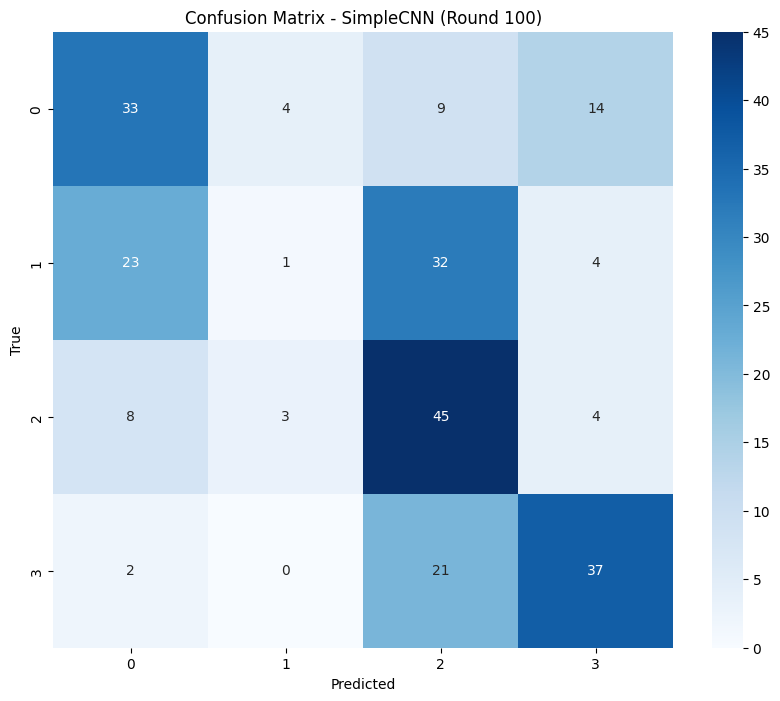

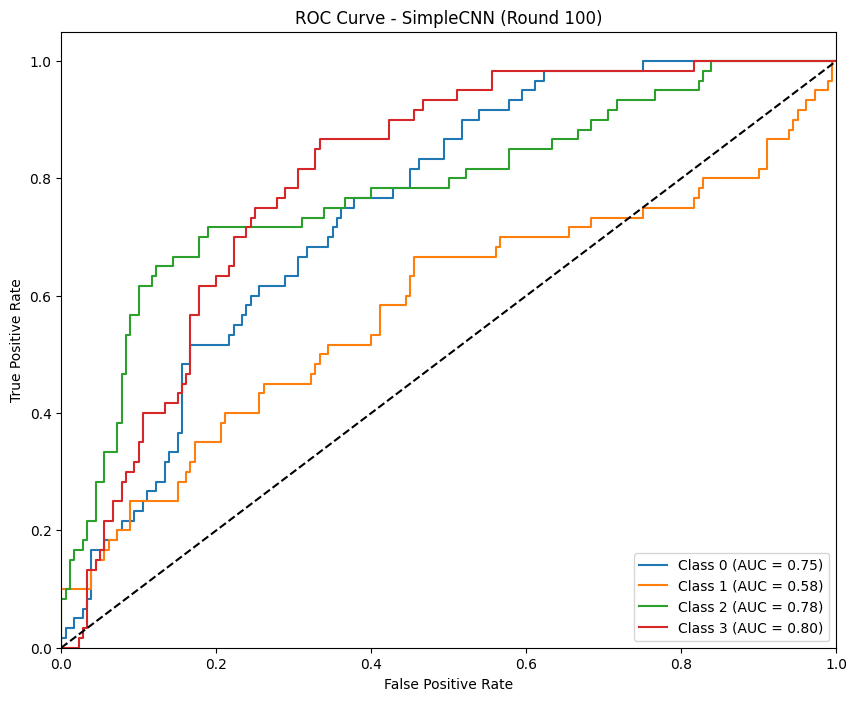

8/8 [==============================] - 0s 53ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 44.583% | Loss: 1.3463 | Precision: 45.563% | Recall: 44.583% | F1: 41.205% | AUC: 74.257%


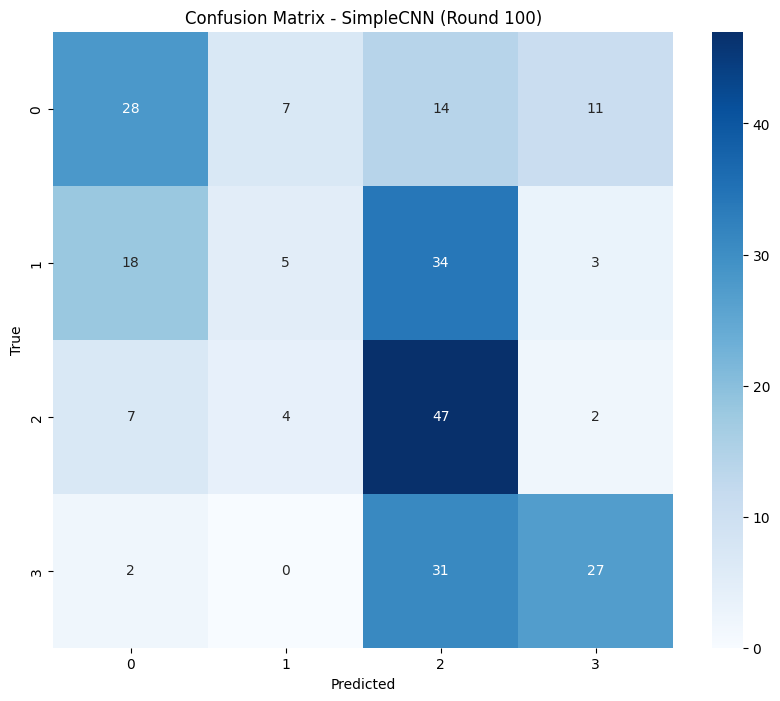

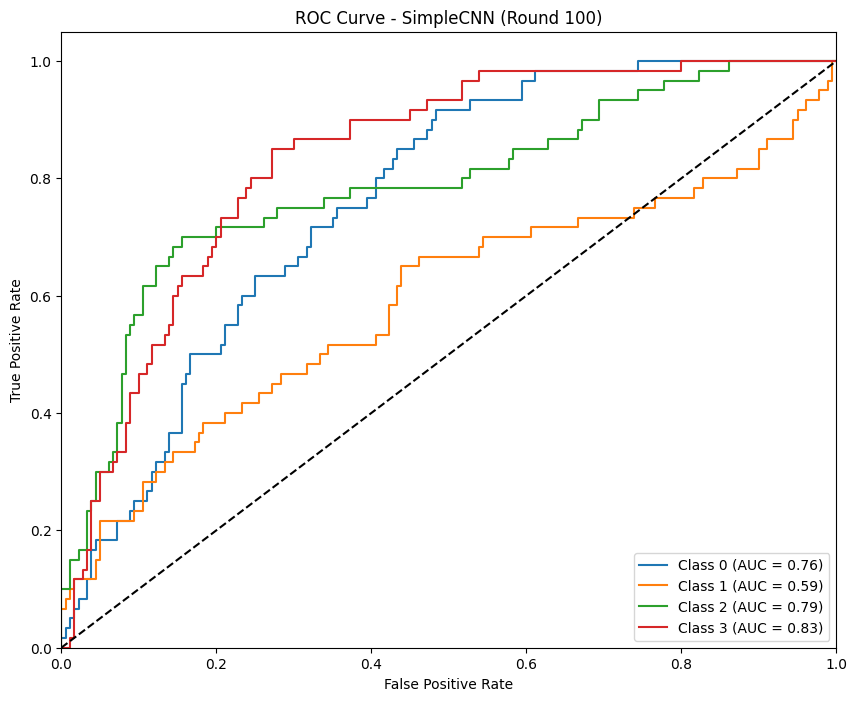

In [ ]:
dp_param_list = [
                 {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1},
                 {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1},
                 {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1}
                 ]

dp_results = []
comms_round = [100]
epochs=[50,100]
num_clients = len(clients) # Get the number of clients

for comm_round in comms_round: # Iterate directly over the list
  for dp_params in dp_param_list:
    for epoch in epochs: # Iterate directly over the list
      global_weights = global_model.get_weights()
      scaled_local_weight_list = []
      for client in clients.keys(): # Iterate over clients
        local_model = SimpleCNN.build(input_shape, num_classes) # Now correctly indented
        # !pip install tensorflow_privacy # Install if not already installed
        from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
        dp_optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=dp_params['l2_norm_clip'], # Use dp_params here
            noise_multiplier=dp_params['noise_multiplier'],
            num_microbatches=dp_params['num_microbatches'],
            learning_rate=0.0001  # Reduce learning rate
        )
        local_model.compile(loss='categorical_crossentropy',
                            optimizer=dp_optimizer,
                            metrics=['accuracy'])
        local_model.set_weights(global_weights)

        local_data = clients_batched[client]

        # Increase the number of epochs
        local_model.fit(local_data, epochs=epoch, verbose=0) # Use epoch here, not epochs

        scaling_factor = weight_scaling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

      average_weights = sum_scaled_weights(scaled_local_weight_list) # Dedent to be outside the client loop
      global_model.set_weights(average_weights)

      # Test the global model and generate reports
      for (X_test, Y_test) in test_batched:
          # Pass the missing arguments to test_model
          acc, loss, prec, rec, f1, auc = test_model(X_test, Y_test, global_model, 'SimpleCNN', dp_params, num_clients, comm_round)
          dp_results.append((acc, loss, prec, rec, f1, auc))

### Testing for rounds 100 and 200

8/8 [==============================] - 0s 45ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 46.250% | Loss: 1.3437 | Precision: 45.904% | Recall: 46.250% | F1: 42.787% | AUC: 74.366%


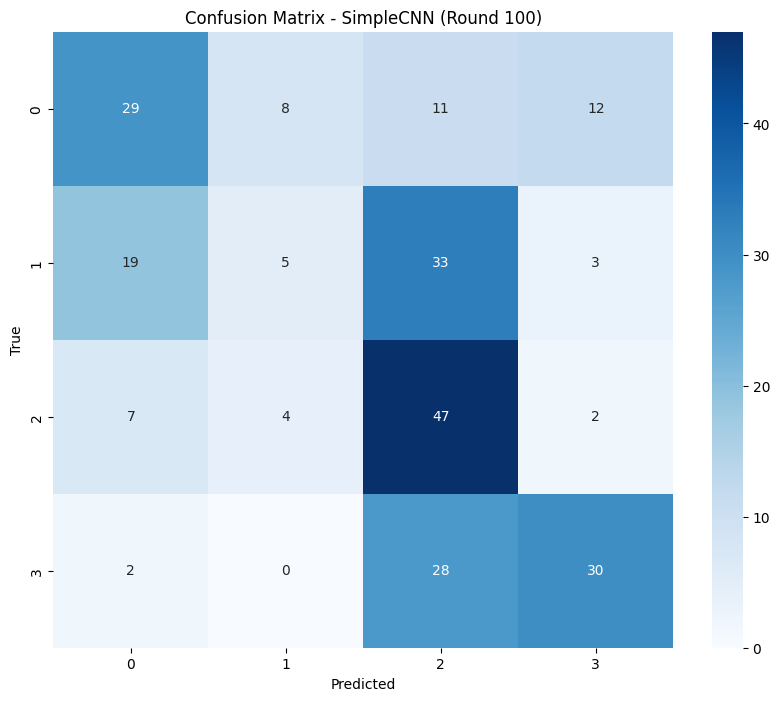

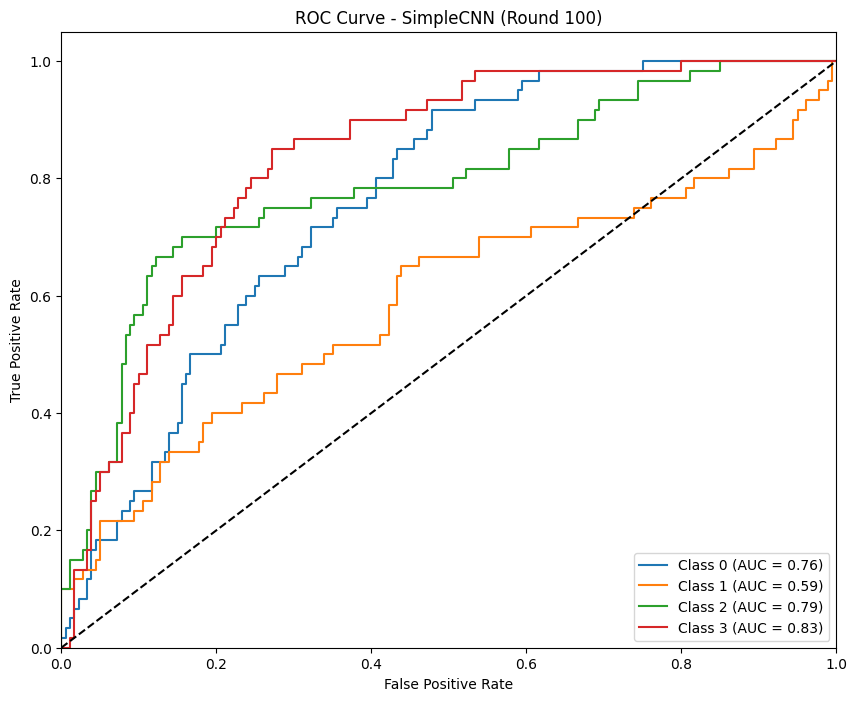

8/8 [==============================] - 0s 50ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 49.167% | Loss: 1.3385 | Precision: 49.146% | Recall: 49.167% | F1: 46.177% | AUC: 74.623%


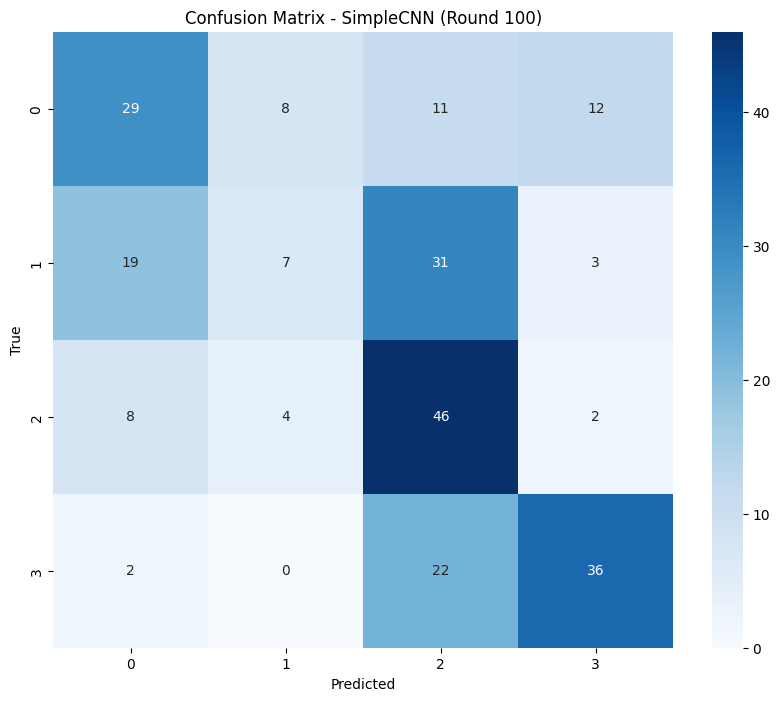

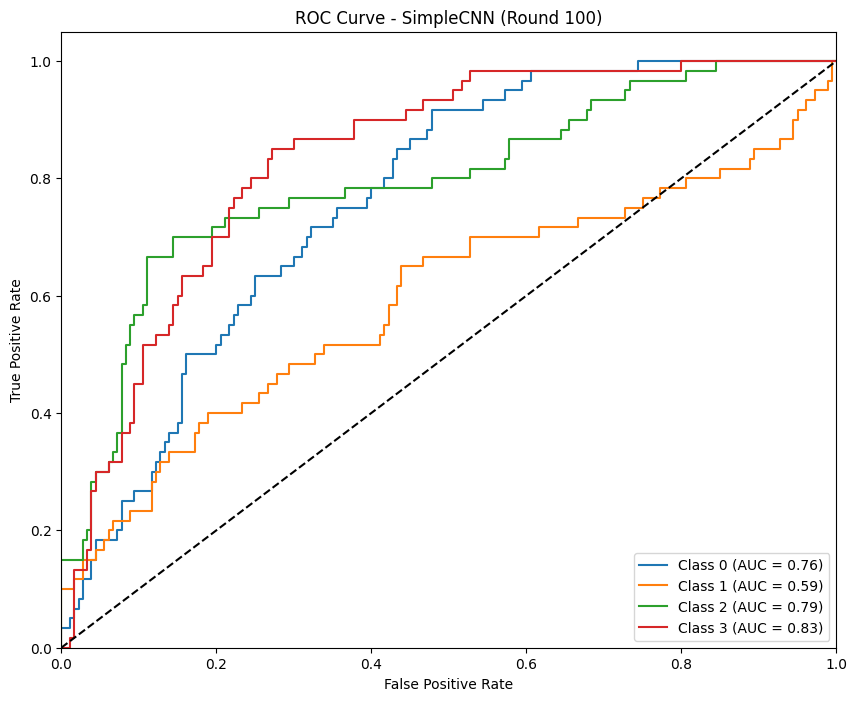

8/8 [==============================] - 0s 52ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 52.500% | Loss: 1.3282 | Precision: 52.042% | Recall: 52.500% | F1: 50.187% | AUC: 75.044%


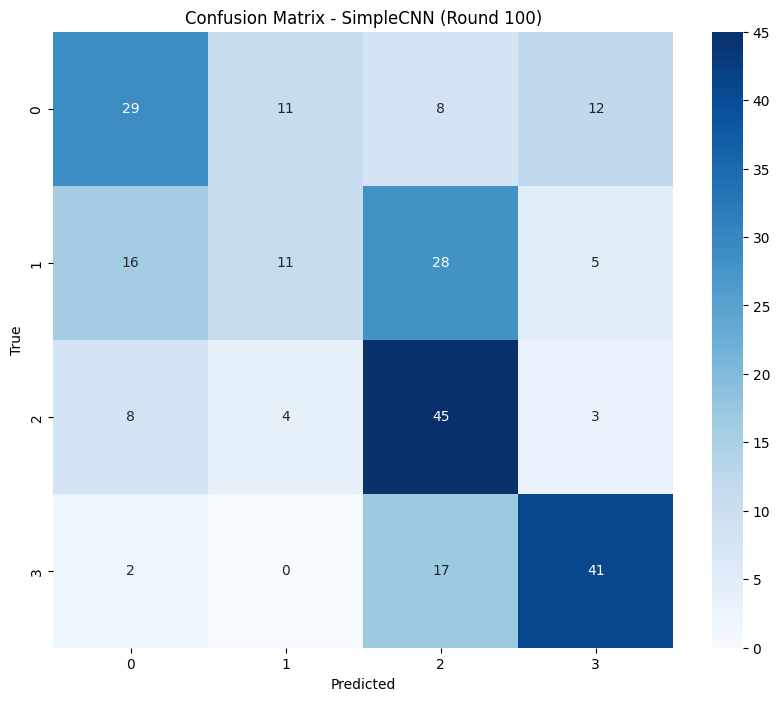

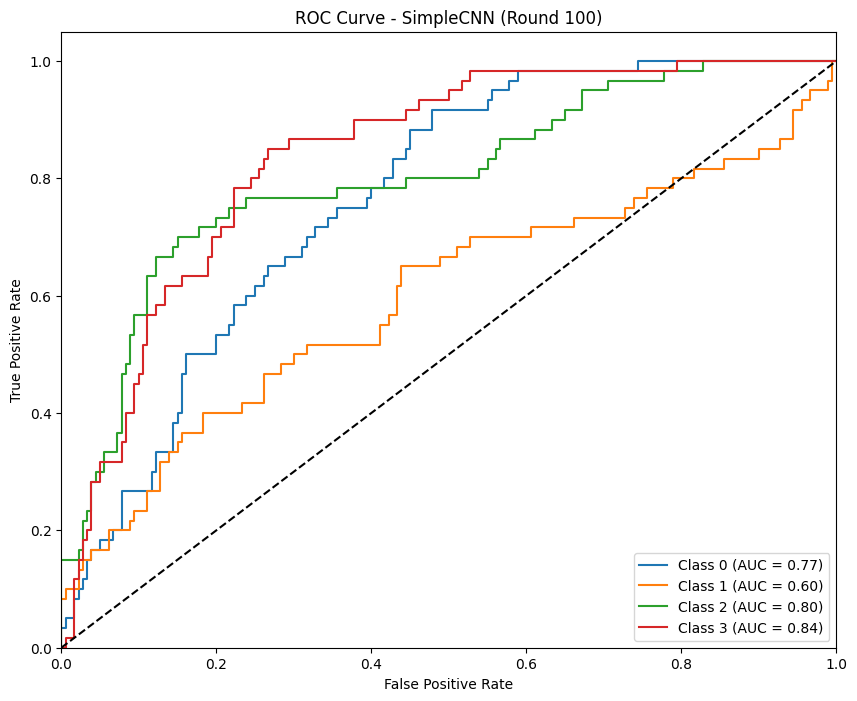

8/8 [==============================] - 1s 87ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 53.333% | Loss: 1.3242 | Precision: 52.567% | Recall: 53.333% | F1: 51.259% | AUC: 75.410%


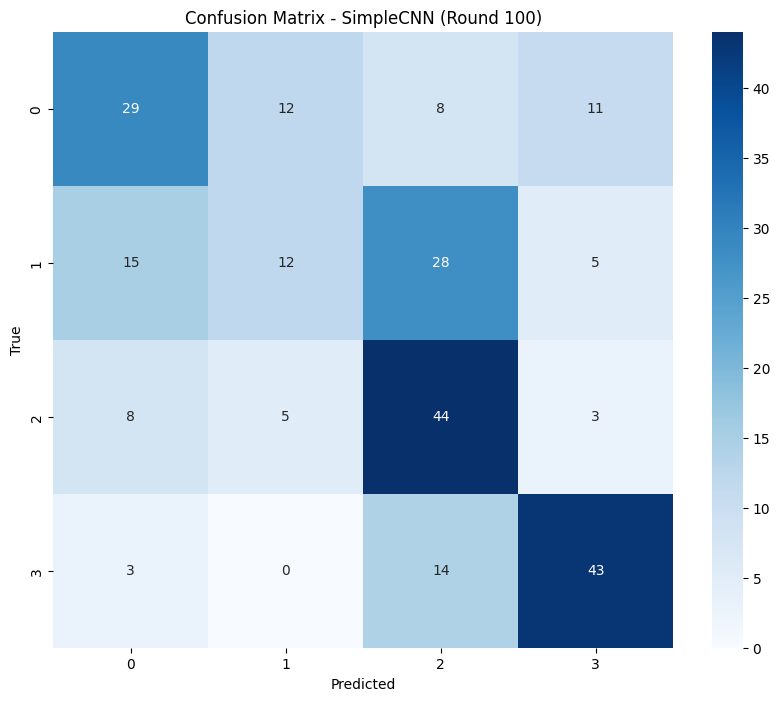

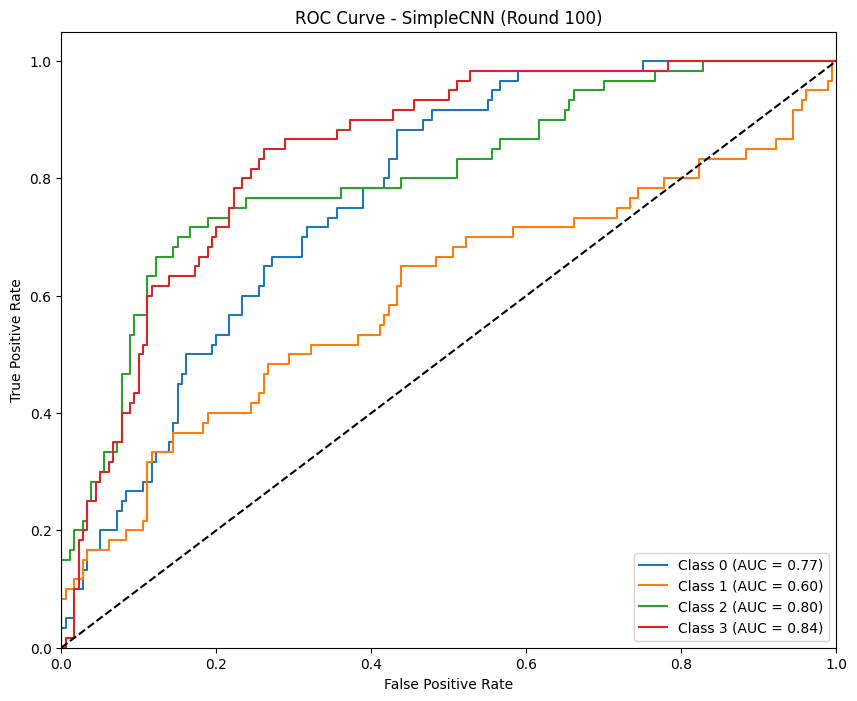

8/8 [==============================] - 0s 50ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 52.500% | Loss: 1.3171 | Precision: 49.691% | Recall: 52.500% | F1: 49.441% | AUC: 75.715%


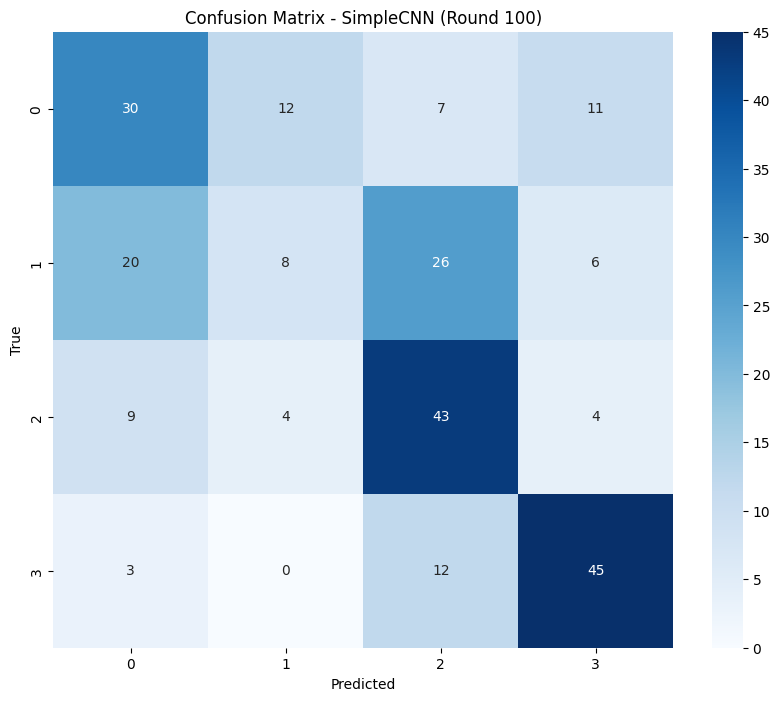

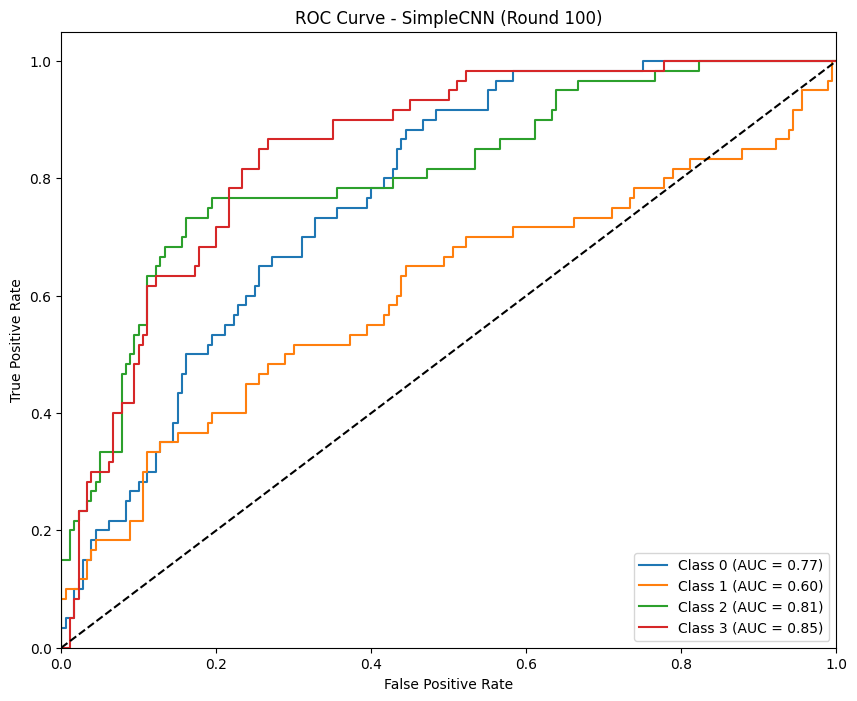

8/8 [==============================] - 0s 54ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 55.000% | Loss: 1.3017 | Precision: 52.343% | Recall: 55.000% | F1: 51.824% | AUC: 76.317%


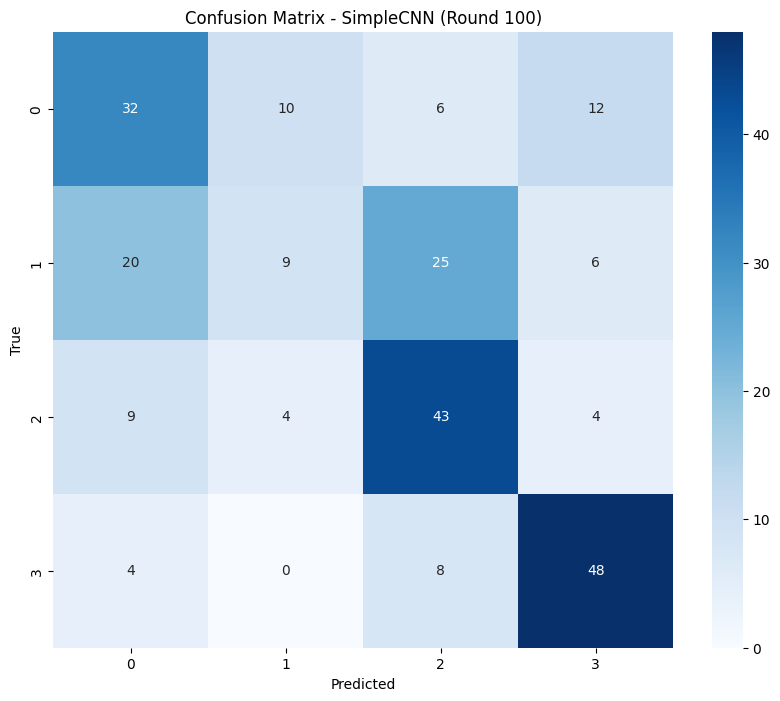

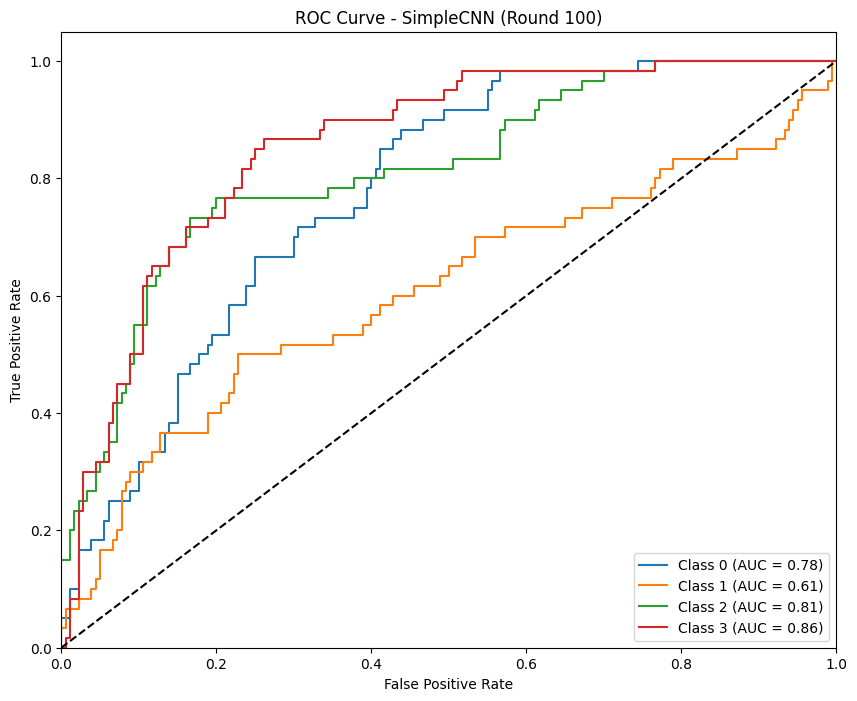

8/8 [==============================] - 1s 62ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 53.750% | Loss: 1.2967 | Precision: 50.084% | Recall: 53.750% | F1: 50.095% | AUC: 76.532%


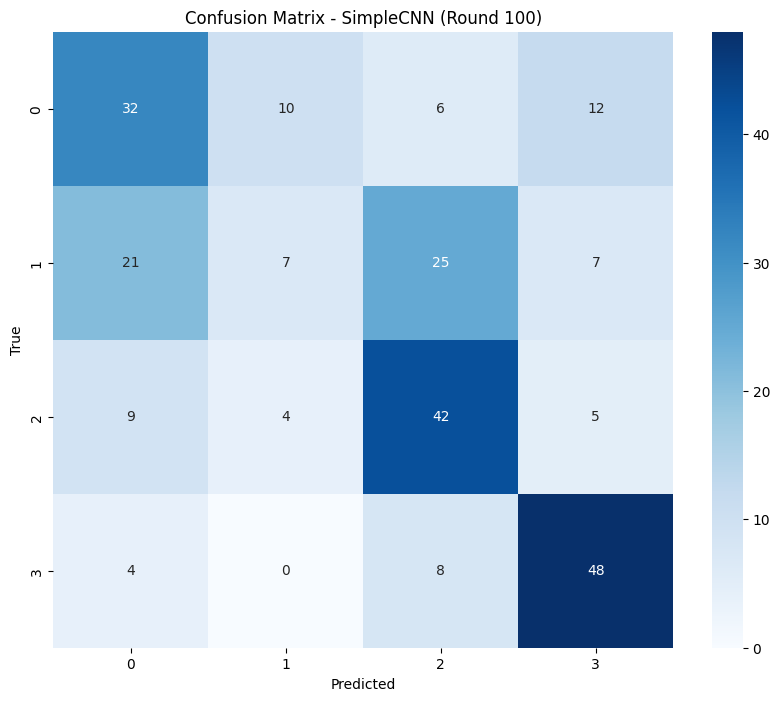

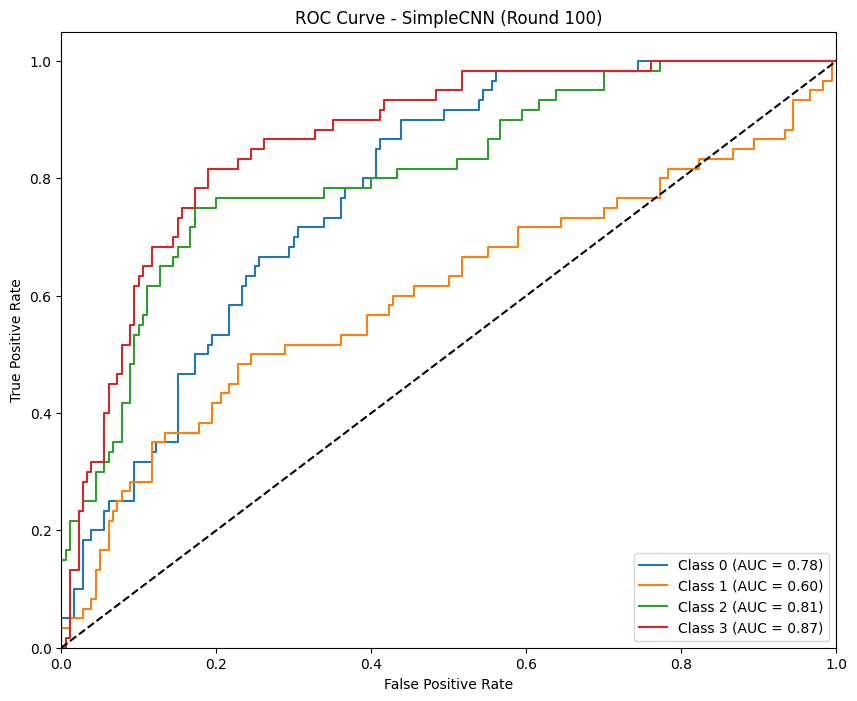

8/8 [==============================] - 0s 54ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 54.583% | Loss: 1.2899 | Precision: 51.446% | Recall: 54.583% | F1: 51.898% | AUC: 76.891%


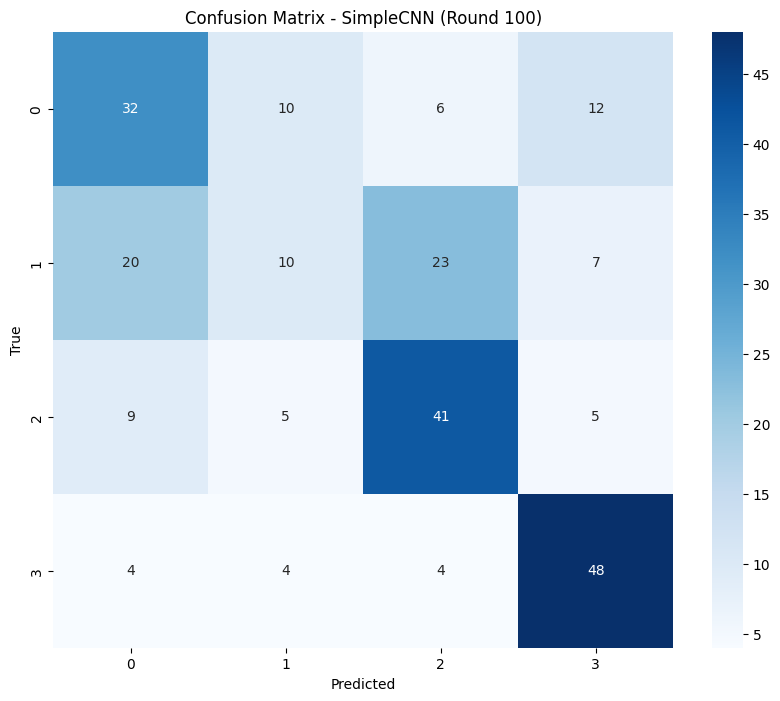

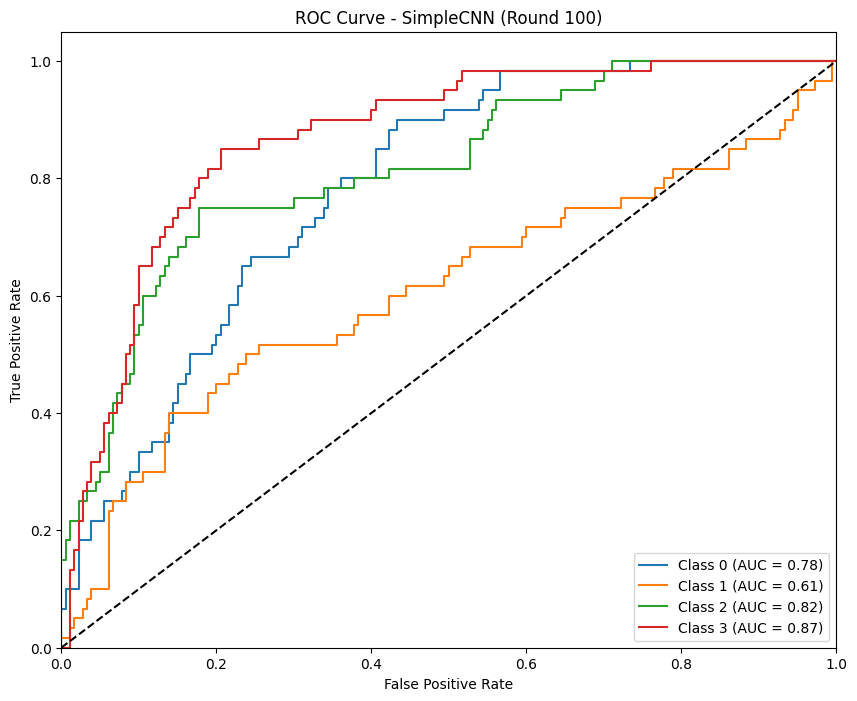

8/8 [==============================] - 0s 56ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 100

Accuracy: 55.833% | Loss: 1.2761 | Precision: 53.224% | Recall: 55.833% | F1: 53.581% | AUC: 77.630%


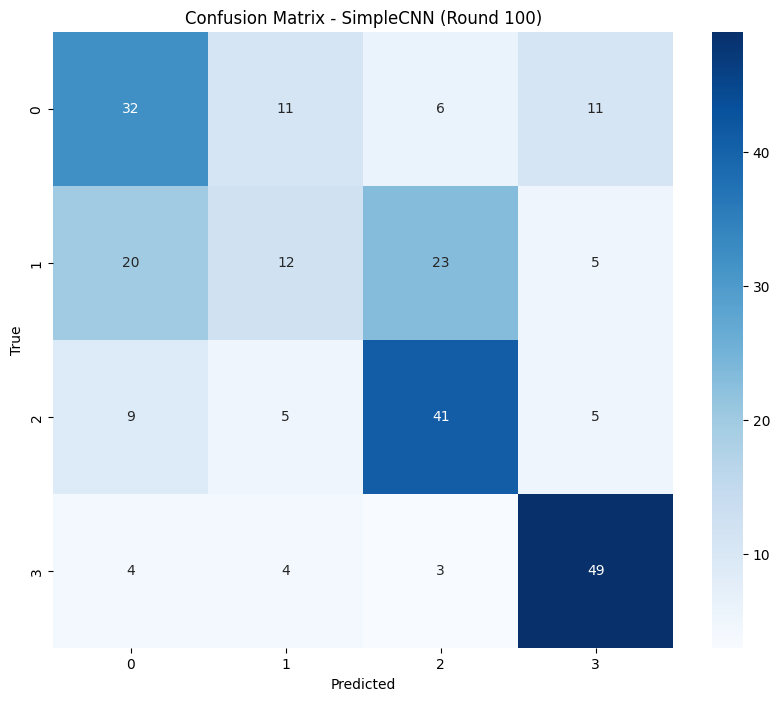

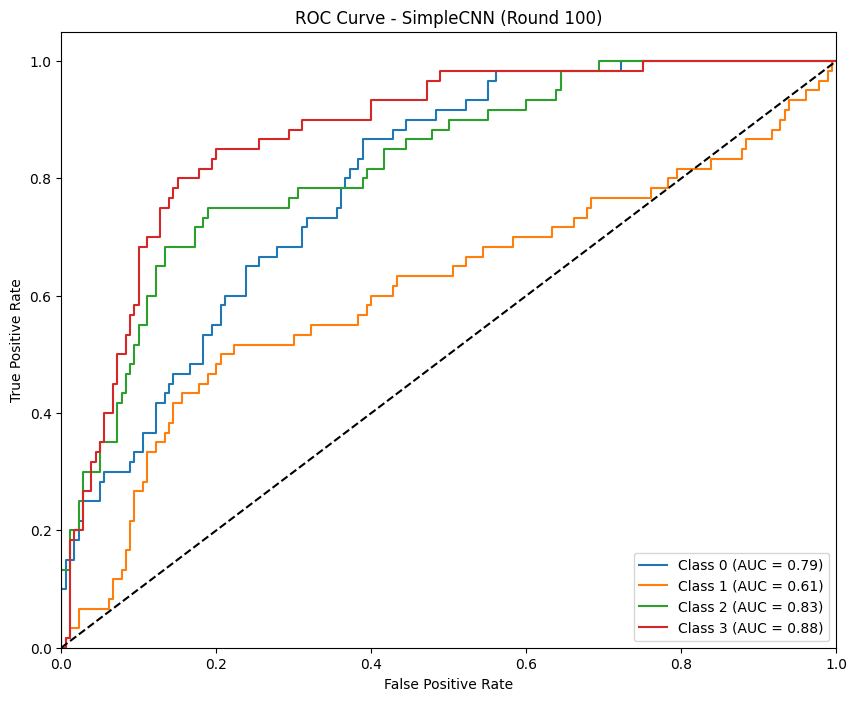

8/8 [==============================] - 0s 60ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 55.833% | Loss: 1.2728 | Precision: 53.230% | Recall: 55.833% | F1: 53.467% | AUC: 77.938%


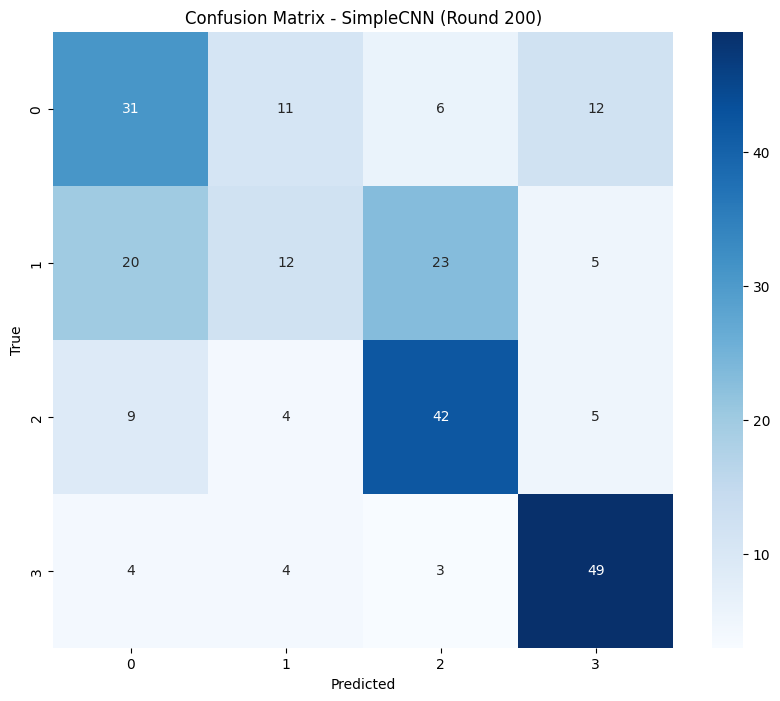

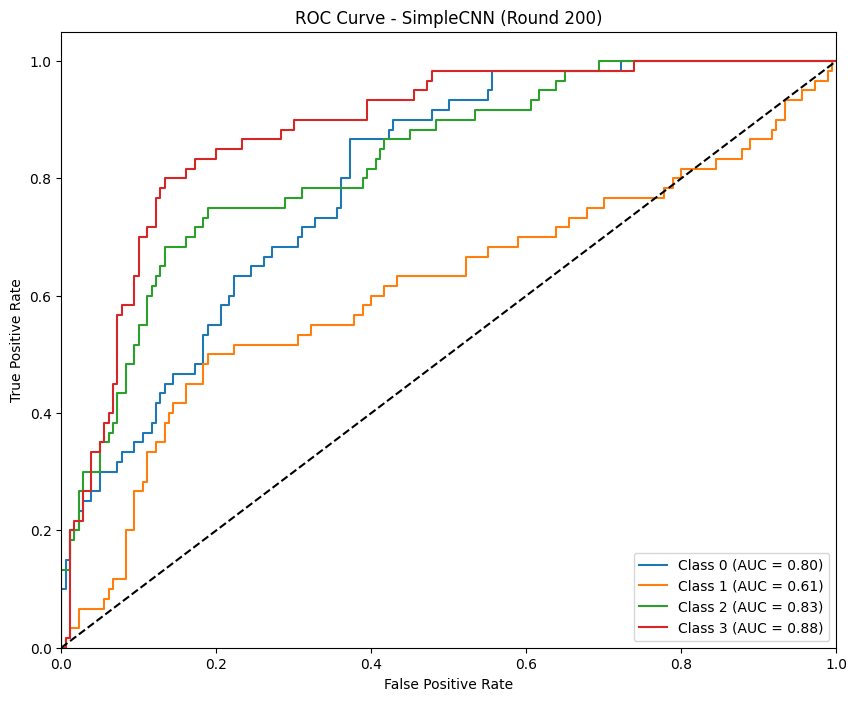

8/8 [==============================] - 0s 57ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 57.083% | Loss: 1.2680 | Precision: 55.028% | Recall: 57.083% | F1: 55.161% | AUC: 78.245%


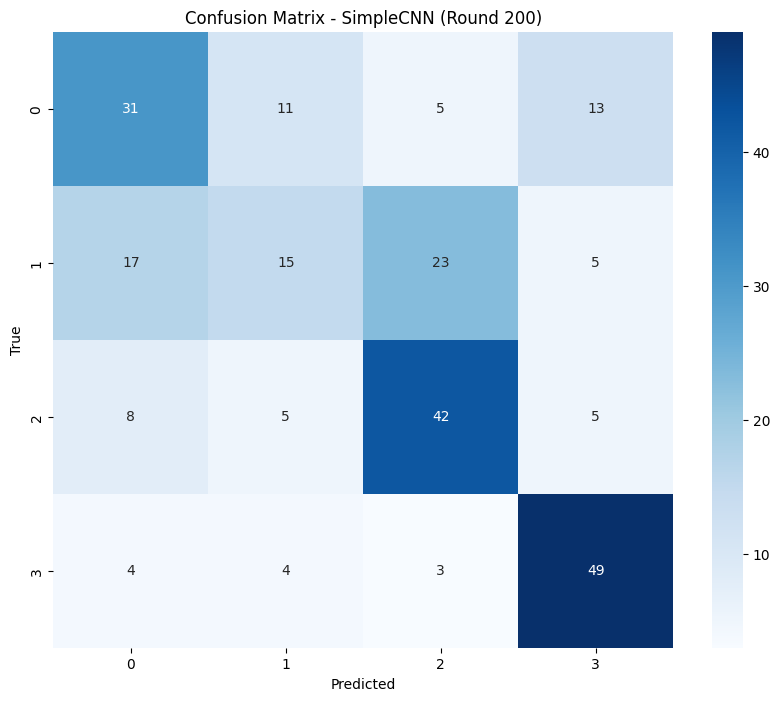

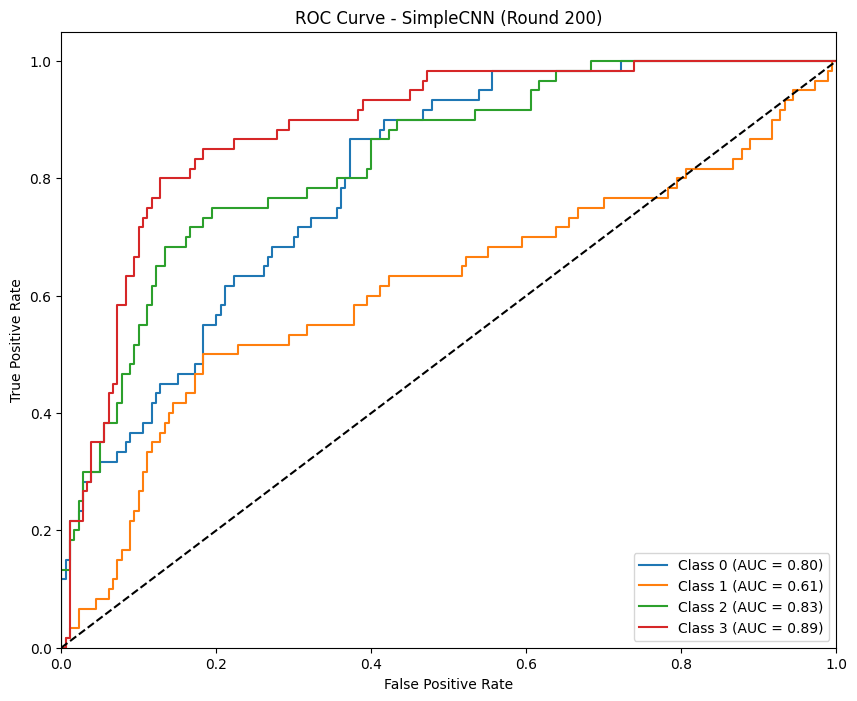

8/8 [==============================] - 1s 91ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 57.083% | Loss: 1.2601 | Precision: 54.908% | Recall: 57.083% | F1: 55.249% | AUC: 78.699%


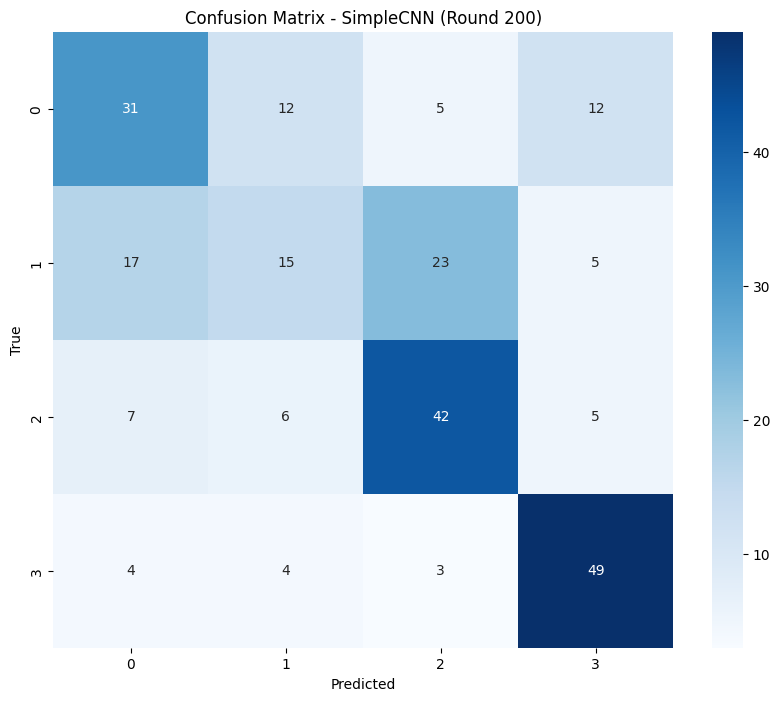

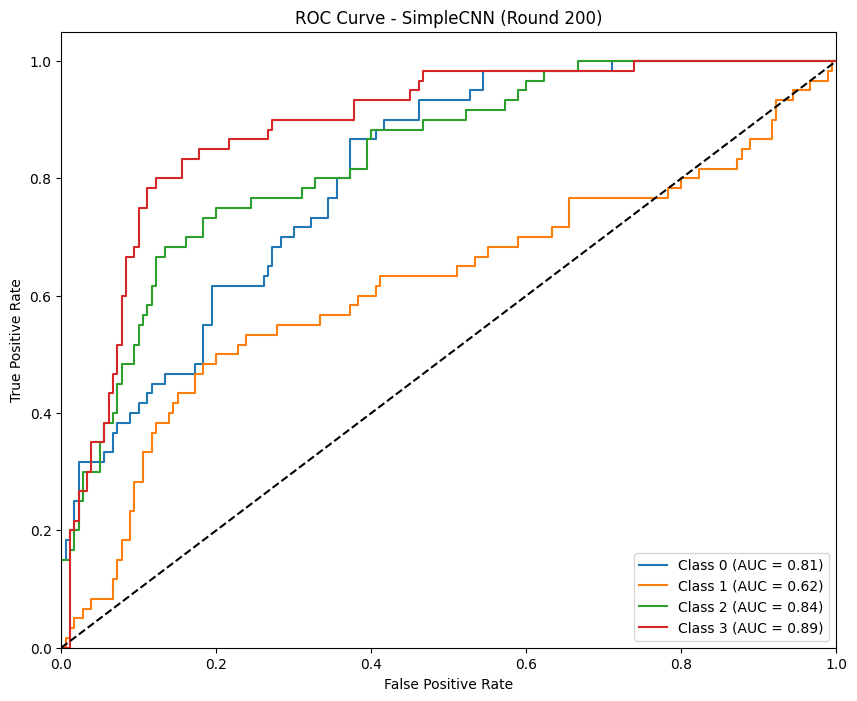

8/8 [==============================] - 0s 59ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 57.083% | Loss: 1.2578 | Precision: 54.908% | Recall: 57.083% | F1: 55.249% | AUC: 78.755%


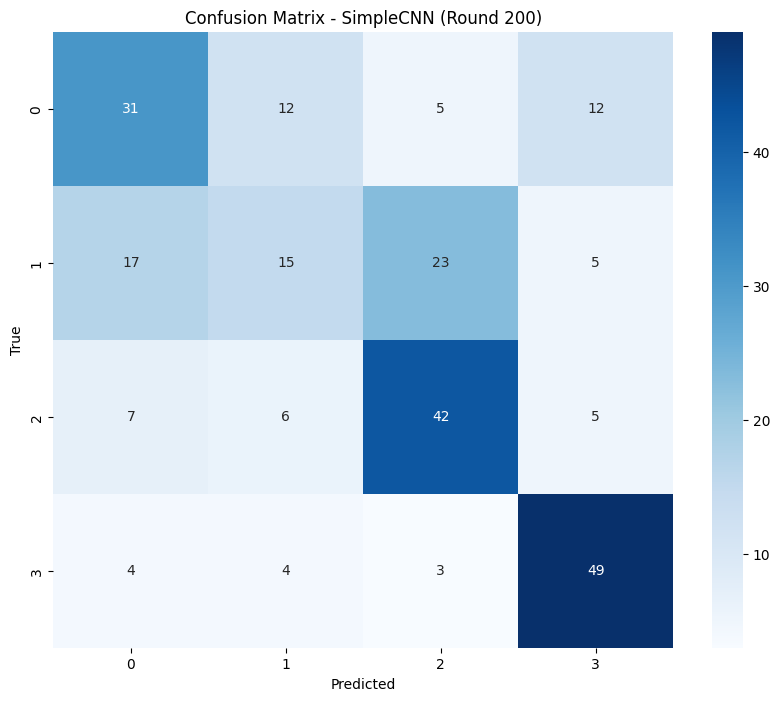

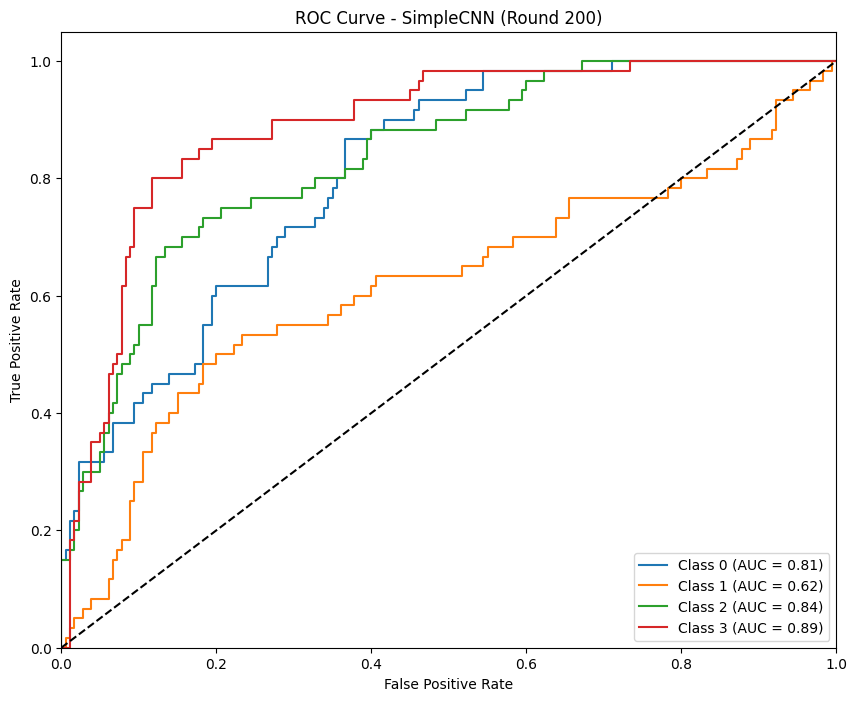

8/8 [==============================] - 1s 61ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 57.917% | Loss: 1.2528 | Precision: 56.205% | Recall: 57.917% | F1: 56.453% | AUC: 79.097%


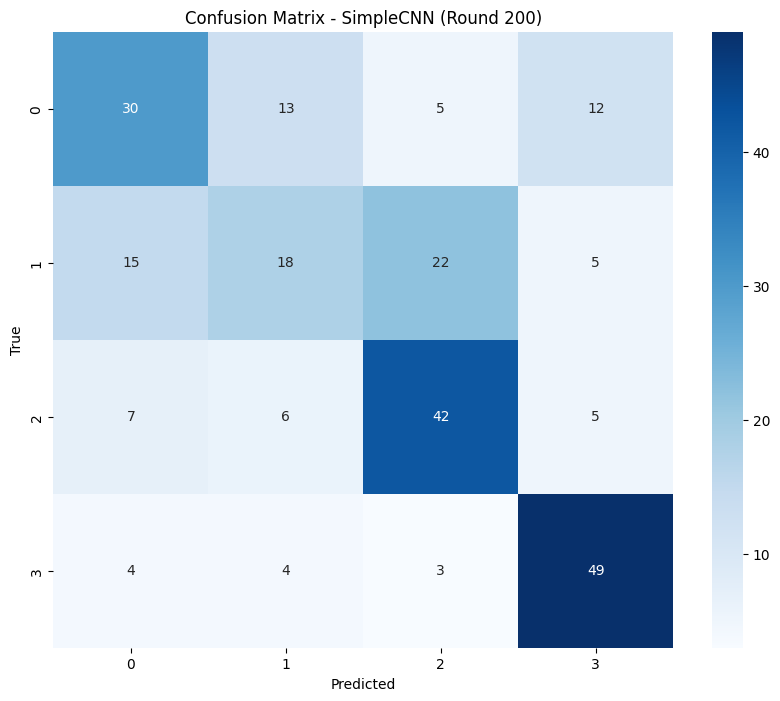

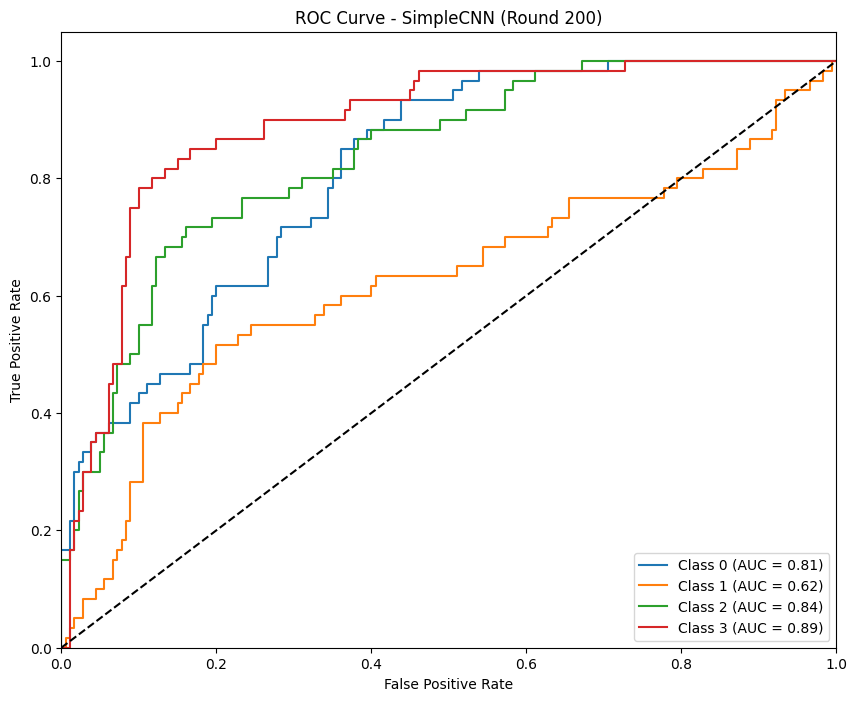

8/8 [==============================] - 0s 61ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 57.917% | Loss: 1.2434 | Precision: 56.217% | Recall: 57.917% | F1: 56.487% | AUC: 79.766%


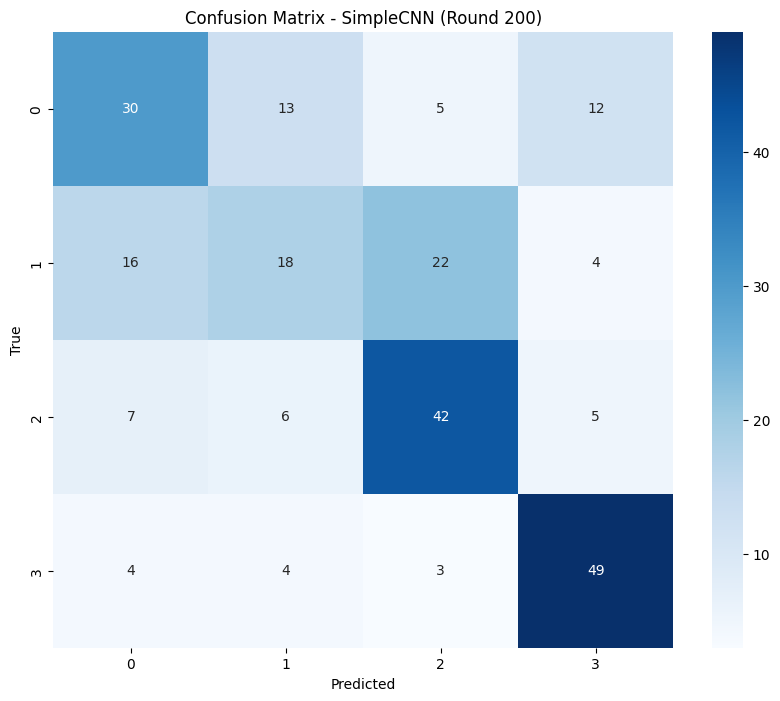

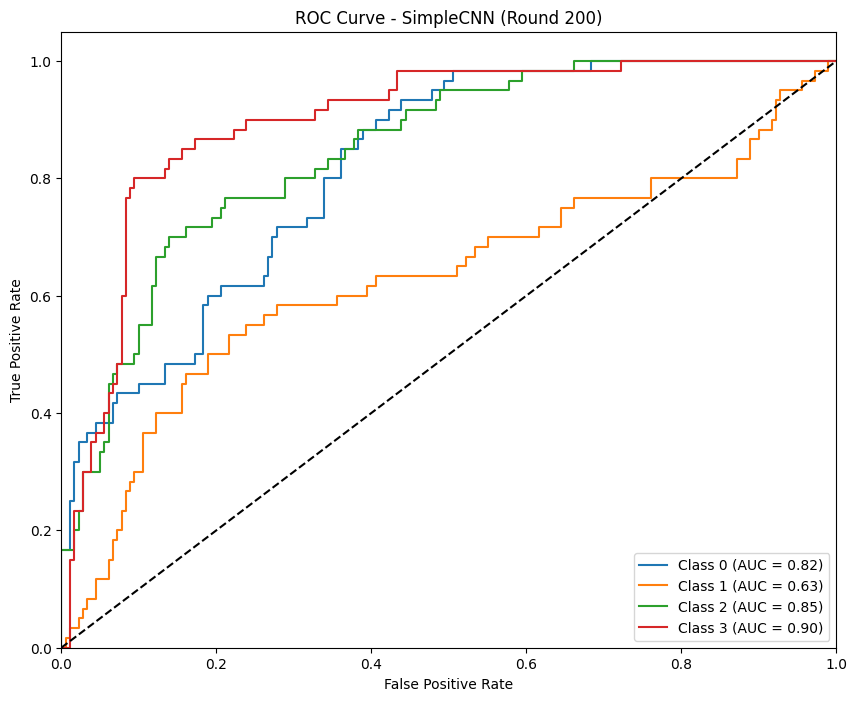

8/8 [==============================] - 0s 61ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 58.333% | Loss: 1.2419 | Precision: 56.695% | Recall: 58.333% | F1: 56.891% | AUC: 79.954%


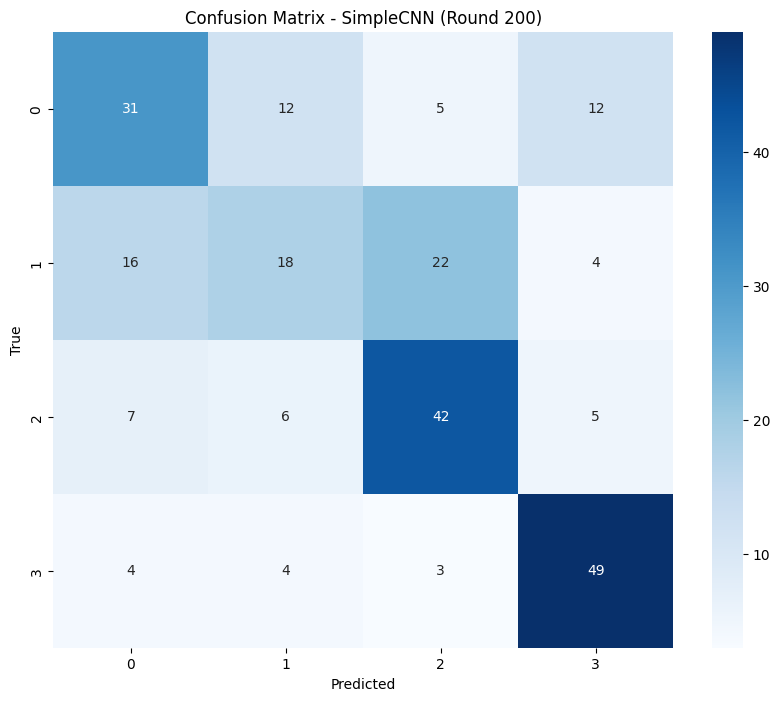

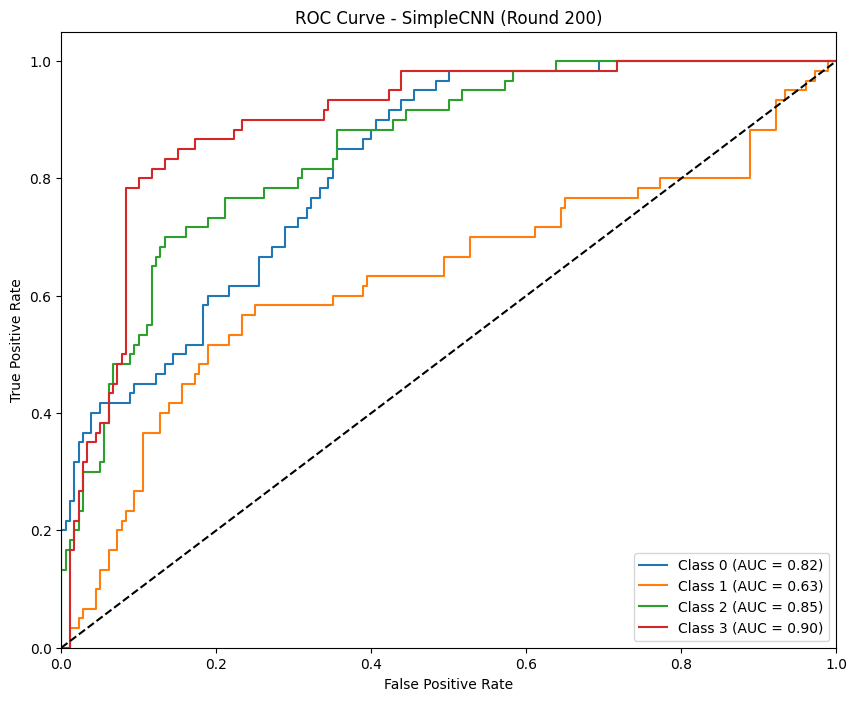

8/8 [==============================] - 1s 64ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 60.417% | Loss: 1.2362 | Precision: 59.334% | Recall: 60.417% | F1: 59.376% | AUC: 80.301%


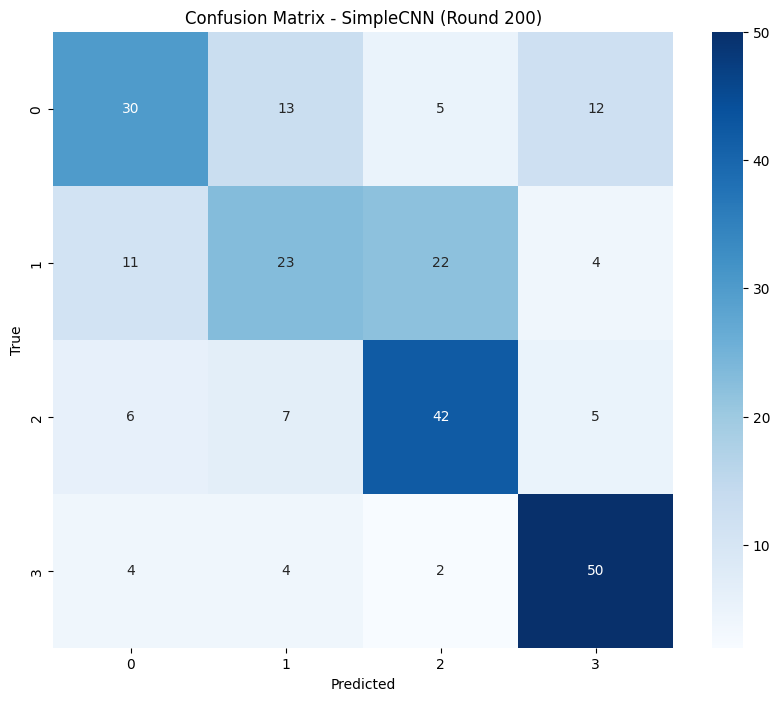

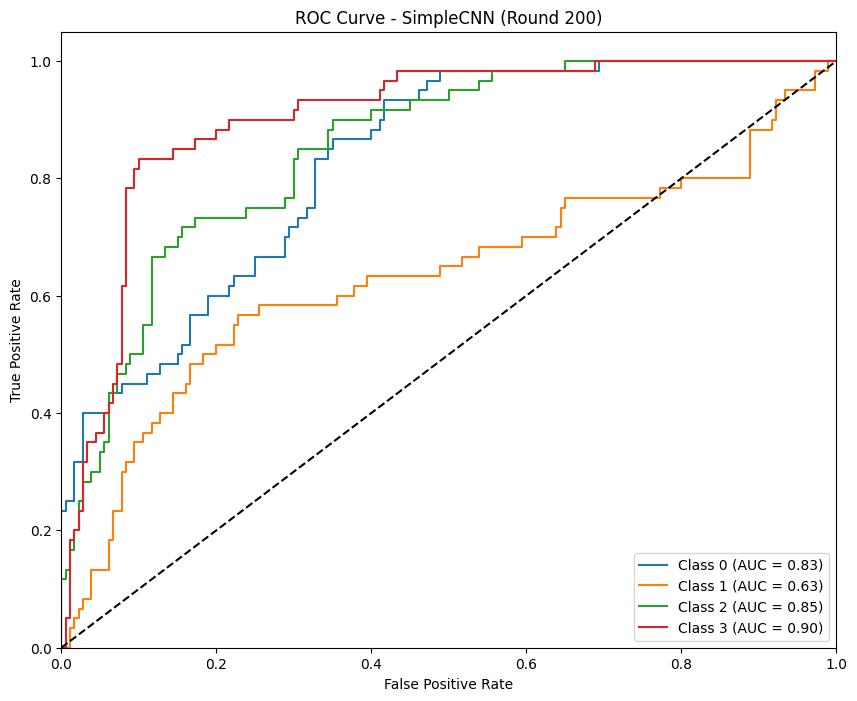

8/8 [==============================] - 1s 88ms/step

Model: SimpleCNN | DP Params: {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1} | Clients: 2 | Round: 200

Accuracy: 62.500% | Loss: 1.2316 | Precision: 62.951% | Recall: 62.500% | F1: 61.970% | AUC: 80.650%


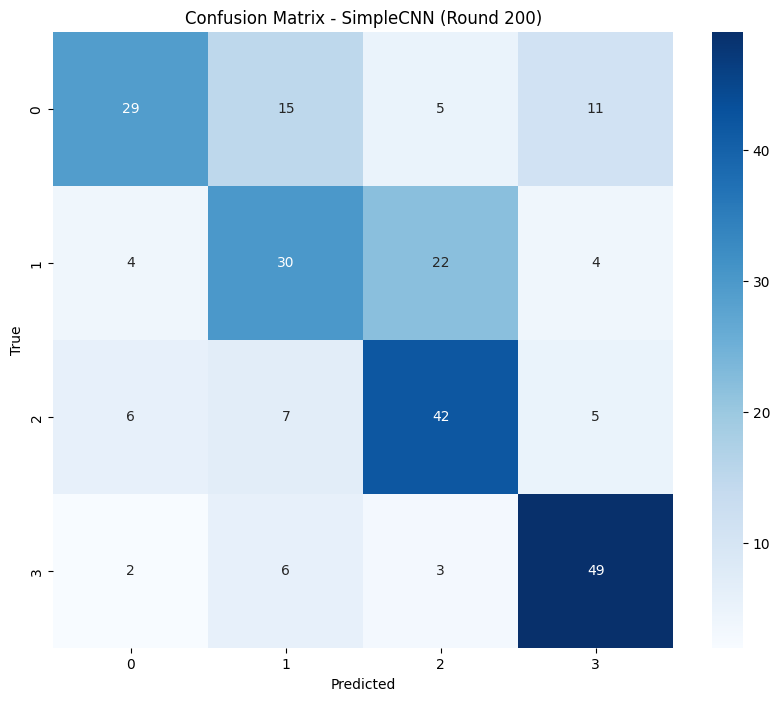

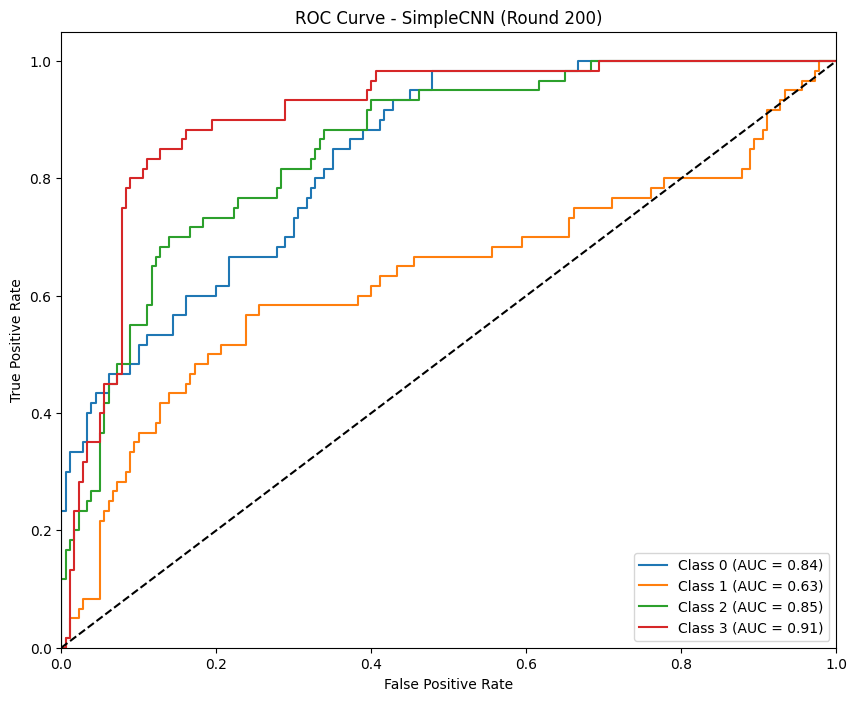

In [ ]:
dp_param_list = [
                 {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1},
                 {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1},
                 {'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1}
                 ]

dp_results = []
comms_round = [100,200]
epochs=[50,100,200]
num_clients = len(clients) # Get the number of clients

for comm_round in comms_round: # Iterate directly over the list
  for dp_params in dp_param_list:
    for epoch in epochs: # Iterate directly over the list
      global_weights = global_model.get_weights()
      scaled_local_weight_list = []
      for client in clients.keys(): # Iterate over clients
        local_model = SimpleCNN.build(input_shape, num_classes) # Now correctly indented
        # !pip install tensorflow_privacy # Install if not already installed
        from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
        dp_optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=dp_params['l2_norm_clip'], # Use dp_params here
            noise_multiplier=dp_params['noise_multiplier'],
            num_microbatches=dp_params['num_microbatches'],
            learning_rate=0.0001  # Reduce learning rate
        )
        local_model.compile(loss='categorical_crossentropy',
                            optimizer=dp_optimizer,
                            metrics=['accuracy'])
        local_model.set_weights(global_weights)

        local_data = clients_batched[client]

        # Increase the number of epochs
        local_model.fit(local_data, epochs=epoch, verbose=0) # Use epoch here, not epochs

        scaling_factor = weight_scaling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

      average_weights = sum_scaled_weights(scaled_local_weight_list) # Dedent to be outside the client loop
      global_model.set_weights(average_weights)

      # Test the global model and generate reports
      for (X_test, Y_test) in test_batched:
          # Pass the missing arguments to test_model
          acc, loss, prec, rec, f1, auc = test_model(X_test, Y_test, global_model, 'SimpleCNN', dp_params, num_clients, comm_round)
          dp_results.append((acc, loss, prec, rec, f1, auc))

# Testing the above code with Pretrained models and data augmentation with tensoflow DP

# Accuracy is low due to the dp parameters, also data needs to be processed properly

# Federated learning with differential privacy after editing the dataset preprocessing functions

In [2]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
import itertools
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer
from tensorflow_privacy.privacy.analysis import compute_noise_from_budget

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import Callback, TerminateOnNaN, ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import Xception
img_size = (224, 224)
batch_size=32

2024-09-04 17:54:08.088618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 17:54:08.088706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 17:54:08.091405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def generate_train_paths_and_labels(data_dir, is_test=False):
    """
    Generate file paths and labels from the specified data directory.
    
    Parameters:
    - data_dir (str): Directory containing the dataset.
    - is_test (bool): If True, generate paths for test data, else for training data.
    
    Returns:
    - pd.DataFrame: A DataFrame containing file paths and corresponding labels.
    """
    filepaths = []
    labels = []
    
    # List all folders (e.g., class labels) in the data directory
    folds = os.listdir(data_dir)
    
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    
    # Create a DataFrame with file paths and labels
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    train_df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

Loading and generating data

In [ ]:
# Generate test and train data paths with labels
# Example usage
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

train_df = generate_data_paths_and_labels(train_data_dir, is_test=False)
test_df = generate_data_paths_and_labels(test_data_dir, is_test=True)filepaths = []

In [ ]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 48)

In [40]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

test_gen = ts_gen.flow_from_dataframe(
            test_df, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Class information
class_names = sorted(train_df['labels'].unique())
num_classes = len(class_names)
class_indices = {label: idx for idx, label in enumerate(class_names)}

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
# 3. Compile with appropriate loss and metrics


Found 656 validated image filenames belonging to 4 classes.
Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Class information
class_names = sorted(train_df['labels'].unique())
num_classes = len(class_names)
class_indices = {label: idx for idx, label in enumerate(class_names)}

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
# 3. Compile with appropriate loss and metrics

In [ ]:

#creation of pretrained models            
def create_efficientB3_model(img_shape,class_count):
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", 
    input_tensor=None, input_shape=img_shape, pooling='max')
    
    base_model.trainable = False  # Freeze base model initially

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(0.016),
              activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation='softmax')
    ])
    return model

def create_xception_model(img_shape,class_count):
    base_model =Xception(input_shape=img_shape, include_top=False, weights='imagenet',
                                            pooling= 'max')

    model = Sequential([
        base_model,
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(class_count, activation='softmax')
    ])
    
    return model

def create_densenet_model(img_shape, class_count):
    base_model = DenseNet121(include_top=False, weights="imagenet", 
                             input_tensor=None, input_shape=img_shape, pooling='max')
    
    base_model.trainable = False  # Freeze base model initially

    model = Sequential([
        base_model,
        BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
        Dense(256, kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(class_count, activation='softmax')
    ])
    
    return model


In [ ]:
def select_model(model_name):
    img_size = (224, 224)
    channels=3
    img_shape = (img_size[0], img_size[1], channels)
    
    class_count = len(class_names)
    
    if model = 'efficient':
        model = create_effiecientB3_model(img_shape,class_count)
    elif model = 'xception':
        model = create_xception_model(img_shape,class_count)
    elif model = 'densenet':
        model = create_densenet_model(img_shape,class_count)
    else:
        print("Name is not defined")
    model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# Training on client

# Define the function for training on a client
def train_on_client(model, client_data_gen, client_test_gen, client_val_gen, epochs=1, l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier, num_microbatches=num_microbatches):
    try:
        # Clone the model
       # model_copy = tf.keras.models.clone_model(model)
        model.set_weight= model.get_weights()

        # Ensure the microbatch configuration is correct
        if batch_size % num_microbatches != 0:
            raise ValueError(f"num_microbatches ({num_microbatches}) must divide batch_size ({batch_size}) evenly.")

        # Use DPAdam optimizer from TensorFlow Privacy
        initial_learning_rate = 0.001
        lr_schedule = ExponentialDecay(
            initial_learning_rate,
            decay_steps=100,
            decay_rate=0.96,
            staircase=True)
        
        optimizer = DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=lr_schedule
        )

        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model.build(input_shape=(None, *img_shape))

        # Debugging information about the client generator
        print(f"Client generator length: {len(client_data_gen)}")

        # Print model input shape
        print(f"Model input shape: {model.input_shape}")

        # Train the model on the client data
        history = model.fit(client_data_gen,
                                 epochs=epochs,
                                 validation_data=client_val_gen,
                                 callbacks=[checkpoint, reduce_lr],
                                 shuffle= False,
                                 verbose=1)

        # Evaluate the model on the client's test data
        test_loss, test_accuracy = model.evaluate(client_test_gen)
        print(f"Final test accuracy: {test_accuracy:.4f}")
        print(f"DP parameters l2_norm_clip=: {l2_norm_clip}")


        return model.get_weights()

    except ValueError as ve:
        print(f"ValueError during training on client: {str(ve)}")
        return None

    except Exception as e:
        print(f"Exception during training on client: {str(e)}")
        return None

# Define the federated averaging function
def federated_averaging(client_weights):
    avg_weights = [np.mean([client_weights[i][j] for i in range(len(client_weights))], axis=0)
                   for j in range(len(client_weights[0]))]
    return avg_weights



In [ ]:
# Simulate federated learning
def simulate_federated_learning(model, num_rounds, num_clients, epochs_per_client, l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier, num_microbatches=1):
    # Initialize data generators for all clients once
    client_generators = []
    for i in range(num_clients):
        print(f"Initializing data generators for client {i + 1}")

        client_train_sample = train_df.sample(frac=1/num_clients, replace=False)
        client_test_sample = test_df.sample(frac=1/num_clients, replace=False)
        client_val_sample = valid_df.sample(frac=1/num_clients, replace=False)

        client_data_gen = tr_gen.flow_from_dataframe(
            client_train_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_val_gen = ts_gen.flow_from_dataframe(
            client_val_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_test_gen = ts_gen.flow_from_dataframe(
            client_test_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
        )

        client_generators.append((client_data_gen, client_test_gen, client_val_gen))

    # Start federated learning rounds
    for round_num in range(num_rounds):
        print(f"\nStarting round {round_num + 1}")
        client_weights = []

        for i, (client_data_gen, client_test_gen, client_val_gen) in enumerate(client_generators):
            print(f"Training client {i + 1}")

            client_result = train_on_client(
                model, client_data_gen, client_test_gen, client_val_gen, 
                epochs=epochs_per_client, l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier, num_microbatches=num_microbatches
            )

            if client_result is not None:
                client_weights.append(client_result)
                print(f"Client {i + 1} training completed successfully")
            else:
                print(f"Client {i + 1} training failed")

        if client_weights:
            # Perform federated averaging and update the global model
            new_weights = federated_averaging(client_weights)
            
            model.set_weights(new_weights)
        else:
            print("No successful client training in this round. Skipping federated averaging.")
        
        
        # Print model summary after each round
    
        print("\nModel summary after round:")
        model.summary()
        print("\nEvaluating the final model")
        test_loss, test_accuracy = model.evaluate(test_gen)
        print(f"Final test accuracy: {test_accuracy:.4f}")
        # Generate predictions for performance metrics
        y_pred = model.predict(test_gen) # Fixed indentation
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.array([class_indices[label] for label in test_df['labels']])
        # Ensure y_pred_classes and y_true have the same length
        min_length = min(len(y_pred_classes), len(y_true))
        y_pred_classes = y_pred_classes[:min_length]
        y_true = y_true[:min_length]

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)

        # Compute classification report
        cr = classification_report(y_true, y_pred_classes, target_names=class_names)
        print("\nClassification Report:\n", cr)

In [23]:

# Parameters
num_rounds = 10
num_clients = 5
epochs_per_client = 1
l2_norm_clip = 0.01
noise_multiplier = 0.01
num_microbatches = 1 
model_name= 'efficient'
model = select_model(model_name)
# Assuming 'model' is your initialized model, and 'train_df', 'test_df', 'valid_df', 'tr_gen', 'ts_gen', 'img_size', 'batch_size' are already defined

# Run the simulation
simulate_federated_learning(model, num_rounds, num_clients, epochs_per_client, l2_norm_clip, noise_multiplier, num_microbatches)

Found 656 validated image filenames belonging to 4 classes.
Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Initializing data generators for client 1
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Initializing data generators for client 2
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Initializing data generators for client 3
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Initializing data generators for client 4
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image

2024-09-03 16:03:09.739853: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 179ms/step - loss: 14.6186 - accuracy: 0.2285 - val_loss: 14.2438 - val_accuracy: 0.2901
Epoch 2/50
36/36 [==============================] - 4s 96ms/step - loss: 14.3898 - accuracy: 0.2715 - val_loss: 13.1686 - val_accuracy: 0.3282
Epoch 3/50
36/36 [==============================] - 4s 102ms/step - loss: 14.0828 - accuracy: 0.2820 - val_loss: 11.6922 - val_accuracy: 0.3664
Epoch 4/50
36/36 [==============================] - 4s 97ms/step - loss: 13.2644 - accuracy: 0.3161 - val_loss: 10.6844 - val_accuracy: 0.4427
Epoch 5/50
36/36 [==============================] - 3s 95ms/step - loss: 12.9490 - accuracy: 0.3433 - val_loss: 10.3336 - val_accuracy: 0.5038
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 12.1867 - accuracy: 0.4107 - val_loss: 10.2198 - val_accuracy: 0.5649
Epoch 7/50
36/36 [==============================] - 3s 94ms/step - loss: 11.7710 - accuracy: 0.4352 - val_loss: 10.2791 - val_accuracy: 0.6183
Epoch 8

2024-09-03 16:06:29.820507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 17s 165ms/step - loss: 12.5203 - accuracy: 0.4869 - val_loss: 11.7949 - val_accuracy: 0.4656
Epoch 2/50
36/36 [==============================] - 4s 97ms/step - loss: 12.8160 - accuracy: 0.4510 - val_loss: 12.1250 - val_accuracy: 0.4809
Epoch 3/50
36/36 [==============================] - 3s 95ms/step - loss: 12.6522 - accuracy: 0.4615 - val_loss: 12.3636 - val_accuracy: 0.4656
Epoch 4/50
36/36 [==============================] - 4s 96ms/step - loss: 12.5454 - accuracy: 0.4361 - val_loss: 12.3991 - val_accuracy: 0.4504
Epoch 5/50
36/36 [==============================] - 4s 100ms/step - loss: 12.6960 - accuracy: 0.4457 - val_loss: 12.6573 - val_accuracy: 0.4809
Epoch 6/50
36/36 [==============================] - 4s 106ms/step - loss: 12.5615 - accuracy: 0.4475 - val_loss: 12.3069 - val_accuracy: 0.4885
Epoch 7/50
36/36 [==============================] - 4s 109ms/step - loss: 12.5307 - accuracy: 0.4063 - val_loss: 11.6547 - val_accuracy: 0.4885
Epoch

2024-09-03 16:09:49.705894: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 175ms/step - loss: 12.9326 - accuracy: 0.2995 - val_loss: 12.1449 - val_accuracy: 0.2595
Epoch 2/50
36/36 [==============================] - 4s 104ms/step - loss: 12.9640 - accuracy: 0.3109 - val_loss: 12.1651 - val_accuracy: 0.2672
Epoch 3/50
36/36 [==============================] - 4s 107ms/step - loss: 12.5915 - accuracy: 0.3082 - val_loss: 11.6856 - val_accuracy: 0.2901
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 12.2517 - accuracy: 0.3573 - val_loss: 11.6956 - val_accuracy: 0.2901
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 12.5754 - accuracy: 0.3222 - val_loss: 11.4140 - val_accuracy: 0.3130
Epoch 6/50
36/36 [==============================] - 4s 99ms/step - loss: 12.4068 - accuracy: 0.3625 - val_loss: 11.2195 - val_accuracy: 0.3435
Epoch 7/50
36/36 [==============================] - 4s 99ms/step - loss: 12.3182 - accuracy: 0.3730 - val_loss: 10.8141 - val_accuracy: 0.3740
Epoch

2024-09-03 16:13:05.985053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 183ms/step - loss: 10.7884 - accuracy: 0.4658 - val_loss: 10.1216 - val_accuracy: 0.4504
Epoch 2/50
36/36 [==============================] - 4s 106ms/step - loss: 10.5688 - accuracy: 0.4720 - val_loss: 10.0128 - val_accuracy: 0.4351
Epoch 3/50
36/36 [==============================] - 4s 97ms/step - loss: 10.7968 - accuracy: 0.4562 - val_loss: 10.3464 - val_accuracy: 0.4275
Epoch 4/50
36/36 [==============================] - 4s 103ms/step - loss: 11.4893 - accuracy: 0.4282 - val_loss: 10.9143 - val_accuracy: 0.4122
Epoch 5/50
36/36 [==============================] - 3s 94ms/step - loss: 11.5441 - accuracy: 0.4343 - val_loss: 11.5843 - val_accuracy: 0.4046
Epoch 6/50
36/36 [==============================] - 4s 95ms/step - loss: 11.5215 - accuracy: 0.4387 - val_loss: 11.8793 - val_accuracy: 0.3969
Epoch 7/50
36/36 [==============================] - 3s 95ms/step - loss: 11.6412 - accuracy: 0.4142 - val_loss: 11.5574 - val_accuracy: 0.3817
Epoch 

2024-09-03 16:16:23.881617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 192ms/step - loss: 10.0842 - accuracy: 0.5368 - val_loss: 9.5638 - val_accuracy: 0.5878
Epoch 2/50
36/36 [==============================] - 4s 103ms/step - loss: 9.8049 - accuracy: 0.5018 - val_loss: 9.0257 - val_accuracy: 0.6031
Epoch 3/50
36/36 [==============================] - 4s 108ms/step - loss: 9.5896 - accuracy: 0.5175 - val_loss: 8.9019 - val_accuracy: 0.5802
Epoch 4/50
36/36 [==============================] - 4s 104ms/step - loss: 9.5113 - accuracy: 0.5114 - val_loss: 8.6720 - val_accuracy: 0.5496
Epoch 5/50
36/36 [==============================] - 4s 105ms/step - loss: 9.6770 - accuracy: 0.4912 - val_loss: 8.3213 - val_accuracy: 0.5115
Epoch 6/50
36/36 [==============================] - 4s 106ms/step - loss: 9.1916 - accuracy: 0.4720 - val_loss: 7.7862 - val_accuracy: 0.4656
Epoch 7/50
36/36 [==============================] - 4s 114ms/step - loss: 9.3844 - accuracy: 0.4685 - val_loss: 7.7237 - val_accuracy: 0.4809
Epoch 8/50
36/3

2024-09-03 16:20:00.845685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 17s 173ms/step - loss: 10.5481 - accuracy: 0.4685 - val_loss: 9.5143 - val_accuracy: 0.5573
Epoch 2/50
36/36 [==============================] - 4s 104ms/step - loss: 10.7713 - accuracy: 0.4842 - val_loss: 9.5661 - val_accuracy: 0.5649
Epoch 3/50
36/36 [==============================] - 4s 105ms/step - loss: 10.9800 - accuracy: 0.4440 - val_loss: 9.9401 - val_accuracy: 0.5344
Epoch 4/50
36/36 [==============================] - 4s 104ms/step - loss: 11.1659 - accuracy: 0.4527 - val_loss: 10.0485 - val_accuracy: 0.5496
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 10.8381 - accuracy: 0.4247 - val_loss: 10.4893 - val_accuracy: 0.5191
Epoch 6/50
36/36 [==============================] - 4s 104ms/step - loss: 10.5616 - accuracy: 0.4107 - val_loss: 10.5231 - val_accuracy: 0.4962
Epoch 7/50
36/36 [==============================] - 4s 108ms/step - loss: 11.1129 - accuracy: 0.4247 - val_loss: 10.2164 - val_accuracy: 0.4809
Epoch

2024-09-03 16:23:26.759259: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 174ms/step - loss: 10.2804 - accuracy: 0.4326 - val_loss: 9.0509 - val_accuracy: 0.4580
Epoch 2/50
36/36 [==============================] - 4s 105ms/step - loss: 10.5770 - accuracy: 0.4019 - val_loss: 9.3727 - val_accuracy: 0.4427
Epoch 3/50
36/36 [==============================] - 4s 102ms/step - loss: 10.7304 - accuracy: 0.4291 - val_loss: 9.6522 - val_accuracy: 0.4580
Epoch 4/50
36/36 [==============================] - 4s 113ms/step - loss: 10.3707 - accuracy: 0.4370 - val_loss: 9.8619 - val_accuracy: 0.4504
Epoch 5/50
36/36 [==============================] - 4s 108ms/step - loss: 10.6476 - accuracy: 0.4221 - val_loss: 9.9120 - val_accuracy: 0.4427
Epoch 6/50
36/36 [==============================] - 4s 110ms/step - loss: 10.4316 - accuracy: 0.4335 - val_loss: 10.6991 - val_accuracy: 0.4504
Epoch 7/50
36/36 [==============================] - 4s 109ms/step - loss: 10.5509 - accuracy: 0.4396 - val_loss: 10.5873 - val_accuracy: 0.4504
Epoch 8

2024-09-03 16:26:55.259076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 182ms/step - loss: 9.9185 - accuracy: 0.4580 - val_loss: 9.2459 - val_accuracy: 0.5420
Epoch 2/50
36/36 [==============================] - 4s 104ms/step - loss: 9.9857 - accuracy: 0.4545 - val_loss: 9.3380 - val_accuracy: 0.5344
Epoch 3/50
36/36 [==============================] - 4s 98ms/step - loss: 10.4582 - accuracy: 0.4194 - val_loss: 9.1657 - val_accuracy: 0.5267
Epoch 4/50
36/36 [==============================] - 4s 97ms/step - loss: 10.2370 - accuracy: 0.4186 - val_loss: 8.8828 - val_accuracy: 0.5267
Epoch 5/50
36/36 [==============================] - 4s 106ms/step - loss: 10.4790 - accuracy: 0.4212 - val_loss: 9.0288 - val_accuracy: 0.5267
Epoch 6/50
36/36 [==============================] - 4s 102ms/step - loss: 10.1580 - accuracy: 0.4475 - val_loss: 8.7088 - val_accuracy: 0.5267
Epoch 7/50
36/36 [==============================] - 4s 98ms/step - loss: 10.3469 - accuracy: 0.4194 - val_loss: 9.2357 - val_accuracy: 0.5191
Epoch 8/50
36/

2024-09-03 16:30:19.330244: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 177ms/step - loss: 9.9524 - accuracy: 0.4247 - val_loss: 9.2034 - val_accuracy: 0.4962
Epoch 2/50
36/36 [==============================] - 4s 100ms/step - loss: 10.2400 - accuracy: 0.4212 - val_loss: 9.1812 - val_accuracy: 0.4885
Epoch 3/50
36/36 [==============================] - 4s 97ms/step - loss: 9.6707 - accuracy: 0.4037 - val_loss: 9.2299 - val_accuracy: 0.4885
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 10.0702 - accuracy: 0.4413 - val_loss: 8.9819 - val_accuracy: 0.4962
Epoch 5/50
36/36 [==============================] - 4s 100ms/step - loss: 9.5211 - accuracy: 0.4335 - val_loss: 8.8983 - val_accuracy: 0.4885
Epoch 6/50
36/36 [==============================] - 4s 102ms/step - loss: 9.8966 - accuracy: 0.4317 - val_loss: 8.9952 - val_accuracy: 0.4885
Epoch 7/50
36/36 [==============================] - 4s 105ms/step - loss: 9.9570 - accuracy: 0.4413 - val_loss: 9.4378 - val_accuracy: 0.4809
Epoch 8/50
36/3

2024-09-03 16:33:40.815904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 182ms/step - loss: 9.7598 - accuracy: 0.4440 - val_loss: 8.6319 - val_accuracy: 0.4733
Epoch 2/50
36/36 [==============================] - 4s 104ms/step - loss: 9.7602 - accuracy: 0.4203 - val_loss: 9.0378 - val_accuracy: 0.4809
Epoch 3/50
36/36 [==============================] - 4s 99ms/step - loss: 10.2103 - accuracy: 0.4203 - val_loss: 9.2977 - val_accuracy: 0.4733
Epoch 4/50
36/36 [==============================] - 4s 107ms/step - loss: 10.0275 - accuracy: 0.4238 - val_loss: 9.8153 - val_accuracy: 0.4809
Epoch 5/50
36/36 [==============================] - 4s 107ms/step - loss: 10.1302 - accuracy: 0.4168 - val_loss: 9.4839 - val_accuracy: 0.4962
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 9.7133 - accuracy: 0.4212 - val_loss: 9.3735 - val_accuracy: 0.4885
Epoch 7/50
36/36 [==============================] - 4s 96ms/step - loss: 9.7557 - accuracy: 0.4457 - val_loss: 9.1895 - val_accuracy: 0.5038
Epoch 8/50
36/3

2024-09-03 16:37:08.273733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 182ms/step - loss: 9.5224 - accuracy: 0.4650 - val_loss: 8.4995 - val_accuracy: 0.6107
Epoch 2/50
36/36 [==============================] - 4s 101ms/step - loss: 9.5168 - accuracy: 0.4851 - val_loss: 8.9499 - val_accuracy: 0.5802
Epoch 3/50
36/36 [==============================] - 4s 100ms/step - loss: 9.0714 - accuracy: 0.4641 - val_loss: 8.5685 - val_accuracy: 0.5725
Epoch 4/50
36/36 [==============================] - 4s 101ms/step - loss: 9.9037 - accuracy: 0.4352 - val_loss: 8.7634 - val_accuracy: 0.5725
Epoch 5/50
36/36 [==============================] - 4s 100ms/step - loss: 9.6097 - accuracy: 0.4527 - val_loss: 8.8665 - val_accuracy: 0.5725
Epoch 6/50
36/36 [==============================] - 4s 98ms/step - loss: 10.1523 - accuracy: 0.4326 - val_loss: 9.1456 - val_accuracy: 0.5573
Epoch 7/50
36/36 [==============================] - 4s 101ms/step - loss: 9.8282 - accuracy: 0.4510 - val_loss: 9.2886 - val_accuracy: 0.5420
Epoch 8/50
36/36

2024-09-03 16:40:32.382997: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 181ms/step - loss: 9.5999 - accuracy: 0.4518 - val_loss: 9.6030 - val_accuracy: 0.5191
Epoch 2/50
36/36 [==============================] - 4s 98ms/step - loss: 9.4491 - accuracy: 0.4974 - val_loss: 9.7018 - val_accuracy: 0.5191
Epoch 3/50
36/36 [==============================] - 4s 103ms/step - loss: 9.6788 - accuracy: 0.4623 - val_loss: 9.4870 - val_accuracy: 0.4809
Epoch 4/50
36/36 [==============================] - 4s 104ms/step - loss: 9.6065 - accuracy: 0.4580 - val_loss: 9.3690 - val_accuracy: 0.4809
Epoch 5/50
36/36 [==============================] - 4s 104ms/step - loss: 9.6146 - accuracy: 0.4580 - val_loss: 8.8539 - val_accuracy: 0.4504
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 9.5591 - accuracy: 0.4466 - val_loss: 8.4589 - val_accuracy: 0.4427
Epoch 7/50
36/36 [==============================] - 4s 105ms/step - loss: 9.1962 - accuracy: 0.4781 - val_loss: 8.8556 - val_accuracy: 0.4733
Epoch 8/50
36/36 

2024-09-03 16:43:57.769316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 19s 204ms/step - loss: 9.1403 - accuracy: 0.5026 - val_loss: 9.2223 - val_accuracy: 0.6870
Epoch 2/50
36/36 [==============================] - 4s 102ms/step - loss: 8.8549 - accuracy: 0.4974 - val_loss: 9.4774 - val_accuracy: 0.6870
Epoch 3/50
36/36 [==============================] - 4s 104ms/step - loss: 8.7425 - accuracy: 0.4965 - val_loss: 9.1558 - val_accuracy: 0.6947
Epoch 4/50
36/36 [==============================] - 4s 105ms/step - loss: 9.1318 - accuracy: 0.5009 - val_loss: 8.9856 - val_accuracy: 0.6641
Epoch 5/50
36/36 [==============================] - 4s 102ms/step - loss: 8.7589 - accuracy: 0.5105 - val_loss: 9.1381 - val_accuracy: 0.6565
Epoch 6/50
36/36 [==============================] - 4s 104ms/step - loss: 9.0304 - accuracy: 0.4904 - val_loss: 8.8058 - val_accuracy: 0.6565
Epoch 7/50
36/36 [==============================] - 4s 103ms/step - loss: 8.6619 - accuracy: 0.5123 - val_loss: 9.0532 - val_accuracy: 0.6565
Epoch 8/50
36/36

2024-09-03 16:47:25.297194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 182ms/step - loss: 8.4588 - accuracy: 0.5736 - val_loss: 7.9679 - val_accuracy: 0.5954
Epoch 2/50
36/36 [==============================] - 4s 95ms/step - loss: 8.5290 - accuracy: 0.5806 - val_loss: 8.3701 - val_accuracy: 0.6183
Epoch 3/50
36/36 [==============================] - 4s 97ms/step - loss: 8.2444 - accuracy: 0.6016 - val_loss: 8.1294 - val_accuracy: 0.6183
Epoch 4/50
36/36 [==============================] - 4s 96ms/step - loss: 8.3246 - accuracy: 0.5797 - val_loss: 8.1336 - val_accuracy: 0.6031
Epoch 5/50
36/36 [==============================] - 4s 100ms/step - loss: 8.3143 - accuracy: 0.5823 - val_loss: 7.7390 - val_accuracy: 0.5954
Epoch 6/50
36/36 [==============================] - 4s 99ms/step - loss: 8.2823 - accuracy: 0.5788 - val_loss: 7.9602 - val_accuracy: 0.6031
Epoch 7/50
36/36 [==============================] - 4s 102ms/step - loss: 8.1636 - accuracy: 0.5841 - val_loss: 7.8458 - val_accuracy: 0.6031
Epoch 8/50
36/36 [==

2024-09-03 16:50:42.903326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 181ms/step - loss: 8.5738 - accuracy: 0.5543 - val_loss: 7.6164 - val_accuracy: 0.6183
Epoch 2/50
36/36 [==============================] - 4s 97ms/step - loss: 8.5009 - accuracy: 0.5368 - val_loss: 7.6050 - val_accuracy: 0.5878
Epoch 3/50
36/36 [==============================] - 4s 101ms/step - loss: 8.5941 - accuracy: 0.5368 - val_loss: 7.7133 - val_accuracy: 0.6107
Epoch 4/50
36/36 [==============================] - 4s 103ms/step - loss: 8.6883 - accuracy: 0.5210 - val_loss: 7.7446 - val_accuracy: 0.6183
Epoch 5/50
36/36 [==============================] - 4s 96ms/step - loss: 8.5064 - accuracy: 0.5236 - val_loss: 7.0964 - val_accuracy: 0.5954
Epoch 6/50
36/36 [==============================] - 4s 98ms/step - loss: 8.7108 - accuracy: 0.5245 - val_loss: 7.1838 - val_accuracy: 0.5954
Epoch 7/50
36/36 [==============================] - 4s 99ms/step - loss: 8.6189 - accuracy: 0.5342 - val_loss: 7.5819 - val_accuracy: 0.6107
Epoch 8/50
36/36 [==

2024-09-03 16:54:15.548230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 27s 185ms/step - loss: 8.0987 - accuracy: 0.5884 - val_loss: 7.5487 - val_accuracy: 0.7099
Epoch 2/50
36/36 [==============================] - 4s 100ms/step - loss: 8.1715 - accuracy: 0.5771 - val_loss: 7.2848 - val_accuracy: 0.6870
Epoch 3/50
36/36 [==============================] - 4s 105ms/step - loss: 8.5733 - accuracy: 0.5543 - val_loss: 7.4287 - val_accuracy: 0.6107
Epoch 4/50
36/36 [==============================] - 4s 103ms/step - loss: 8.1455 - accuracy: 0.5368 - val_loss: 7.4510 - val_accuracy: 0.6107
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 8.2674 - accuracy: 0.5517 - val_loss: 7.7085 - val_accuracy: 0.6183
Epoch 6/50
36/36 [==============================] - 4s 102ms/step - loss: 8.5633 - accuracy: 0.5692 - val_loss: 7.8115 - val_accuracy: 0.6107
Epoch 7/50
36/36 [==============================] - 4s 109ms/step - loss: 8.2697 - accuracy: 0.5534 - val_loss: 8.2632 - val_accuracy: 0.5878
Epoch 8/50
36/36 

2024-09-03 16:57:37.802487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 188ms/step - loss: 9.0132 - accuracy: 0.4790 - val_loss: 8.1501 - val_accuracy: 0.5573
Epoch 2/50
36/36 [==============================] - 4s 101ms/step - loss: 8.9479 - accuracy: 0.4834 - val_loss: 8.2179 - val_accuracy: 0.5649
Epoch 3/50
36/36 [==============================] - 4s 102ms/step - loss: 9.0443 - accuracy: 0.4904 - val_loss: 7.9073 - val_accuracy: 0.5649
Epoch 4/50
36/36 [==============================] - 4s 106ms/step - loss: 8.7279 - accuracy: 0.4702 - val_loss: 7.9947 - val_accuracy: 0.5725
Epoch 5/50
36/36 [==============================] - 4s 103ms/step - loss: 9.0331 - accuracy: 0.4921 - val_loss: 7.7917 - val_accuracy: 0.6107
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 8.8476 - accuracy: 0.4851 - val_loss: 7.3811 - val_accuracy: 0.6031
Epoch 7/50
36/36 [==============================] - 4s 100ms/step - loss: 9.1040 - accuracy: 0.5184 - val_loss: 7.5314 - val_accuracy: 0.6183
Epoch 8/50
36/36

2024-09-03 17:00:57.442472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 186ms/step - loss: 8.6179 - accuracy: 0.4895 - val_loss: 8.2464 - val_accuracy: 0.5038
Epoch 2/50
36/36 [==============================] - 4s 102ms/step - loss: 8.5658 - accuracy: 0.4939 - val_loss: 8.2179 - val_accuracy: 0.5573
Epoch 3/50
36/36 [==============================] - 4s 98ms/step - loss: 8.3754 - accuracy: 0.5079 - val_loss: 8.1796 - val_accuracy: 0.5573
Epoch 4/50
36/36 [==============================] - 4s 98ms/step - loss: 8.1819 - accuracy: 0.4834 - val_loss: 8.2922 - val_accuracy: 0.5267
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 8.6745 - accuracy: 0.5026 - val_loss: 8.1664 - val_accuracy: 0.5191
Epoch 6/50
36/36 [==============================] - 3s 95ms/step - loss: 8.4712 - accuracy: 0.4965 - val_loss: 8.7077 - val_accuracy: 0.5191
Epoch 7/50
36/36 [==============================] - 3s 95ms/step - loss: 8.3005 - accuracy: 0.5053 - val_loss: 8.6385 - val_accuracy: 0.5420
Epoch 8/50
36/36 [==

2024-09-03 17:04:17.691544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 177ms/step - loss: 7.8424 - accuracy: 0.5324 - val_loss: 8.1454 - val_accuracy: 0.5344
Epoch 2/50
36/36 [==============================] - 3s 95ms/step - loss: 8.3304 - accuracy: 0.5420 - val_loss: 8.1101 - val_accuracy: 0.5573
Epoch 3/50
36/36 [==============================] - 4s 96ms/step - loss: 7.6150 - accuracy: 0.5622 - val_loss: 7.8729 - val_accuracy: 0.5725
Epoch 4/50
36/36 [==============================] - 4s 95ms/step - loss: 7.4534 - accuracy: 0.5937 - val_loss: 7.7780 - val_accuracy: 0.5954
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 8.0188 - accuracy: 0.5718 - val_loss: 7.5773 - val_accuracy: 0.5954
Epoch 6/50
36/36 [==============================] - 3s 93ms/step - loss: 7.6890 - accuracy: 0.5841 - val_loss: 7.3305 - val_accuracy: 0.6565
Epoch 7/50
36/36 [==============================] - 4s 98ms/step - loss: 7.7691 - accuracy: 0.5823 - val_loss: 7.1408 - val_accuracy: 0.6565
Epoch 8/50
36/36 [====

2024-09-03 17:07:32.321002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 182ms/step - loss: 8.1554 - accuracy: 0.5210 - val_loss: 7.2617 - val_accuracy: 0.6870
Epoch 2/50
36/36 [==============================] - 4s 97ms/step - loss: 8.0305 - accuracy: 0.5280 - val_loss: 7.1587 - val_accuracy: 0.6718
Epoch 3/50
36/36 [==============================] - 4s 97ms/step - loss: 8.1923 - accuracy: 0.5298 - val_loss: 6.8750 - val_accuracy: 0.6794
Epoch 4/50
36/36 [==============================] - 4s 102ms/step - loss: 8.6519 - accuracy: 0.5201 - val_loss: 6.8805 - val_accuracy: 0.6641
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 8.3647 - accuracy: 0.5271 - val_loss: 6.9065 - val_accuracy: 0.6641
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 8.5322 - accuracy: 0.5088 - val_loss: 6.8485 - val_accuracy: 0.6641
Epoch 7/50
36/36 [==============================] - 4s 108ms/step - loss: 8.2105 - accuracy: 0.5403 - val_loss: 7.0969 - val_accuracy: 0.6489
Epoch 8/50
36/36 [

2024-09-03 17:10:59.567655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 190ms/step - loss: 7.9516 - accuracy: 0.5455 - val_loss: 7.6311 - val_accuracy: 0.6412
Epoch 2/50
36/36 [==============================] - 4s 105ms/step - loss: 8.0914 - accuracy: 0.5394 - val_loss: 7.8399 - val_accuracy: 0.6260
Epoch 3/50
36/36 [==============================] - 4s 99ms/step - loss: 7.8542 - accuracy: 0.5613 - val_loss: 7.8920 - val_accuracy: 0.6183
Epoch 4/50
36/36 [==============================] - 4s 102ms/step - loss: 8.2053 - accuracy: 0.5298 - val_loss: 8.2355 - val_accuracy: 0.5725
Epoch 5/50
36/36 [==============================] - 4s 102ms/step - loss: 7.8889 - accuracy: 0.5429 - val_loss: 8.1726 - val_accuracy: 0.5878
Epoch 6/50
36/36 [==============================] - 4s 102ms/step - loss: 8.1894 - accuracy: 0.5333 - val_loss: 8.0087 - val_accuracy: 0.5802
Epoch 7/50
36/36 [==============================] - 4s 96ms/step - loss: 8.1798 - accuracy: 0.5429 - val_loss: 8.3634 - val_accuracy: 0.5649
Epoch 8/50
36/36 [

2024-09-03 17:14:18.264591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 189ms/step - loss: 8.1036 - accuracy: 0.5289 - val_loss: 7.2466 - val_accuracy: 0.6794
Epoch 2/50
36/36 [==============================] - 4s 98ms/step - loss: 8.2589 - accuracy: 0.5350 - val_loss: 7.4718 - val_accuracy: 0.7023
Epoch 3/50
36/36 [==============================] - 4s 103ms/step - loss: 8.4600 - accuracy: 0.5210 - val_loss: 7.3606 - val_accuracy: 0.6870
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 8.2579 - accuracy: 0.5245 - val_loss: 7.6403 - val_accuracy: 0.6794
Epoch 5/50
36/36 [==============================] - 4s 100ms/step - loss: 8.1713 - accuracy: 0.5105 - val_loss: 7.8204 - val_accuracy: 0.6794
Epoch 6/50
36/36 [==============================] - 4s 104ms/step - loss: 8.3634 - accuracy: 0.5394 - val_loss: 7.3565 - val_accuracy: 0.6794
Epoch 7/50
36/36 [==============================] - 4s 99ms/step - loss: 7.7185 - accuracy: 0.5394 - val_loss: 7.7003 - val_accuracy: 0.6641
Epoch 8/50
36/36 [

2024-09-03 17:17:35.480246: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 186ms/step - loss: 6.9162 - accuracy: 0.5893 - val_loss: 5.9239 - val_accuracy: 0.7099
Epoch 2/50
36/36 [==============================] - 3s 95ms/step - loss: 6.9909 - accuracy: 0.5867 - val_loss: 5.9808 - val_accuracy: 0.7099
Epoch 3/50
36/36 [==============================] - 4s 98ms/step - loss: 6.8265 - accuracy: 0.6130 - val_loss: 6.3393 - val_accuracy: 0.7023
Epoch 4/50
36/36 [==============================] - 4s 99ms/step - loss: 7.1245 - accuracy: 0.6121 - val_loss: 6.4294 - val_accuracy: 0.6947
Epoch 5/50
36/36 [==============================] - 4s 103ms/step - loss: 7.2270 - accuracy: 0.6270 - val_loss: 7.0891 - val_accuracy: 0.6794
Epoch 6/50
36/36 [==============================] - 4s 104ms/step - loss: 7.1575 - accuracy: 0.5911 - val_loss: 6.9649 - val_accuracy: 0.6718
Epoch 7/50
36/36 [==============================] - 4s 112ms/step - loss: 7.2215 - accuracy: 0.5989 - val_loss: 6.6900 - val_accuracy: 0.6641
Epoch 8/50
36/36 [=

2024-09-03 17:21:04.038086: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 185ms/step - loss: 7.0786 - accuracy: 0.5823 - val_loss: 6.4415 - val_accuracy: 0.6641
Epoch 2/50
36/36 [==============================] - 4s 102ms/step - loss: 7.4204 - accuracy: 0.5972 - val_loss: 6.5833 - val_accuracy: 0.6794
Epoch 3/50
36/36 [==============================] - 4s 100ms/step - loss: 7.4863 - accuracy: 0.5771 - val_loss: 6.8478 - val_accuracy: 0.6794
Epoch 4/50
36/36 [==============================] - 4s 99ms/step - loss: 7.2306 - accuracy: 0.6016 - val_loss: 7.4124 - val_accuracy: 0.6565
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 7.4346 - accuracy: 0.5709 - val_loss: 7.5204 - val_accuracy: 0.6641
Epoch 6/50
36/36 [==============================] - 4s 95ms/step - loss: 7.5092 - accuracy: 0.5928 - val_loss: 7.4223 - val_accuracy: 0.6565
Epoch 7/50
36/36 [==============================] - 3s 95ms/step - loss: 7.7093 - accuracy: 0.5919 - val_loss: 7.1855 - val_accuracy: 0.6565
Epoch 8/50
36/36 [==

2024-09-03 17:24:20.373659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 181ms/step - loss: 7.7063 - accuracy: 0.5482 - val_loss: 7.3483 - val_accuracy: 0.6794
Epoch 2/50
36/36 [==============================] - 4s 97ms/step - loss: 8.1432 - accuracy: 0.5420 - val_loss: 7.0949 - val_accuracy: 0.6870
Epoch 3/50
36/36 [==============================] - 4s 106ms/step - loss: 7.3645 - accuracy: 0.5779 - val_loss: 7.2240 - val_accuracy: 0.6870
Epoch 4/50
36/36 [==============================] - 3s 95ms/step - loss: 8.1176 - accuracy: 0.5377 - val_loss: 7.2928 - val_accuracy: 0.6947
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 7.6085 - accuracy: 0.5657 - val_loss: 7.6882 - val_accuracy: 0.6718
Epoch 6/50
36/36 [==============================] - 4s 97ms/step - loss: 7.8846 - accuracy: 0.5420 - val_loss: 7.3780 - val_accuracy: 0.6794
Epoch 7/50
36/36 [==============================] - 4s 102ms/step - loss: 7.7089 - accuracy: 0.5683 - val_loss: 7.2283 - val_accuracy: 0.6718
Epoch 8/50
36/36 [==

2024-09-03 17:27:47.195680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 19s 191ms/step - loss: 7.1255 - accuracy: 0.5963 - val_loss: 6.8608 - val_accuracy: 0.6947
Epoch 2/50
36/36 [==============================] - 4s 104ms/step - loss: 7.4437 - accuracy: 0.6025 - val_loss: 6.8640 - val_accuracy: 0.7023
Epoch 3/50
36/36 [==============================] - 4s 102ms/step - loss: 7.1167 - accuracy: 0.5981 - val_loss: 6.9742 - val_accuracy: 0.7023
Epoch 4/50
36/36 [==============================] - 4s 98ms/step - loss: 7.0731 - accuracy: 0.5919 - val_loss: 6.8678 - val_accuracy: 0.7023
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 7.1802 - accuracy: 0.5981 - val_loss: 6.6140 - val_accuracy: 0.7099
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 7.2136 - accuracy: 0.5902 - val_loss: 6.3949 - val_accuracy: 0.7023
Epoch 7/50
36/36 [==============================] - 4s 108ms/step - loss: 7.2268 - accuracy: 0.5919 - val_loss: 6.2950 - val_accuracy: 0.6794
Epoch 8/50
36/36 [

2024-09-03 17:31:05.365314: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 178ms/step - loss: 7.9186 - accuracy: 0.5587 - val_loss: 7.2601 - val_accuracy: 0.5954
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 7.7352 - accuracy: 0.5578 - val_loss: 7.1679 - val_accuracy: 0.6031
Epoch 3/50
36/36 [==============================] - 3s 95ms/step - loss: 7.4377 - accuracy: 0.5490 - val_loss: 6.7940 - val_accuracy: 0.5878
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 7.8132 - accuracy: 0.5578 - val_loss: 7.0421 - val_accuracy: 0.5878
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 7.7603 - accuracy: 0.5473 - val_loss: 6.5875 - val_accuracy: 0.6183
Epoch 6/50
36/36 [==============================] - 3s 94ms/step - loss: 7.9461 - accuracy: 0.5403 - val_loss: 6.5799 - val_accuracy: 0.6107
Epoch 7/50
36/36 [==============================] - 4s 98ms/step - loss: 7.6636 - accuracy: 0.5385 - val_loss: 6.3442 - val_accuracy: 0.6183
Epoch 8/50
36/36 [==

2024-09-03 17:34:22.191203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 19s 185ms/step - loss: 7.0855 - accuracy: 0.6147 - val_loss: 5.9888 - val_accuracy: 0.7252
Epoch 2/50
36/36 [==============================] - 4s 101ms/step - loss: 7.0196 - accuracy: 0.6191 - val_loss: 6.2131 - val_accuracy: 0.7176
Epoch 3/50
36/36 [==============================] - 4s 100ms/step - loss: 6.9396 - accuracy: 0.6138 - val_loss: 6.0710 - val_accuracy: 0.7176
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 6.9872 - accuracy: 0.6261 - val_loss: 5.9589 - val_accuracy: 0.7176
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 7.3893 - accuracy: 0.5972 - val_loss: 6.4050 - val_accuracy: 0.7328
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 7.2827 - accuracy: 0.6103 - val_loss: 6.5485 - val_accuracy: 0.7252
Epoch 7/50
36/36 [==============================] - 4s 102ms/step - loss: 7.2053 - accuracy: 0.6147 - val_loss: 6.5561 - val_accuracy: 0.7099
Epoch 8/50
36/36 

2024-09-03 17:37:48.194116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 177ms/step - loss: 7.6007 - accuracy: 0.5385 - val_loss: 7.4519 - val_accuracy: 0.6031
Epoch 2/50
36/36 [==============================] - 4s 100ms/step - loss: 7.4213 - accuracy: 0.5884 - val_loss: 7.3341 - val_accuracy: 0.6336
Epoch 3/50
36/36 [==============================] - 4s 97ms/step - loss: 7.3433 - accuracy: 0.5832 - val_loss: 7.2958 - val_accuracy: 0.6336
Epoch 4/50
36/36 [==============================] - 4s 97ms/step - loss: 7.4231 - accuracy: 0.6016 - val_loss: 7.3730 - val_accuracy: 0.6336
Epoch 5/50
36/36 [==============================] - 4s 96ms/step - loss: 7.4486 - accuracy: 0.5727 - val_loss: 7.5177 - val_accuracy: 0.6260
Epoch 6/50
36/36 [==============================] - 4s 97ms/step - loss: 7.0802 - accuracy: 0.5858 - val_loss: 7.1377 - val_accuracy: 0.6412
Epoch 7/50
36/36 [==============================] - 4s 102ms/step - loss: 7.2340 - accuracy: 0.5928 - val_loss: 6.9245 - val_accuracy: 0.6412
Epoch 8/50
36/36 [==

2024-09-03 17:41:05.921907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 167ms/step - loss: 7.2783 - accuracy: 0.5954 - val_loss: 6.2209 - val_accuracy: 0.7023
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 7.4620 - accuracy: 0.5893 - val_loss: 6.6745 - val_accuracy: 0.6947
Epoch 3/50
36/36 [==============================] - 4s 95ms/step - loss: 7.6468 - accuracy: 0.5727 - val_loss: 6.3439 - val_accuracy: 0.6870
Epoch 4/50
36/36 [==============================] - 4s 97ms/step - loss: 7.6780 - accuracy: 0.5832 - val_loss: 6.4713 - val_accuracy: 0.6718
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 7.3548 - accuracy: 0.5674 - val_loss: 6.3651 - val_accuracy: 0.6412
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 8.0174 - accuracy: 0.5543 - val_loss: 6.1363 - val_accuracy: 0.6412
Epoch 7/50
36/36 [==============================] - 4s 100ms/step - loss: 7.3901 - accuracy: 0.5613 - val_loss: 6.1634 - val_accuracy: 0.6489
Epoch 8/50
36/36 [===

2024-09-03 17:44:27.910218: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 174ms/step - loss: 6.7553 - accuracy: 0.6462 - val_loss: 5.7305 - val_accuracy: 0.7252
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 6.5677 - accuracy: 0.6235 - val_loss: 5.8699 - val_accuracy: 0.7328
Epoch 3/50
36/36 [==============================] - 4s 102ms/step - loss: 7.0105 - accuracy: 0.6077 - val_loss: 6.0892 - val_accuracy: 0.7176
Epoch 4/50
36/36 [==============================] - 3s 95ms/step - loss: 6.7667 - accuracy: 0.6051 - val_loss: 6.0591 - val_accuracy: 0.7176
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 7.1354 - accuracy: 0.5972 - val_loss: 6.2082 - val_accuracy: 0.7023
Epoch 6/50
36/36 [==============================] - 4s 101ms/step - loss: 7.1105 - accuracy: 0.5946 - val_loss: 6.0742 - val_accuracy: 0.7176
Epoch 7/50
36/36 [==============================] - 4s 100ms/step - loss: 6.8297 - accuracy: 0.5928 - val_loss: 6.2990 - val_accuracy: 0.7252
Epoch 8/50
36/36 [=

2024-09-03 17:47:43.807179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 168ms/step - loss: 6.6057 - accuracy: 0.6278 - val_loss: 6.6981 - val_accuracy: 0.7023
Epoch 2/50
36/36 [==============================] - 4s 101ms/step - loss: 6.8408 - accuracy: 0.6112 - val_loss: 6.6448 - val_accuracy: 0.7176
Epoch 3/50
36/36 [==============================] - 3s 95ms/step - loss: 7.0226 - accuracy: 0.6112 - val_loss: 6.5427 - val_accuracy: 0.7099
Epoch 4/50
36/36 [==============================] - 4s 97ms/step - loss: 6.8877 - accuracy: 0.5937 - val_loss: 6.9878 - val_accuracy: 0.6794
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 6.6944 - accuracy: 0.6060 - val_loss: 6.8670 - val_accuracy: 0.7023
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 6.8873 - accuracy: 0.6103 - val_loss: 6.6252 - val_accuracy: 0.6870
Epoch 7/50
36/36 [==============================] - 4s 96ms/step - loss: 7.1515 - accuracy: 0.5884 - val_loss: 6.4923 - val_accuracy: 0.6794
Epoch 8/50
36/36 [===

2024-09-03 17:50:59.928426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 176ms/step - loss: 7.4389 - accuracy: 0.5587 - val_loss: 6.5973 - val_accuracy: 0.6489
Epoch 2/50
36/36 [==============================] - 4s 97ms/step - loss: 7.1137 - accuracy: 0.5692 - val_loss: 6.2616 - val_accuracy: 0.6641
Epoch 3/50
36/36 [==============================] - 4s 99ms/step - loss: 7.2485 - accuracy: 0.5727 - val_loss: 6.1251 - val_accuracy: 0.6718
Epoch 4/50
36/36 [==============================] - 3s 94ms/step - loss: 7.2452 - accuracy: 0.5622 - val_loss: 6.2393 - val_accuracy: 0.6870
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 7.5321 - accuracy: 0.5464 - val_loss: 6.6289 - val_accuracy: 0.6641
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 7.5721 - accuracy: 0.5639 - val_loss: 6.5865 - val_accuracy: 0.6718
Epoch 7/50
36/36 [==============================] - 3s 94ms/step - loss: 7.5372 - accuracy: 0.5867 - val_loss: 6.7450 - val_accuracy: 0.6718
Epoch 8/50
36/36 [====

2024-09-03 17:54:17.860501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 167ms/step - loss: 7.0612 - accuracy: 0.6138 - val_loss: 7.0196 - val_accuracy: 0.6336
Epoch 2/50
36/36 [==============================] - 4s 97ms/step - loss: 6.9716 - accuracy: 0.6042 - val_loss: 6.8757 - val_accuracy: 0.6336
Epoch 3/50
36/36 [==============================] - 4s 96ms/step - loss: 6.6771 - accuracy: 0.6226 - val_loss: 6.5657 - val_accuracy: 0.6260
Epoch 4/50
36/36 [==============================] - 3s 93ms/step - loss: 6.5466 - accuracy: 0.6366 - val_loss: 6.2757 - val_accuracy: 0.6183
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 6.9294 - accuracy: 0.5981 - val_loss: 6.3483 - val_accuracy: 0.6107
Epoch 6/50
36/36 [==============================] - 4s 97ms/step - loss: 6.7166 - accuracy: 0.6357 - val_loss: 6.6980 - val_accuracy: 0.6260
Epoch 7/50
36/36 [==============================] - 4s 101ms/step - loss: 6.6770 - accuracy: 0.6384 - val_loss: 6.2501 - val_accuracy: 0.6336
Epoch 8/50
36/36 [===

2024-09-03 17:57:32.416356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 19s 195ms/step - loss: 6.9867 - accuracy: 0.5736 - val_loss: 7.0259 - val_accuracy: 0.6260
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 7.0468 - accuracy: 0.5937 - val_loss: 6.9346 - val_accuracy: 0.5954
Epoch 3/50
36/36 [==============================] - 4s 98ms/step - loss: 7.0468 - accuracy: 0.5552 - val_loss: 6.6394 - val_accuracy: 0.6565
Epoch 4/50
36/36 [==============================] - 4s 96ms/step - loss: 6.9818 - accuracy: 0.5876 - val_loss: 6.4191 - val_accuracy: 0.6641
Epoch 5/50
36/36 [==============================] - 4s 100ms/step - loss: 6.9661 - accuracy: 0.5867 - val_loss: 5.9091 - val_accuracy: 0.6641
Epoch 6/50
36/36 [==============================] - 4s 107ms/step - loss: 6.9813 - accuracy: 0.6033 - val_loss: 5.7765 - val_accuracy: 0.6565
Epoch 7/50
36/36 [==============================] - 4s 97ms/step - loss: 6.8172 - accuracy: 0.5902 - val_loss: 5.8633 - val_accuracy: 0.6641
Epoch 8/50
36/36 [==

2024-09-03 18:00:56.342079: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 179ms/step - loss: 6.4371 - accuracy: 0.6130 - val_loss: 5.6617 - val_accuracy: 0.7328
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 6.8267 - accuracy: 0.5911 - val_loss: 5.9012 - val_accuracy: 0.7023
Epoch 3/50
36/36 [==============================] - 4s 98ms/step - loss: 6.9597 - accuracy: 0.5849 - val_loss: 6.1506 - val_accuracy: 0.6794
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 6.6550 - accuracy: 0.6086 - val_loss: 6.0837 - val_accuracy: 0.6947
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 6.8023 - accuracy: 0.5849 - val_loss: 6.0265 - val_accuracy: 0.7099
Epoch 6/50
36/36 [==============================] - 4s 98ms/step - loss: 6.7068 - accuracy: 0.5989 - val_loss: 5.5896 - val_accuracy: 0.6794
Epoch 7/50
36/36 [==============================] - 4s 97ms/step - loss: 6.6545 - accuracy: 0.6025 - val_loss: 5.9266 - val_accuracy: 0.6870
Epoch 8/50
36/36 [===

2024-09-03 18:04:14.037687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 182ms/step - loss: 6.3844 - accuracy: 0.6445 - val_loss: 5.7863 - val_accuracy: 0.6565
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 6.2346 - accuracy: 0.6646 - val_loss: 5.4802 - val_accuracy: 0.6718
Epoch 3/50
36/36 [==============================] - 4s 100ms/step - loss: 6.2586 - accuracy: 0.6445 - val_loss: 5.3621 - val_accuracy: 0.7099
Epoch 4/50
36/36 [==============================] - 3s 94ms/step - loss: 6.2907 - accuracy: 0.6471 - val_loss: 5.1310 - val_accuracy: 0.6794
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 6.1885 - accuracy: 0.6550 - val_loss: 5.1002 - val_accuracy: 0.6794
Epoch 6/50
36/36 [==============================] - 4s 103ms/step - loss: 6.2429 - accuracy: 0.6419 - val_loss: 4.9847 - val_accuracy: 0.6794
Epoch 7/50
36/36 [==============================] - 4s 98ms/step - loss: 6.3715 - accuracy: 0.6384 - val_loss: 4.9926 - val_accuracy: 0.6794
Epoch 8/50
36/36 [==

2024-09-03 18:07:42.441076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 29s 182ms/step - loss: 6.8815 - accuracy: 0.6042 - val_loss: 6.8225 - val_accuracy: 0.6641
Epoch 2/50
36/36 [==============================] - 4s 102ms/step - loss: 6.8200 - accuracy: 0.6191 - val_loss: 6.8154 - val_accuracy: 0.6794
Epoch 3/50
36/36 [==============================] - 4s 99ms/step - loss: 6.9743 - accuracy: 0.6060 - val_loss: 6.9354 - val_accuracy: 0.7023
Epoch 4/50
36/36 [==============================] - 4s 101ms/step - loss: 6.8754 - accuracy: 0.6103 - val_loss: 6.9320 - val_accuracy: 0.7023
Epoch 5/50
36/36 [==============================] - 4s 99ms/step - loss: 6.9114 - accuracy: 0.5937 - val_loss: 6.9178 - val_accuracy: 0.6947
Epoch 6/50
36/36 [==============================] - 4s 100ms/step - loss: 7.0895 - accuracy: 0.5788 - val_loss: 7.0658 - val_accuracy: 0.6947
Epoch 7/50
36/36 [==============================] - 4s 101ms/step - loss: 7.0964 - accuracy: 0.5736 - val_loss: 6.8106 - val_accuracy: 0.7099
Epoch 8/50
36/36 [

2024-09-03 18:10:59.046743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 178ms/step - loss: 5.3724 - accuracy: 0.7233 - val_loss: 5.1880 - val_accuracy: 0.7405
Epoch 2/50
36/36 [==============================] - 3s 94ms/step - loss: 5.4958 - accuracy: 0.7189 - val_loss: 5.2171 - val_accuracy: 0.7481
Epoch 3/50
36/36 [==============================] - 4s 103ms/step - loss: 5.4848 - accuracy: 0.7180 - val_loss: 5.4420 - val_accuracy: 0.7405
Epoch 4/50
36/36 [==============================] - 4s 96ms/step - loss: 5.3263 - accuracy: 0.7469 - val_loss: 5.2456 - val_accuracy: 0.7405
Epoch 5/50
36/36 [==============================] - 4s 96ms/step - loss: 5.4613 - accuracy: 0.7338 - val_loss: 5.3174 - val_accuracy: 0.7328
Epoch 6/50
36/36 [==============================] - 3s 92ms/step - loss: 5.5765 - accuracy: 0.7277 - val_loss: 5.5488 - val_accuracy: 0.7481
Epoch 7/50
36/36 [==============================] - 3s 94ms/step - loss: 5.4959 - accuracy: 0.7434 - val_loss: 5.0494 - val_accuracy: 0.7328
Epoch 8/50
36/36 [===

2024-09-03 18:14:10.658742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 177ms/step - loss: 6.7095 - accuracy: 0.6042 - val_loss: 5.1073 - val_accuracy: 0.7405
Epoch 2/50
36/36 [==============================] - 3s 92ms/step - loss: 6.6743 - accuracy: 0.5989 - val_loss: 4.8619 - val_accuracy: 0.7405
Epoch 3/50
36/36 [==============================] - 4s 94ms/step - loss: 6.6484 - accuracy: 0.5893 - val_loss: 4.8162 - val_accuracy: 0.7328
Epoch 4/50
36/36 [==============================] - 3s 94ms/step - loss: 6.8673 - accuracy: 0.6112 - val_loss: 5.1840 - val_accuracy: 0.7405
Epoch 5/50
36/36 [==============================] - 3s 93ms/step - loss: 6.6554 - accuracy: 0.6270 - val_loss: 5.0656 - val_accuracy: 0.7481
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 6.5775 - accuracy: 0.6235 - val_loss: 5.3191 - val_accuracy: 0.7481
Epoch 7/50
36/36 [==============================] - 4s 98ms/step - loss: 6.7655 - accuracy: 0.6007 - val_loss: 4.4807 - val_accuracy: 0.7405
Epoch 8/50
36/36 [====

2024-09-03 18:17:31.472668: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 180ms/step - loss: 5.7662 - accuracy: 0.6979 - val_loss: 5.8640 - val_accuracy: 0.8168
Epoch 2/50
36/36 [==============================] - 4s 98ms/step - loss: 5.5969 - accuracy: 0.6891 - val_loss: 6.1237 - val_accuracy: 0.8168
Epoch 3/50
36/36 [==============================] - 4s 99ms/step - loss: 5.9521 - accuracy: 0.6655 - val_loss: 6.0832 - val_accuracy: 0.8092
Epoch 4/50
36/36 [==============================] - 4s 96ms/step - loss: 6.1126 - accuracy: 0.6462 - val_loss: 6.1786 - val_accuracy: 0.7939
Epoch 5/50
36/36 [==============================] - 4s 111ms/step - loss: 6.1492 - accuracy: 0.6305 - val_loss: 6.3497 - val_accuracy: 0.7710
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 6.1287 - accuracy: 0.6375 - val_loss: 6.3708 - val_accuracy: 0.7481
Epoch 7/50
36/36 [==============================] - 3s 95ms/step - loss: 6.3880 - accuracy: 0.6602 - val_loss: 6.2680 - val_accuracy: 0.7481
Epoch 8/50
36/36 [===

2024-09-03 18:20:48.324609: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 177ms/step - loss: 6.4510 - accuracy: 0.6471 - val_loss: 5.7799 - val_accuracy: 0.7328
Epoch 2/50
36/36 [==============================] - 4s 98ms/step - loss: 6.2154 - accuracy: 0.6454 - val_loss: 5.9062 - val_accuracy: 0.7252
Epoch 3/50
36/36 [==============================] - 4s 102ms/step - loss: 6.2683 - accuracy: 0.6637 - val_loss: 5.6727 - val_accuracy: 0.7252
Epoch 4/50
36/36 [==============================] - 4s 96ms/step - loss: 6.4730 - accuracy: 0.6506 - val_loss: 5.7881 - val_accuracy: 0.7176
Epoch 5/50
36/36 [==============================] - 3s 95ms/step - loss: 6.4573 - accuracy: 0.6392 - val_loss: 5.4338 - val_accuracy: 0.7099
Epoch 6/50
36/36 [==============================] - 4s 99ms/step - loss: 6.3397 - accuracy: 0.6427 - val_loss: 5.6709 - val_accuracy: 0.7252
Epoch 7/50
36/36 [==============================] - 4s 96ms/step - loss: 6.5033 - accuracy: 0.6165 - val_loss: 5.5917 - val_accuracy: 0.7176
Epoch 8/50
36/36 [===

2024-09-03 18:24:07.026428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 181ms/step - loss: 5.6196 - accuracy: 0.6813 - val_loss: 4.9221 - val_accuracy: 0.7710
Epoch 2/50
36/36 [==============================] - 4s 97ms/step - loss: 5.9094 - accuracy: 0.6690 - val_loss: 5.2607 - val_accuracy: 0.7710
Epoch 3/50
36/36 [==============================] - 4s 98ms/step - loss: 5.6207 - accuracy: 0.6760 - val_loss: 4.7674 - val_accuracy: 0.7786
Epoch 4/50
36/36 [==============================] - 4s 104ms/step - loss: 5.8451 - accuracy: 0.6909 - val_loss: 4.6747 - val_accuracy: 0.7710
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 5.9098 - accuracy: 0.6874 - val_loss: 4.6935 - val_accuracy: 0.7710
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 5.5794 - accuracy: 0.6926 - val_loss: 5.1207 - val_accuracy: 0.7710
Epoch 7/50
36/36 [==============================] - 4s 101ms/step - loss: 5.8399 - accuracy: 0.6716 - val_loss: 4.9076 - val_accuracy: 0.7786
Epoch 8/50
36/36 [=

2024-09-03 18:27:27.961987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 182ms/step - loss: 6.2426 - accuracy: 0.6637 - val_loss: 5.4559 - val_accuracy: 0.7634
Epoch 2/50
36/36 [==============================] - 3s 93ms/step - loss: 6.2571 - accuracy: 0.6427 - val_loss: 5.6741 - val_accuracy: 0.7634
Epoch 3/50
36/36 [==============================] - 3s 93ms/step - loss: 5.8796 - accuracy: 0.6664 - val_loss: 5.9119 - val_accuracy: 0.7634
Epoch 4/50
36/36 [==============================] - 4s 98ms/step - loss: 6.1144 - accuracy: 0.6515 - val_loss: 5.1985 - val_accuracy: 0.7634
Epoch 5/50
36/36 [==============================] - 4s 99ms/step - loss: 6.0918 - accuracy: 0.6716 - val_loss: 5.0625 - val_accuracy: 0.7710
Epoch 6/50
36/36 [==============================] - 4s 99ms/step - loss: 5.9178 - accuracy: 0.6699 - val_loss: 5.2007 - val_accuracy: 0.7863
Epoch 7/50
36/36 [==============================] - 4s 100ms/step - loss: 6.0891 - accuracy: 0.6664 - val_loss: 4.9720 - val_accuracy: 0.7939
Epoch 8/50
36/36 [===

2024-09-03 18:30:46.782667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 19s 188ms/step - loss: 6.9624 - accuracy: 0.5884 - val_loss: 6.0142 - val_accuracy: 0.7176
Epoch 2/50
36/36 [==============================] - 4s 101ms/step - loss: 6.5549 - accuracy: 0.6217 - val_loss: 5.5063 - val_accuracy: 0.7405
Epoch 3/50
36/36 [==============================] - 4s 102ms/step - loss: 6.2974 - accuracy: 0.6410 - val_loss: 5.9873 - val_accuracy: 0.7252
Epoch 4/50
36/36 [==============================] - 4s 99ms/step - loss: 6.4867 - accuracy: 0.6261 - val_loss: 5.5788 - val_accuracy: 0.7405
Epoch 5/50
36/36 [==============================] - 4s 98ms/step - loss: 6.7481 - accuracy: 0.6243 - val_loss: 5.8244 - val_accuracy: 0.7481
Epoch 6/50
36/36 [==============================] - 4s 96ms/step - loss: 6.9957 - accuracy: 0.6095 - val_loss: 5.7218 - val_accuracy: 0.7328
Epoch 7/50
36/36 [==============================] - 4s 103ms/step - loss: 6.5521 - accuracy: 0.6165 - val_loss: 5.7268 - val_accuracy: 0.7252
Epoch 8/50
36/36 [=

2024-09-03 18:34:11.765150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 19s 193ms/step - loss: 5.8679 - accuracy: 0.6813 - val_loss: 4.4763 - val_accuracy: 0.7786
Epoch 2/50
36/36 [==============================] - 4s 103ms/step - loss: 5.6975 - accuracy: 0.7014 - val_loss: 4.6710 - val_accuracy: 0.7481
Epoch 3/50
36/36 [==============================] - 4s 109ms/step - loss: 5.7627 - accuracy: 0.6786 - val_loss: 4.6864 - val_accuracy: 0.7481
Epoch 4/50
36/36 [==============================] - 4s 102ms/step - loss: 6.0882 - accuracy: 0.6637 - val_loss: 4.6250 - val_accuracy: 0.7481
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 5.8302 - accuracy: 0.6953 - val_loss: 4.7934 - val_accuracy: 0.7481
Epoch 6/50
36/36 [==============================] - 4s 100ms/step - loss: 6.0509 - accuracy: 0.6340 - val_loss: 4.5601 - val_accuracy: 0.7328
Epoch 7/50
36/36 [==============================] - 3s 94ms/step - loss: 6.1314 - accuracy: 0.6524 - val_loss: 5.2728 - val_accuracy: 0.7405
Epoch 8/50
36/36 [

2024-09-03 18:37:32.876799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 185ms/step - loss: 7.0759 - accuracy: 0.5814 - val_loss: 6.1165 - val_accuracy: 0.6489
Epoch 2/50
36/36 [==============================] - 4s 103ms/step - loss: 7.4338 - accuracy: 0.5709 - val_loss: 6.1053 - val_accuracy: 0.6641
Epoch 3/50
36/36 [==============================] - 4s 98ms/step - loss: 7.0946 - accuracy: 0.5552 - val_loss: 5.9061 - val_accuracy: 0.6336
Epoch 4/50
36/36 [==============================] - 4s 99ms/step - loss: 7.3303 - accuracy: 0.5368 - val_loss: 5.8490 - val_accuracy: 0.6260
Epoch 5/50
36/36 [==============================] - 4s 103ms/step - loss: 7.2139 - accuracy: 0.5552 - val_loss: 5.7390 - val_accuracy: 0.6489
Epoch 6/50
36/36 [==============================] - 4s 103ms/step - loss: 7.0283 - accuracy: 0.5823 - val_loss: 5.5167 - val_accuracy: 0.6489
Epoch 7/50
36/36 [==============================] - 4s 100ms/step - loss: 6.7577 - accuracy: 0.5989 - val_loss: 5.7019 - val_accuracy: 0.6565
Epoch 8/50
36/36 [

2024-09-03 18:40:51.223862: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 186ms/step - loss: 5.9390 - accuracy: 0.6392 - val_loss: 4.9525 - val_accuracy: 0.7328
Epoch 2/50
36/36 [==============================] - 4s 102ms/step - loss: 5.8087 - accuracy: 0.6506 - val_loss: 5.3169 - val_accuracy: 0.7252
Epoch 3/50
36/36 [==============================] - 4s 99ms/step - loss: 6.0602 - accuracy: 0.6436 - val_loss: 5.3302 - val_accuracy: 0.7328
Epoch 4/50
36/36 [==============================] - 4s 100ms/step - loss: 5.7988 - accuracy: 0.6655 - val_loss: 5.4396 - val_accuracy: 0.7252
Epoch 5/50
36/36 [==============================] - 4s 97ms/step - loss: 5.5030 - accuracy: 0.6655 - val_loss: 5.5644 - val_accuracy: 0.7252
Epoch 6/50
36/36 [==============================] - 4s 102ms/step - loss: 5.7672 - accuracy: 0.6550 - val_loss: 5.4896 - val_accuracy: 0.7252
Epoch 7/50
36/36 [==============================] - 4s 101ms/step - loss: 5.8340 - accuracy: 0.6585 - val_loss: 5.2705 - val_accuracy: 0.7099
Epoch 8/50
36/36 [

2024-09-03 18:44:12.455108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 178ms/step - loss: 5.9713 - accuracy: 0.6392 - val_loss: 5.9974 - val_accuracy: 0.7023
Epoch 2/50
36/36 [==============================] - 4s 96ms/step - loss: 6.1320 - accuracy: 0.6489 - val_loss: 6.1212 - val_accuracy: 0.7023
Epoch 3/50
36/36 [==============================] - 4s 97ms/step - loss: 5.9917 - accuracy: 0.6427 - val_loss: 6.0824 - val_accuracy: 0.6870
Epoch 4/50
36/36 [==============================] - 4s 101ms/step - loss: 5.8572 - accuracy: 0.6743 - val_loss: 6.2007 - val_accuracy: 0.6718
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 6.2713 - accuracy: 0.6462 - val_loss: 6.5964 - val_accuracy: 0.6794
Epoch 6/50
36/36 [==============================] - 4s 97ms/step - loss: 5.8517 - accuracy: 0.6427 - val_loss: 5.8271 - val_accuracy: 0.6718
Epoch 7/50
36/36 [==============================] - 3s 94ms/step - loss: 6.3172 - accuracy: 0.6454 - val_loss: 5.9230 - val_accuracy: 0.6641
Epoch 8/50
36/36 [==

2024-09-03 18:47:27.062535: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


36/36 [==============================] - 18s 176ms/step - loss: 6.1876 - accuracy: 0.6541 - val_loss: 5.3059 - val_accuracy: 0.6947
Epoch 2/50
36/36 [==============================] - 4s 99ms/step - loss: 6.5620 - accuracy: 0.6243 - val_loss: 5.4811 - val_accuracy: 0.6641
Epoch 3/50
36/36 [==============================] - 4s 97ms/step - loss: 6.2037 - accuracy: 0.6217 - val_loss: 5.2190 - val_accuracy: 0.6641
Epoch 4/50
36/36 [==============================] - 4s 96ms/step - loss: 6.0522 - accuracy: 0.6305 - val_loss: 5.3471 - val_accuracy: 0.6870
Epoch 5/50
36/36 [==============================] - 4s 101ms/step - loss: 6.2167 - accuracy: 0.6436 - val_loss: 5.3511 - val_accuracy: 0.7099
Epoch 6/50
36/36 [==============================] - 4s 99ms/step - loss: 6.0391 - accuracy: 0.6349 - val_loss: 5.3574 - val_accuracy: 0.7252
Epoch 7/50
36/36 [==============================] - 4s 97ms/step - loss: 6.4691 - accuracy: 0.6287 - val_loss: 5.5636 - val_accuracy: 0.7252
Epoch 8/50
36/36 [===

# Setting the leraning rate by using ExponentialDecay

I observed in previous experiment the performance of the model was decreasing so I have added code to set the learning rate with the epochs

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import confusion_matrix, classification_report


# Define the federated averaging function
def federated_averaging(client_weights):
    avg_weights = [np.mean([client_weights[i][j] for i in range(len(client_weights))], axis=0)
                   for j in range(len(client_weights[0]))]
    return avg_weights

In [ ]:
# Define the function for training on a client
def train_on_client(model, client_data_gen, client_test_gen, client_val_gen, epochs=1, l2_norm_clip=0.01, noise_multiplier=0.01, num_microbatches=1):
    try:
        # Clone the model
        # Clone the model
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights()) # Ensure the model starts with the same weights

        # Ensure the microbatch configuration is correct
        if batch_size % num_microbatches != 0:
            raise ValueError(f"num_microbatches ({num_microbatches}) must divide batch_size ({batch_size}) evenly.")

        # Use DPAdam optimizer from TensorFlow Privacy with adaptive learning rate
        initial_learning_rate = 0.001
        lr_schedule = ExponentialDecay(
            initial_learning_rate,
            decay_steps=100,
            decay_rate=0.96,
            staircase=True)
        
        optimizer = DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=lr_schedule
        )

        model_copy.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model_copy.build(input_shape=(None, *img_shape))

        # Debugging information about the client generator
        print(f"Client generator length: {len(client_data_gen)}")

        # Print model input shape
        print(f"Model input shape: {model.input_shape}")

        # Train the model on the client data
        history = model_copy.fit(client_data_gen,
                            epochs=epochs,
                            validation_data=client_val_gen,
                            shuffle=False,
                            verbose=1)

        # Evaluate the model on the client's test data
        test_loss, test_accuracy = model_copy.evaluate(client_test_gen)
        print(f"Final test accuracy: {test_accuracy:.4f}")
        print(f"DP parameters l2_norm_clip=: {l2_norm_clip}")

        return model_copy.get_weights()

    except ValueError as ve:
        print(f"ValueError during training on client: {str(ve)}")
        return None

    except Exception as e:
        print(f"Exception during training on client: {str(e)}")
        return None

In [ ]:
# Parameters
num_rounds = 2
num_clients = 2
epochs_per_client = 5
l2_norm_clip = 0.01
noise_multiplier = 0.01
num_microbatches = 1  # Set this equal to batch_size if you're using one microbatch per batch

In [17]:
# Simulate federated learning
def simulate_federated_learning(model, num_rounds, num_clients, epochs_per_client, l2_norm_clip=0.01, noise_multiplier=0.01, num_microbatches=1):
    # Initialize data generators for all clients once
    client_generators = []
    for i in range(num_clients):
        print(f"Initializing data generators for client {i + 1}")

        client_train_sample = train_df.sample(frac=1/num_clients, replace=False)
        client_test_sample = test_df.sample(frac=1/num_clients, replace=False)
        client_val_sample = valid_df.sample(frac=1/num_clients, replace=False)

        client_data_gen = tr_gen.flow_from_dataframe(
            client_train_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_val_gen = ts_gen.flow_from_dataframe(
            client_val_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_test_gen = ts_gen.flow_from_dataframe(
            client_test_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
        )

        client_generators.append((client_data_gen, client_test_gen, client_val_gen))

    # Start federated learning rounds
    for round_num in range(num_rounds):
        print(f"\nStarting round {round_num + 1}")
        client_weights = []

        for i, (client_data_gen, client_test_gen, client_val_gen) in enumerate(client_generators):
            print(f"Training client {i + 1}")

            client_result = train_on_client(
                model, client_data_gen, client_test_gen, client_val_gen, 
                epochs=epochs_per_client, l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier, num_microbatches=num_microbatches
            )

            if client_result is not None:
                client_weights.append(client_result)
                print(f"Client {i + 1} training completed successfully")
            else:
                print(f"Client {i + 1} training failed")

        if client_weights:
            # Perform federated averaging and update the global model
            new_weights = federated_averaging(client_weights)
            model.set_weights(new_weights)
        else:
            print("No successful client training in this round. Skipping federated averaging.")

        # Print model summary after each round
        print("\nModel summary after round:")
        model.summary()
        
        # Evaluate the global model on the overall test set
        print("\nEvaluating the final model")
        test_loss, test_accuracy = model.evaluate(test_gen)
        print(f"Final test accuracy: {test_accuracy:.4f}")
        
        # Generate predictions for performance metrics
        y_pred = model.predict(test_gen)  # Fixed indentation
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.array([class_indices[label] for label in test_df['labels']])
        
        # Ensure y_pred_classes and y_true have the same length
        min_length = min(len(y_pred_classes), len(y_true))
        y_pred_classes = y_pred_classes[:min_length]
        y_true = y_true[:min_length]

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)

        # Compute classification report
        cr = classification_report(y_true, y_pred_classes, target_names=class_names)
        print("\nClassification Report:\n", cr)


# Assuming 'model' is your initialized model, and 'train_df', 'test_df', 'valid_df', 'tr_gen', 'ts_gen', 'img_size', 'batch_size' are already defined

# Run the simulation
simulate_federated_learning(model, num_rounds, num_clients, epochs_per_client, l2_norm_clip, noise_multiplier, num_microbatches)

Initializing data generators for client 1
Found 2856 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Initializing data generators for client 2
Found 2856 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.

Starting round 1
Training client 1
Client generator length: 90
Model input shape: (None, 224, 224, 3)
Epoch 1/5
90/90 [==============================] - 287s 3s/step - loss: 8.7328 - accuracy: 0.6786 - val_loss: 8.4416 - val_accuracy: 0.8171
Epoch 2/5
90/90 [==============================] - 252s 3s/step - loss: 8.0721 - accuracy: 0.8263 - val_loss: 7.8014 - val_accuracy: 0.8567
Epoch 3/5
90/90 [==============================] - 253s 3s/step - loss: 7.5069 - accuracy: 0.8610 - val_loss: 7.2474 - val_accuracy: 0.8780
Epoch 4/5
90/90 [==============

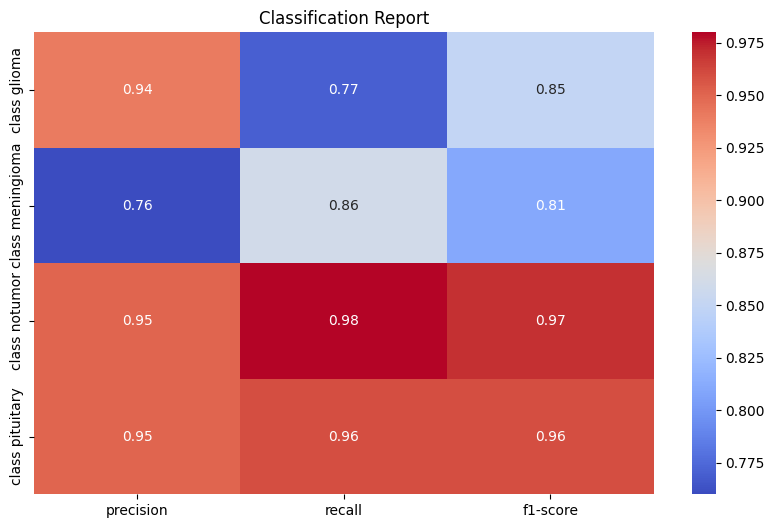

In [33]:
cr_dict = {
    'class glioma': {'precision': 0.94, 'recall': 0.77, 'f1-score': 0.85, 'support': 154},
    'class meningioma': {'precision': 0.76, 'recall': 0.86, 'f1-score': 0.81, 'support': 147},
    'class notumor': {'precision': 0.95, 'recall': 0.98, 'f1-score': 0.97, 'support': 205},
    'class pituitary': {'precision': 0.95, 'recall': 0.96, 'f1-score': 0.96, 'support': 150},

}
cr_df = pd.DataFrame(cr_dict).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(cr_df.iloc[:, :-1], annot=True, cmap='coolwarm', cbar=True)
plt.title('Classification Report')
plt.show()

Saving the best model weights locally and using them for global aggregation could introduce bias, particularly if some clients' data is not representative of the broader population. This can lead to a model that favors the data of certain clients over others, reducing generalization.
Instead of using local validation sets to determine the best model, you could use a global validation set or a validation set that is representative of the overall population. However, this is often impractical in federated learning due to privacy concerns and the decentralized nature of the data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Function to plot training accuracy and loss curves
def plot_performance(history, client_id=None, round_num=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'Client {client_id} Accuracy - Round {round_num}' if client_id else 'Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Client {client_id} Loss - Round {round_num}' if client_id else 'Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
# Function to print classification report and metrics
def show_classification_report(y_true, y_pred, class_names):
    # Classification report
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names)

    # Compute individual metrics
    TN, FP, FN, TP = cm.ravel()  # Assuming binary classification, otherwise use multi-class metrics
    print(f"True Positives (TP): {TP}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")
    print(f"False Negatives (FN): {FN}")

# function for client training after the edition of performance metrices

In [ ]:

# Modify the 'train_on_client' function to return the history object and plot performance per client
def train_on_client(model, client_data_gen, client_test_gen, client_val_gen, epochs=1, l2_norm_clip=0.01, noise_multiplier=0.01, num_microbatches=1, client_id=None, round_num=None):
    try:
        # Clone the model
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights()) # Ensure the model starts with the same weights

        # Ensure the microbatch configuration is correct
        if batch_size % num_microbatches != 0:
            raise ValueError(f"num_microbatches ({num_microbatches}) must divide batch_size ({batch_size}) evenly.")

        # Use DPAdam optimizer from TensorFlow Privacy with adaptive learning rate
        initial_learning_rate = 0.001
        lr_schedule = ExponentialDecay(
            initial_learning_rate,
            decay_steps=100,
            decay_rate=0.96,
            staircase=True)
        
        optimizer = DPKerasAdamOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=lr_schedule
        )

        model_copy.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model_copy.build(input_shape=(None, *img_shape))

        # Train the model on the client data
        history = model_copy.fit(client_data_gen,
                            epochs=epochs,
                            validation_data=client_val_gen,
                            shuffle=False,
                            verbose=1)

        # Plot performance after training
        plot_performance(history, client_id=client_id, round_num=round_num)

        # Evaluate the model on the client's test data
        test_loss, test_accuracy = model_copy.evaluate(client_test_gen)
        print(f"Final test accuracy for client {client_id}: {test_accuracy:.4f}")
        print(f"DP parameters l2_norm_clip: {l2_norm_clip} with noise_multiplier=:{noise_multiplier} with num_microbatches=:{num_microbatches}")

        return model_copy.get_weights(), history

    except ValueError as ve:
        print(f"ValueError during training on client: {str(ve)}")
        return None, None

    except Exception as e:
        print(f"Exception during training on client: {str(e)}")
        return None, None


Simulation of federated learning function after the adition of performance metrics( No need to add the federated average function as it would be un changed)

In [ ]:

# Modified simulate_federated_learning function to show performance plots after all rounds
def simulate_federated_learning(model, num_rounds, num_clients, epochs_per_client, l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier, num_microbatches=num_microbatches):
    # Initialize data generators for all clients once
    client_generators = []
    for i in range(num_clients):
        print(f"Initializing data generators for client {i + 1}")

        client_train_sample = train_df.sample(frac=1/num_clients, replace=False)
        client_test_sample = test_df.sample(frac=1/num_clients, replace=False)
        client_val_sample = valid_df.sample(frac=1/num_clients, replace=False)

        client_data_gen = tr_gen.flow_from_dataframe(
            client_train_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_val_gen = ts_gen.flow_from_dataframe(
            client_val_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_test_gen = ts_gen.flow_from_dataframe(
            client_test_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
        )

        client_generators.append((client_data_gen, client_test_gen, client_val_gen))

    # Start federated learning rounds
    for round_num in range(num_rounds):
        print(f"\nStarting round {round_num + 1}")
        client_weights = []

        for i, (client_data_gen, client_test_gen, client_val_gen) in enumerate(client_generators):
            print(f"Training client {i + 1}")

            client_result, history = train_on_client(
                model, client_data_gen, client_test_gen, client_val_gen, 
                epochs=epochs_per_client, l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier, num_microbatches=num_microbatches, client_id=i + 1, round_num=round_num + 1
            )

            if client_result is not None:
                client_weights.append(client_result)
                print(f"Client {i + 1} training completed successfully")
            else:
                print(f"Client {i + 1} training failed")

        if client_weights:
            # Perform federated averaging and update the global model
            new_weights = federated_averaging(client_weights)
            model.set_weights(new_weights)
        else:
            print("No successful client training in this round. Skipping federated averaging.")

        # Print model summary after each round
        print("\nModel summary after round:")
        model.summary()
        
        # Evaluate the global model on the overall test set
        print("\nEvaluating the final model")
        test_loss, test_accuracy = model.evaluate(test_gen)
        print(f"Final test accuracy: {test_accuracy:.4f}")
        
        # Generate predictions for performance metrics
        y_pred = model.predict(test_gen)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.array([class_indices[label] for label in test_df['labels']])
        
        # Ensure y_pred_classes and y_true have the same length
        min_length = min(len(y_pred_classes), len(y_true))
        y_pred_classes = y_pred_classes[:min_length]
        y_true = y_true[:min_length]

        # Show classification report and confusion matrix
        show_classification_report(y_true, y_pred_classes, class_names)

Intialization of parameters

Found 656 validated image filenames belonging to 4 classes.
Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Initializing data generators for client 1
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Initializing data generators for client 2
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Initializing data generators for client 3
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Initializing data generators for client 4
Found 1142 validated image filenames belonging to 4 classes.
Found 131 validated image filenames belonging to 4 classes.
Found 131 validated image

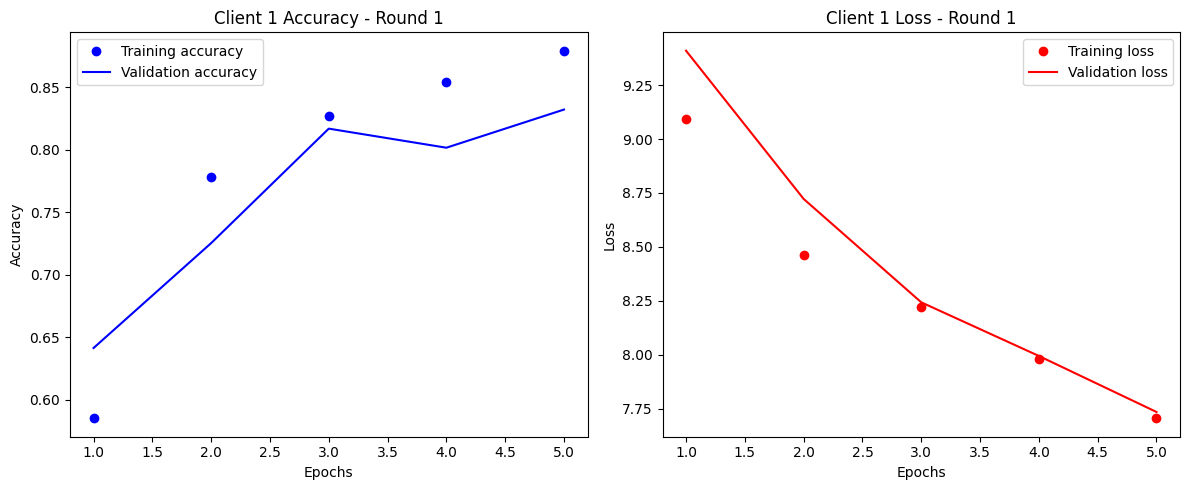

5/5 [==============================] - 11s 2s/step - loss: 7.7237 - accuracy: 0.8168
Final test accuracy for client 1: 0.8168
DP parameters l2_norm_clip: 0.1 with noise_multiplier=:0.01 with num_microbatches=:1
Client 1 training completed successfully
Training client 2
Epoch 1/5
36/36 [==============================] - 122s 3s/step - loss: 9.1002 - accuracy: 0.5683 - val_loss: 9.2062 - val_accuracy: 0.6794
Epoch 2/5
36/36 [==============================] - 101s 3s/step - loss: 8.5173 - accuracy: 0.7609 - val_loss: 8.6639 - val_accuracy: 0.7634
Epoch 3/5
36/36 [==============================] - 99s 3s/step - loss: 8.2184 - accuracy: 0.8345 - val_loss: 8.2480 - val_accuracy: 0.8321
Epoch 4/5
36/36 [==============================] - 101s 3s/step - loss: 7.9883 - accuracy: 0.8441 - val_loss: 7.9545 - val_accuracy: 0.8550
Epoch 5/5
36/36 [==============================] - 105s 3s/step - loss: 7.7523 - accuracy: 0.8546 - val_loss: 7.6835 - val_accuracy: 0.8550


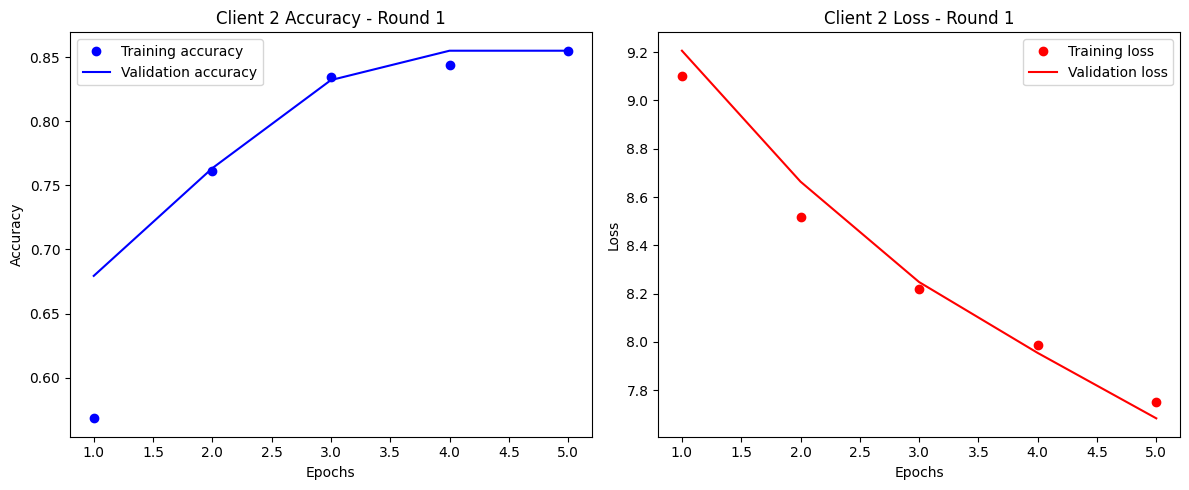

5/5 [==============================] - 10s 2s/step - loss: 7.6755 - accuracy: 0.8397
Final test accuracy for client 2: 0.8397
DP parameters l2_norm_clip: 0.1 with noise_multiplier=:0.01 with num_microbatches=:1
Client 2 training completed successfully
Training client 3
Epoch 1/5
36/36 [==============================] - 120s 3s/step - loss: 9.0902 - accuracy: 0.5543 - val_loss: 9.3341 - val_accuracy: 0.7023
Epoch 2/5
36/36 [==============================] - 104s 3s/step - loss: 8.5469 - accuracy: 0.7662 - val_loss: 8.7045 - val_accuracy: 0.7863
Epoch 3/5
36/36 [==============================] - 101s 3s/step - loss: 8.2679 - accuracy: 0.8126 - val_loss: 8.3128 - val_accuracy: 0.8015
Epoch 4/5
36/36 [==============================] - 103s 3s/step - loss: 8.0390 - accuracy: 0.8222 - val_loss: 8.0554 - val_accuracy: 0.8092
Epoch 5/5
36/36 [==============================] - 104s 3s/step - loss: 7.7949 - accuracy: 0.8643 - val_loss: 7.7696 - val_accuracy: 0.8168


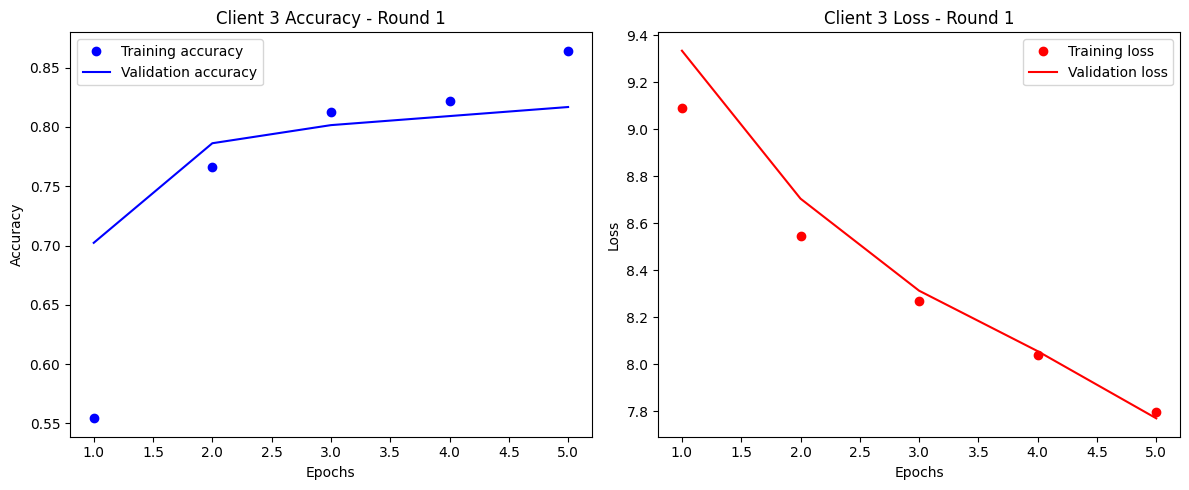

5/5 [==============================] - 11s 2s/step - loss: 7.6756 - accuracy: 0.8779
Final test accuracy for client 3: 0.8779
DP parameters l2_norm_clip: 0.1 with noise_multiplier=:0.01 with num_microbatches=:1
Client 3 training completed successfully
Training client 4
Epoch 1/5
36/36 [==============================] - 135s 3s/step - loss: 9.1327 - accuracy: 0.5683 - val_loss: 9.2224 - val_accuracy: 0.6870
Epoch 2/5
36/36 [==============================] - 108s 3s/step - loss: 8.4953 - accuracy: 0.7574 - val_loss: 8.6538 - val_accuracy: 0.7710
Epoch 3/5
36/36 [==============================] - 120s 3s/step - loss: 8.2922 - accuracy: 0.8039 - val_loss: 8.2088 - val_accuracy: 0.8244
Epoch 4/5
36/36 [==============================] - 106s 3s/step - loss: 8.0408 - accuracy: 0.8363 - val_loss: 7.9869 - val_accuracy: 0.8473
Epoch 5/5
36/36 [==============================] - 115s 3s/step - loss: 7.7741 - accuracy: 0.8695 - val_loss: 7.7272 - val_accuracy: 0.8397


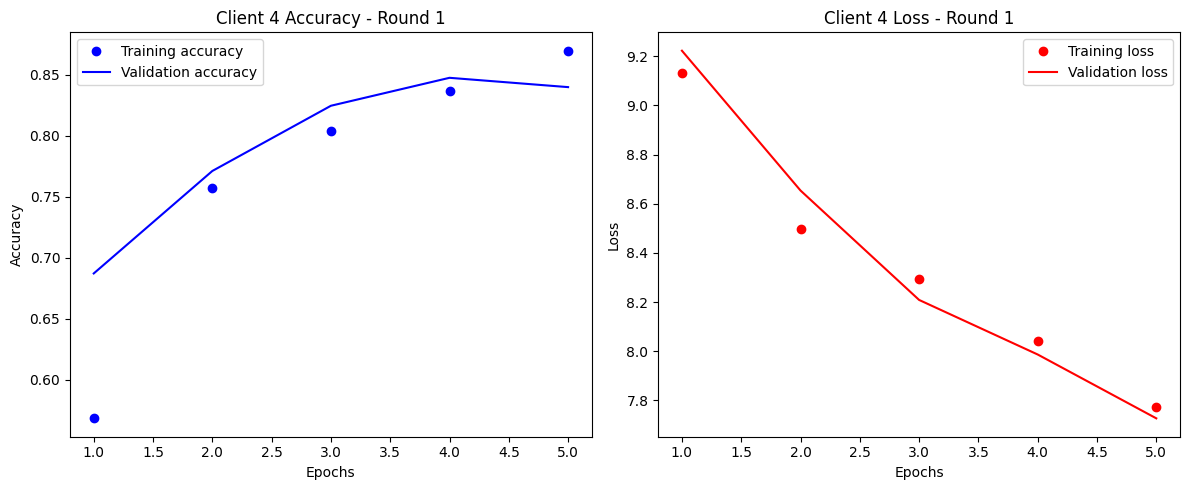

5/5 [==============================] - 12s 2s/step - loss: 7.6583 - accuracy: 0.8321
Final test accuracy for client 4: 0.8321
DP parameters l2_norm_clip: 0.1 with noise_multiplier=:0.01 with num_microbatches=:1
Client 4 training completed successfully
Training client 5
Epoch 1/5
36/36 [==============================] - 132s 3s/step - loss: 9.1201 - accuracy: 0.5482 - val_loss: 9.4469 - val_accuracy: 0.6565
Epoch 2/5
36/36 [==============================] - 115s 3s/step - loss: 8.5098 - accuracy: 0.7758 - val_loss: 8.7468 - val_accuracy: 0.7557
Epoch 3/5
36/36 [==============================] - 101s 3s/step - loss: 8.2427 - accuracy: 0.8231 - val_loss: 8.3838 - val_accuracy: 0.7405
Epoch 4/5
36/36 [==============================] - 103s 3s/step - loss: 7.9691 - accuracy: 0.8581 - val_loss: 8.0868 - val_accuracy: 0.8168
Epoch 5/5
36/36 [==============================] - 109s 3s/step - loss: 7.7333 - accuracy: 0.8643 - val_loss: 7.8241 - val_accuracy: 0.7786


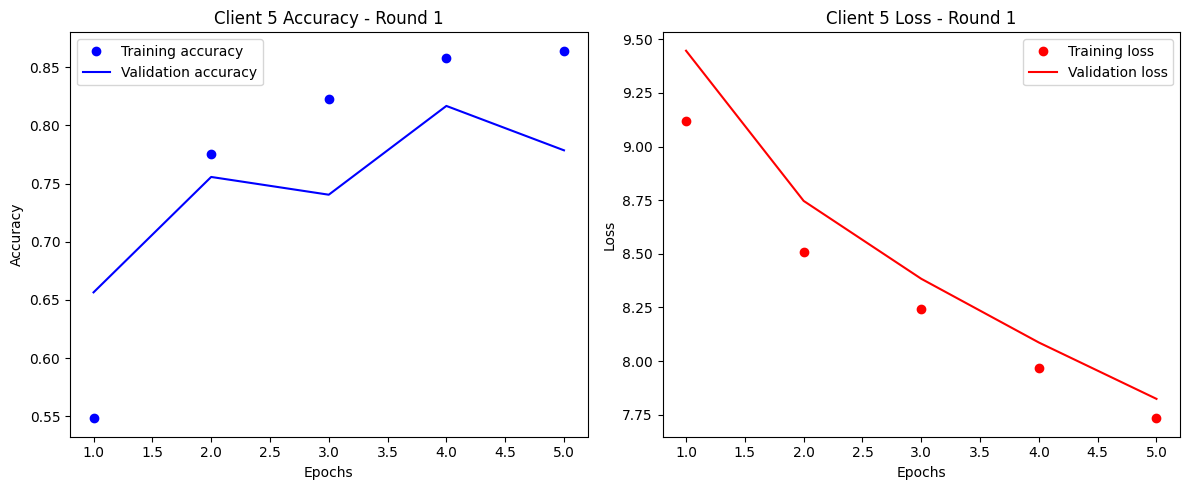

5/5 [==============================] - 11s 2s/step - loss: 7.7333 - accuracy: 0.7939
Final test accuracy for client 5: 0.7939
DP parameters l2_norm_clip: 0.1 with noise_multiplier=:0.01 with num_microbatches=:1
Client 5 training completed successfully

Model summary after round:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_8 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 256)               393472    
                                                                 
 dropout_8 (Dropout)         (None, 25

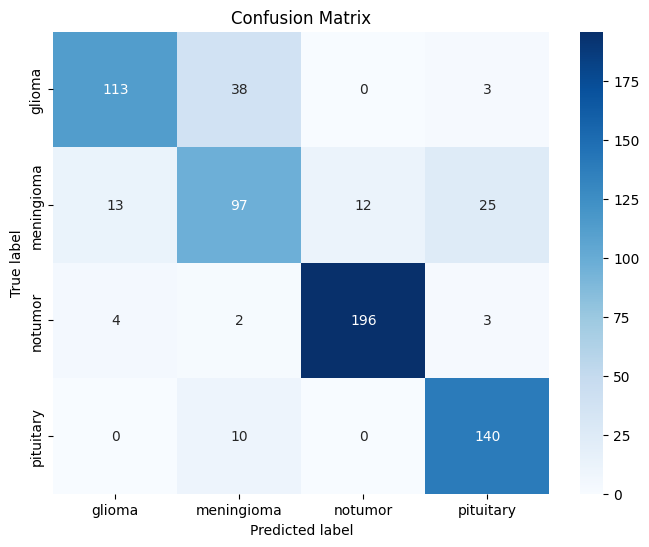

ValueError: too many values to unpack (expected 4)

In [56]:


# Assuming 'model' is your initialized model, and 'train_df', 'test_df', 'valid_df', 'tr_gen', 'ts_gen', 'img_size', 'batch_size' are already defined
# Parameters
num_rounds = 10
num_clients = 5
epochs_per_client = 5
l2_norm_clip = 0.1
noise_multiplier = 0.01
num_microbatches = 1 
model_name = 'efficient'
model = select_model(model_name)
# Run the simulation
simulate_federated_learning(model, num_rounds, num_clients, epochs_per_client, l2_norm_clip, noise_multiplier, num_microbatches)

# Testing the code with learning rate scheduling and with a pretrained model xception

# FedProx Algorithm

In [48]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
batch_size=32

# Generate test data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)


# Generate train data paths with labels
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data)

for fold in folds: 
    foldpath = os.path.join(train_data, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)


# Split data into validation and test sets
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 48)

# crobed image size
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

test_gen = ts_gen.flow_from_dataframe(
            test_df, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


# Class information
class_names = sorted(train_df['labels'].unique())
num_classes = len(class_names)
class_count = len(class_names)
class_indices = {label: idx for idx, label in enumerate(class_names)}

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


            
# Optimized model creation


def create_improved_model():
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", 
    input_tensor=None, input_shape=img_shape, pooling='max')
    
    base_model.trainable = False  # Freeze base model initially

    model = Sequential([
        base_model,
        BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
        Dense(256, kernel_regularizer= regularizers.l2(0.016),
              activity_regularizer= regularizers.l1(0.006),
              bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
        Dropout(rate= 0.45, seed= 123),
        Dense(class_count, activation='softmax')
    ])
    return model

# 3. Compile with appropriate loss and metrics
model=create_improved_model()

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
# Parameters
num_rounds = 2
num_clients = 2
epochs_per_client = 1
l2_norm_clip = 0.1
noise_multiplier = 0.01
num_microbatches = 1  # Set this equal to batch_size if you're using one microbatch per batch
mu=0.01



def create_fedprox_optimizer(mu=0.01, global_weights=None, *args, **kwargs):
    """
    FedProxOptimizer with differential privacy. Extends DPKerasAdamOptimizer
    to include a proximal term.

    Args:
        mu: Weight of the proximal term.
        global_weights: Weights of the global model (to be set before training).
        *args: Additional arguments for DPKerasAdamOptimizer.
        **kwargs: Additional keyword arguments for DPKerasAdamOptimizer.
    """
    class FedProxOptimizer(DPKerasAdamOptimizer):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.mu = mu
            self.global_weights = global_weights

        def set_global_weights(self, weights):
            self.global_weights = weights

        def get_gradients(self, loss, params):
            grads = super().get_gradients(loss, params)
            if self.global_weights is not None:
                for i, (grad, param) in enumerate(zip(grads, params)):
                    if self.global_weights[i] is not None:
                        prox_term = self.mu * (param - self.global_weights[i])
                        grad += prox_term
            return grads

    return FedProxOptimizer(*args, **kwargs)
    
#define training on client
def train_on_client(model, client_data_gen, client_test_gen, client_val_gen, global_weights, epochs=1, l2_norm_clip=0.1, noise_multiplier=0.01, num_microbatches=1, mu=mu):
    try:
        # Clone the model
        model_copy = tf.keras.models.clone_model(model)
        model_copy.set_weights(model.get_weights())  # Ensure the model starts with the same weights

        # Ensure the microbatch configuration is correct
        if batch_size % num_microbatches != 0:
            raise ValueError(f"num_microbatches ({num_microbatches}) must divide batch_size ({batch_size}) evenly.")

        # Use FedProxOptimizer with DP
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100,
            decay_rate=0.96,
            staircase=True)
        
        optimizer = create_fedprox_optimizer(
            mu=mu,
            global_weights=global_weights,
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=lr_schedule
        )

        model_copy.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        model_copy.build(input_shape=(None, *img_shape))

        # Debugging information about the client generator
        print(f"Client generator length: {len(client_data_gen)}")

        # Train the model on the client data
        history = model_copy.fit(client_data_gen,
                            epochs=epochs,
                            validation_data=client_val_gen,
                            shuffle=False,
                            verbose=1)

        # Evaluate the model on the client's test data
        test_loss, test_accuracy = model_copy.evaluate(client_test_gen)
        print(f"Final test accuracy: {test_accuracy:.4f}")
        print(f"DP parameters l2_norm_clip: {l2_norm_clip} with noise_multiplier=:{noise_multiplier} with num_microbatches=:{num_microbatches}")
        plot_performance(history)
        return model_copy.get_weights()

    except ValueError as ve:
        print(f"ValueError during training on client: {str(ve)}")
        return None

    except Exception as e:
        print(f"Exception during training on client: {str(e)}")
        return None
def simulate_federated_learning(model, num_rounds, num_clients, epochs_per_client, l2_norm_clip=0.1, noise_multiplier=0.1, num_microbatches=1, mu=0.01):
    # Initialize data generators for all clients
    client_generators = []
    for i in range(num_clients):
        print(f"Initializing data generators for client {i + 1}")

        client_train_sample = train_df.sample(frac=1/num_clients, replace=False)
        client_test_sample = test_df.sample(frac=1/num_clients, replace=False)
        client_val_sample = valid_df.sample(frac=1/num_clients, replace=False)

        client_data_gen = tr_gen.flow_from_dataframe(
            client_train_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_val_gen = ts_gen.flow_from_dataframe(
            client_val_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
        )

        client_test_gen = ts_gen.flow_from_dataframe(
            client_test_sample, x_col='filepaths', y_col='labels', target_size=img_size,
            class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
        )

        client_generators.append((client_data_gen, client_test_gen, client_val_gen))

    # Get the initial global weights from the model
    global_weights = model.get_weights()

    # Federated learning rounds
    for round_num in range(num_rounds):
        print(f"\nStarting round {round_num + 1}")
        client_weights = []

        # Iterate over clients
        for i, (client_data_gen, client_test_gen, client_val_gen) in enumerate(client_generators):
            print(f"Training client {i + 1}")

            # Train on each client, passing the global weights for the FedProx optimizer
            client_result = train_on_client(
                model=model, 
                client_data_gen=client_data_gen, 
                client_test_gen=client_test_gen, 
                client_val_gen=client_val_gen, 
                global_weights=global_weights,  # Pass global weights here
                epochs=epochs_per_client, 
                l2_norm_clip=l2_norm_clip, 
                noise_multiplier=noise_multiplier, 
                num_microbatches=num_microbatches,
                mu=mu  # Proximal term weight
            )

            if client_result is not None:
                client_weights.append(client_result)
                print(f"Client {i + 1} training completed successfully")
            else:
                print(f"Client {i + 1} training failed")

        # Federated Averaging of client weights after each round
        if client_weights:
            global_weights = federated_averaging(client_weights)  # Federated averaging step
            model.set_weights(global_weights)  # Update global model with the averaged weights

            # Evaluate the updated global model
            test_loss, test_accuracy = model.evaluate(test_gen)
            print(f"Global model test accuracy: {test_accuracy:.4f}")

        else:
            print("No successful client training in this round. Skipping federated averaging.")

        # Print model summary after each round
        print("\nModel summary after round:")
        model.summary()

        # Evaluate the final global model after all rounds
        print("\nEvaluating the final global model")
        test_loss, test_accuracy = model.evaluate(test_gen)
        print(f"Final global test accuracy: {test_accuracy:.4f}")

        # Generate predictions for performance metrics
        y_pred = model.predict(test_gen)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.array([class_indices[label] for label in test_df['labels']])
        
        # Ensure y_pred_classes and y_true have the same length
        min_length = min(len(y_pred_classes), len(y_true))
        y_pred_classes = y_pred_classes[:min_length]
        y_true = y_true[:min_length]

        # Compute confusion matrix and classification report
        cm = confusion_matrix(y_true, y_pred_classes)
        cr = classification_report(y_true, y_pred_classes, target_names=class_names)
        print("\nClassification Report:\n", cr)

        # Optional: Estimate the privacy loss (you may want to enable this for DP)
        # epsilon, _ = compute_dp_sgd_privacy(len(train_df), batch_size, noise_multiplier, num_rounds, 1e-5)
        # print(f"DP-SGD with (ε = {epsilon:.2f}, δ = 1e-5) after {num_rounds} rounds of training")


# Run the simulation
# Run the simulation
simulate_federated_learning(
    model=model, 
    num_rounds=num_rounds, 
    num_clients=num_clients, 
    epochs_per_client=epochs_per_client, 
    l2_norm_clip=l2_norm_clip, 
    noise_multiplier=noise_multiplier, 
    num_microbatches=num_microbatches, 
    mu=mu  # Proximal term weight
)

Found 656 validated image filenames belonging to 4 classes.
Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Initializing data generators for client 1
Found 2856 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Initializing data generators for client 2
Found 2856 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.

Starting round 1
Training client 1
Exception during training on client: function() argument 'code' must be code, not str
Client 1 training failed
Training client 2
Exception during training on client: function() argument 'code' must be code, not str
Client 2 training failed
No successful client training in this round. Skipping federated averaging.

Model summary after round:
Model: "sequential_7"
__________

KeyboardInterrupt: 

# Below is not the preferable method for experiments

In [2]:

# Custom callback to check for NaN losses
class NanLossCallback(Callback):
    def on_batch_end(self, batch, logs=None):
        if logs is not None and np.isnan(logs.get('loss')):
            print(f"\nNaN loss encountered, stopping training.")
            self.model.stop_training = True

callbacks = [
    TerminateOnNaN(),
    ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-7),
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    NanLossCallback()
]

In [3]:

# Loss functions
class CategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, name="categorical_focal_loss"):
        super(CategoricalFocalLoss, self).__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0)
        
        # Calculate the focal loss components
        cross_entropy = y_true * tf.math.log(y_pred)
        weight = y_true * tf.pow(1 - y_pred, self.gamma)
        loss = -self.alpha * weight * cross_entropy
        
        return tf.reduce_sum(loss, axis=1)

In [4]:

# Constants
img_size = (224, 224)
batch_size = 32
num_clients = 1
num_rounds = 2
epochs_per_client = 1
noise_multiplier = 0.01  # For differential privacy

In [5]:
# Prepare dataset paths and labels
def prepare_dataset(data_dir):
    filepaths = []
    labels = []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [6]:

train_df = prepare_dataset('/kaggle/input/brain-tumor-mri-dataset/Training')
ts_df = prepare_dataset('/kaggle/input/brain-tumor-mri-dataset/Testing')

# Split data into validation and test sets
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=48)

# Class information
class_names = sorted(train_df['labels'].unique())
num_classes = len(class_names)
class_indices = {label: idx for idx, label in enumerate(class_names)}

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [8]:
# Custom Data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class CustomDataGenerator(Sequence):
    def __init__(self, dataframe, class_indices, num_classes, batch_size=32, img_size=(224, 224), shuffle=True, augment=False, **kwargs):
        super().__init__(**kwargs)  # Properly initialize the parent class

        self.dataframe = dataframe
        self.class_indices = class_indices
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.augment = augment

        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = None
        
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indexes]

        images = []
        labels = []
        for _, row in batch_data.iterrows():
            try:
                img = load_img(row['filepaths'], target_size=self.img_size)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(self.class_indices[row['labels']])
            except Exception as e:
                print(f"Error loading image {row['filepaths']}: {str(e)}")

        images = np.array(images, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)
        labels = tf.keras.utils.to_categorical(labels, num_classes=self.num_classes)

        if self.datagen:
            images = np.array([self.datagen.random_transform(img) for img in images])

        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [9]:
# Optimized model creation

def create_optimized_model():
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False, weights="imagenet",
        input_shape=img_size + (3,), pooling='max'
    )
    base_model.trainable = True

    input_layer = tf.keras.layers.Input(shape=img_size + (3,))
    x = base_model(input_layer)
    
    # Adding a Dense layer followed by BatchNormalization and activation
    x = tf.keras.layers.Dense(128)(x)  # Note: No activation here
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)  # LeakyReLU as activation
    
    # Adding Dropout after BatchNormalization and activation
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    # Output layer with softmax activation
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', 
                                         kernel_initializer='glorot_uniform')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [10]:
# Create and compile the model
model = create_optimized_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)  # Added clipnorm
model.compile(optimizer=optimizer, 
              loss=CategoricalFocalLoss(alpha=0.25, gamma=2.0),
              metrics=['accuracy'])
# Print the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

In [14]:
# Training on client
def train_on_client(model, client_gen, round_num, client_num, epochs=3):
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())

    for layer in model_copy.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.0001,  # Reduced initial learning rate
        decay_steps=100,
        decay_rate=0.98,  # Slower decay
        staircase=True
    )
    base_optimizer = Adam(learning_rate=lr_schedule, clipnorm=0.5)  # Increased clipnorm
    optimizer = LossScaleOptimizer(base_optimizer)

    model_copy.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=3,
        restore_best_weights=True
    )

    nan_loss_callback = NanLossCallback()

    try:
        print(f"Training client {client_num} in round {round_num}")
        history = model_copy.fit(
            client_gen,
            epochs=epochs,
            callbacks=callbacks + [nan_loss_callback],
            verbose=1
        )
        client_performances.append({
            'round': round_num,
            'client': client_num,
            'accuracy': history.history['accuracy'][-1],
            'loss': history.history['loss'][-1]
        })
        return clip_weights(model_copy.get_weights())
    except Exception as e:
        print(f"Error in client {client_num} training: {str(e)}")
        return None

In [15]:
# Weight clipping
def clip_weights(weights, clip_norm=1.0):
    return [np.clip(w, -clip_norm, clip_norm) for w in weights]

def train_on_client(model, client_gen, epochs=1):
    # Clone the model
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())

    # Create a new optimizer instance
    optimizer = Adamax(learning_rate=0.001)
    model_copy.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    try:
        # Print debug information about the client generator
        print(f"Client generator length: {len(client_gen)}")
        
        # Get a batch of data
        x_batch, y_batch = next(iter(client_gen))
        
        print(f"Input batch shape: {x_batch.shape}")
        print(f"Input batch dtype: {x_batch.dtype}")
        print(f"Label batch shape: {y_batch.shape}")
        print(f"Label batch dtype: {y_batch.dtype}")
        
        # Print model input shape
        print(f"Model input shape: {model_copy.input_shape}")
        
        # Try to predict on a single batch to check compatibility
        try:
            test_pred = model_copy.predict(x_batch, verbose=0)
            print(f"Test prediction shape: {test_pred.shape}")
        except Exception as pred_error:
            print(f"Error during test prediction: {str(pred_error)}")
        
        history = model_copy.fit(client_gen, epochs=epochs, verbose=1)
        return model_copy.get_weights()
    except Exception as e:
        print(f"Detailed error in client training: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        
        # If it's a ValueError, print more details
        if isinstance(e, ValueError):
            print(f"ValueError details: {e.args}")
        
        return None

In [16]:
def federated_averaging(client_weights, noise_multiplier=0.5):
    # Average the weights
    avg_weights = [np.mean([client_weights[i][j] for i in range(len(client_weights))], axis=0)
                   for j in range(len(client_weights[0]))]

    # Optionally add noise for differential privacy
    if noise_multiplier > 0:
        avg_weights = [w + np.random.normal(0, noise_multiplier, w.shape) for w in avg_weights]

    return avg_weights

In [17]:
# Simulate federated learning
for round_num in range(num_rounds):
    print(f"\nStarting round {round_num + 1}")
    client_weights = []

    for i in range(num_clients):
        print(f"Training client {i + 1}")
        client_sample = train_df.sample(frac=1/num_clients, replace=False)
        client_data_gen = CustomDataGenerator(client_sample, batch_size=batch_size, img_size=img_size,class_indices=class_indices, num_classes=num_classes)
        
        print(f"Client {i + 1} data shape: {client_sample.shape}")
        print(f"Client {i + 1} label distribution: {client_sample['labels'].value_counts()}")
        
        client_result = train_on_client(model, client_data_gen, epochs=epochs_per_client)
        if client_result is not None:
            client_weights.append(client_result)
            print(f"Client {i + 1} training completed successfully")
        else:
            print(f"Client {i + 1} training failed")

    if client_weights:
        print("Performing federated averaging")
        new_weights = federated_averaging(client_weights, noise_multiplier=noise_multiplier)
        model.set_weights(new_weights)
    else:
        print("No successful client training in this round. Skipping federated averaging.")

    # Print model summary after each round
    print("\nModel summary after round:")
    model.summary()


Starting round 1
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 76s 178ms/step - accuracy: 0.8120 - loss: 0.5224
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 2
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.9102 - loss: 0.2573
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 3
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.9366 - loss: 0.1955
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 4
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.9565 - loss: 0.1261
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 5
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 62s 135ms/step - accuracy: 0.9525 - loss: 0.1512
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 6
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.9698 - loss: 0.0877
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 7
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 55s 90ms/step - accuracy: 0.9750 - loss: 0.0746
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 8
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 52s 86ms/step - accuracy: 0.9810 - loss: 0.0677
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 9
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 54s 83ms/step - accuracy: 0.9715 - loss: 0.0914
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)


Starting round 10
Training client 1
Client 1 data shape: (5712, 2)
Client 1 label distribution: labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64
Client generator length: 178
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
178/178 ━━━━━━━━━━━━━━━━━━━━ 52s 85ms/step - accuracy: 0.9831 - loss: 0.0544
Client 1 training completed successfully
Performing federated averaging

Model summary after round:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,980 (9.24 MB)

 Trainable params: 2,388,612 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

In [21]:

# Define the test generator
test_gen = CustomDataGenerator(
    dataframe=test_df,
    class_indices=class_indices,
    num_classes=num_classes,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False,  # No shuffling for test data
    augment=False   # No augmentation for test data
)
evaluate_model(model,num_clients,num_rounds,test_gen)


Evaluating the:<Functional name=functional_1, built=True>with dp=0.01 with number of clients=1 and round=10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.2307 - loss: nan
Final test accuracy: 0.2313


In [20]:
# Evaluate the model after federated learning
def evaluate_model(model,num_clients,num_rounds,test_gen):
    print(f"Evaluating the:{model}with dp=0.01 with number of clients={num_clients} and round={num_rounds}")
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"Final test accuracy: {test_accuracy:.4f}")

In [ ]:
# Generate predictions for performance metrics
def prediction_gen(test_gen):
    y_pred = model.predict(test_gen) 
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.array([class_indices[label] for label in test_df['labels']])

In [ ]:
# Ensure y_pred_classes and y_true have the same length
min_length = min(len(y_pred_classes), len(y_true))
y_pred_classes = y_pred_classes[:min_length]
y_true = y_true[:min_length]

In [ ]:
   # Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

In [ ]:
   # Compute classification report
cr = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:\n", cr)
   

In [ ]:
# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Fine-tuning (optional)
for layer in model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adamax(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for a few more epochs
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, shuffle=False)

# Final evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'\nFinal Fine-tuned Test Accuracy: {test_accuracy:.4f}')

In [ ]:

# Print the model summary
model.summary()

def train_on_client(model, client_gen, epochs=1):
    # Clone the model
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())

    # Create a new optimizer instance
    optimizer = Adamax(learning_rate=0.001)
    model_copy.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    try:
        # Print debug information about the client generator
        print(f"Client generator length: {len(client_gen)}")
        
        # Get a batch of data
        x_batch, y_batch = next(iter(client_gen))
        
        print(f"Input batch shape: {x_batch.shape}")
        print(f"Input batch dtype: {x_batch.dtype}")
        print(f"Label batch shape: {y_batch.shape}")
        print(f"Label batch dtype: {y_batch.dtype}")
        
        # Print model input shape
        print(f"Model input shape: {model_copy.input_shape}")
        
        # Try to predict on a single batch to check compatibility
        try:
            test_pred = model_copy.predict(x_batch, verbose=0)
            print(f"Test prediction shape: {test_pred.shape}")
        except Exception as pred_error:
            print(f"Error during test prediction: {str(pred_error)}")
        
        history = model_copy.fit(client_gen, epochs=epochs, verbose=1)
        return model_copy.get_weights()
    except Exception as e:
        print(f"Detailed error in client training: {str(e)}")
        print(f"Error type: {type(e).__name__}")
        
        # If it's a ValueError, print more details
        if isinstance(e, ValueError):
            print(f"ValueError details: {e.args}")
        
        return None
def federated_averaging(client_weights, noise_multiplier=0.5):
    # Average the weights
    avg_weights = [np.mean([client_weights[i][j] for i in range(len(client_weights))], axis=0)
                   for j in range(len(client_weights[0]))]

    # Optionally add noise for differential privacy
    if noise_multiplier > 0:
        avg_weights = [w + np.random.normal(0, noise_multiplier, w.shape) for w in avg_weights]

    return avg_weights
    
# Simulate federated learning
for round_num in range(num_rounds):
    print(f"\nStarting round {round_num + 1}")
    client_weights = []

    for i in range(num_clients):
        print(f"Training client {i + 1}")
        client_sample = train_df.sample(frac=1/num_clients, replace=False)
        client_data_gen = CustomDataGenerator(client_sample, batch_size=batch_size, img_size=img_size)
        
        print(f"Client {i + 1} data shape: {client_sample.shape}")
        print(f"Client {i + 1} label distribution: {client_sample['labels'].value_counts()}")
        
        client_result = train_on_client(model, client_data_gen, epochs=epochs_per_client)
        if client_result is not None:
            client_weights.append(client_result)
            print(f"Client {i + 1} training completed successfully")
        else:
            print(f"Client {i + 1} training failed")

    if client_weights:
        print("Performing federated averaging")
        new_weights = federated_averaging(client_weights, noise_multiplier=noise_multiplier)
        model.set_weights(new_weights)
    else:
        print("No successful client training in this round. Skipping federated averaging.")

    # Print model summary after each round
    print("\nModel summary after round:")
    model.summary()

# Evaluate the model after federated learning
print("\nEvaluating the final model")
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Final test accuracy: {test_accuracy:.4f}")

# Generate predictions for performance metrics
y_pred = model.predict(test_gen) # Fixed indentation
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.array([class_indices[label] for label in test_df['labels']])

   # Ensure y_pred_classes and y_true have the same length
min_length = min(len(y_pred_classes), len(y_true))
y_pred_classes = y_pred_classes[:min_length]
y_true = y_true[:min_length]

   # Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

   # Compute classification report
cr = classification_report(y_true, y_pred_classes, target_names=class_names)
print("\nClassification Report:\n", cr)
   


# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Precision-Recall and ROC Curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Fine-tuning (optional)
for layer in model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adamax(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for a few more epochs
history = model.fit(train_gen, validation_data=valid_gen, epochs=10, shuffle=False)

# Final evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'\nFinal Fine-tuned Test Accuracy: {test_accuracy:.4f}')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,059 (42.64 MB)

 Trainable params: 11,091,244 (42.31 MB)

 Non-trainable params: 87,815 (343.03 KB)


Starting round 1
Training client 1
Client 1 data shape: (1142, 2)
Client 1 label distribution: labels
notumor       311
pituitary     304
glioma        266
meningioma    261
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)


I0000 00:00:1725133235.133964     117 service.cc:145] XLA service 0x7f45ec18d180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725133235.134022     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725133242.614586     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 155s 230ms/step - accuracy: 0.6287 - loss: 1.1994
Client 1 training completed successfully
Training client 2
Client 2 data shape: (1142, 2)
Client 2 label distribution: labels
notumor       333
glioma        293
pituitary     268
meningioma    248
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.6037 - loss: 1.1074
Client 2 training completed successfully
Training client 3
Client 3 data shape: (1142, 2)
Client 3 label distribution: labels
notumor       326
pituitary     298
glioma        269
meningioma    249
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,059 (42.64 MB)

 Trainable params: 11,091,244 (42.31 MB)

 Non-trainable params: 87,815 (343.03 KB)


Starting round 2
Training client 1
Client 1 data shape: (1142, 2)
Client 1 label distribution: labels
notumor       312
pituitary     295
meningioma    277
glioma        258
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - accuracy: 0.2514 - loss: 12.3500
Client 1 training completed successfully
Training client 2
Client 2 data shape: (1142, 2)
Client 2 label distribution: labels
notumor       309
pituitary     288
meningioma    281
glioma        264
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 140s 231ms/step - accuracy: 0.2962 - l

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,059 (42.64 MB)

 Trainable params: 11,091,244 (42.31 MB)

 Non-trainable params: 87,815 (343.03 KB)


Starting round 3
Training client 1
Client 1 data shape: (1142, 2)
Client 1 label distribution: labels
notumor       314
pituitary     288
meningioma    275
glioma        265
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 143s 230ms/step - accuracy: 0.2398 - loss: 19.8076
Client 1 training completed successfully
Training client 2
Client 2 data shape: (1142, 2)
Client 2 label distribution: labels
notumor       321
pituitary     311
meningioma    261
glioma        249
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 139s 229ms/step - accuracy: 0.2824 - l

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,179,059 (42.64 MB)

 Trainable params: 11,091,244 (42.31 MB)

 Non-trainable params: 87,815 (343.03 KB)


Starting round 4
Training client 1
Client 1 data shape: (1142, 2)
Client 1 label distribution: labels
notumor       325
pituitary     287
meningioma    284
glioma        246
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - accuracy: 0.2797 - loss: 23.2630
Client 1 training completed successfully
Training client 2
Client 2 data shape: (1142, 2)
Client 2 label distribution: labels
notumor       337
pituitary     298
glioma        260
meningioma    247
Name: count, dtype: int64
Client generator length: 35
Input batch shape: (32, 224, 224, 3)
Input batch dtype: float32
Label batch shape: (32, 4)
Label batch dtype: float64
Model input shape: (None, 224, 224, 3)
Test prediction shape: (32, 4)
35/35 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - accuracy: 0.2558 - l

In [ ]:
# Parameters
num_clients = [5] # This is a list
rounds = [10]  # List of rounds to try
use_dp = True
dp_param_list = [
    {'l2_norm_clip': 1.0, 'noise_multiplier': 0.1, 'num_microbatches': 1},
    {'l2_norm_clip': 1.5, 'noise_multiplier': 0.5, 'num_microbatches': 1},
    #{'l2_norm_clip': 2.0, 'noise_multiplier': 1.0, 'num_microbatches': 1}
]
img_size = (224, 224)
batch_size = 32
train_data = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Load and preprocess data
train_df, test_df = load_data(train_data, test_data)
train_gen, test_gen = create_data_generators(train_df, test_df, img_size, batch_size)
num_classes = len(list(train_gen.class_indices.keys()))


# List of pretrained models to try DenseNet121, VGG19, and Inception V3
model_names = ["VGG19", "InceptionV3", "DenseNet121"]
# Dictionary to store results for comparison
comparison_results = {
    'model_name': [],
    'rounds': [],
    'dp_params': [],
    'num_clients': [],
    'train_accuracy': [],
    'test_accuracy': [],
    'train_loss': [],
    'test_loss': [],
    'classification_report': [],
    'confusion_matrix': [],
    'roc_auc': [],
    'average_precision': []
}

# Run experiments for each combination of model, DP parameters, and rounds
for model_name in model_names:
    for dp_params in dp_param_list:
        for num_rounds in rounds:
            for num_client in num_clients:
                print(f"Running {model_name} with DP params {dp_params} for {num_rounds} rounds with {num_client} clients")
                model, results = run_experiment(model_name, num_classes, num_client, num_rounds, use_dp, dp_params, train_gen, test_gen)

                if model is None:
                    print(f"Training failed for {model_name} with DP params {dp_params} after {num_rounds} rounds.")
                else:
                    print(f"Completed {model_name} with DP params {dp_params} for {num_rounds} rounds with {num_client} clients")
                    # Store results for comparison
                    comparison_results['model_name'].append(model_name)
                    comparison_results['rounds'].append(num_rounds)
                    comparison_results['dp_params'].append(dp_params)
                    comparison_results['num_clients'].append(num_client)
                    comparison_results['train_accuracy'].append(results['train_accuracy'])
                    comparison_results['test_accuracy'].append(results['test_accuracy'])
                    comparison_results['train_loss'].append(results['train_loss'])
                    comparison_results['test_loss'].append(results['test_loss'])
                    comparison_results['classification_report'].append(results['classification_report'])
                    comparison_results['confusion_matrix'].append(results['confusion_matrix'])
                    comparison_results['roc_auc'].append(results['roc_auc'])
                    comparison_results['average_precision'].append(results['average_precision'])